In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import wandb 

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston

import pytorch_lightning as pl

from nam.data import *
from nam.config import *
from nam.models import *
from nam.trainer import *
from nam.utils import *

In [16]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, save_model_frequency=2, seed=1377, shuffle=True, test_split=0.2, training_epochs=10, units_multiplier=2, use_dnn=False, wandb=True)


In [17]:
config.training_epochs = 1
# config.output_regularization = 0.5
# config.l2_regularization = 0.5
config.batch_size=4096
# config.feature_dropout = 0.5
# config.hidden_sizes = [64, 32, 16]
config.wandb = False

In [18]:
# dataset = load_sklearn_housing_data(config)
dataset = load_gallup_data(config, 
                           features_columns= ["income_2", "WP1219", "WP1220"],
                          weights_column=None)

model = NAM(
  config=config,
  name="NAM_Housing",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)

trainer = Trainer(config, model, dataset)
trainer.train()
trainer.test()

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [19]:
feature_contributions = get_feature_contributions(model, dataset)
for fc in feature_contributions: print(fc[:10], fc.shape)

[-0.        -0.        -0.        -0.        -0.8293146 -0.8456016
 -0.        -0.        -0.        -0.       ] (104803,)
[-0.1285007 -0.       ] (2,)
[-0.7788412 -0.        -0.362683  -0.809058   0.1220648  0.
  0.        -0.         0.        -0.       ] (88,)


In [20]:
calc_mean_prediction(model, dataset)

({'income_2': -0.26990503, 'WP1219': 0.30987608, 'WP1220': -0.0001092372},
 {'income_2': array([-0.        , -0.        , -0.48620623, ..., -0.48137563,
         -0.        , -0.39473522], dtype=float32),
  'WP1219': array([0.13288684, 0.4657935 ], dtype=float32),
  'WP1220': array([-0.        ,  0.        , -0.3245645 ,  0.6565978 , -0.        ,
          0.        ,  1.1140628 ,  0.        ,  0.        ,  0.4389859 ,
          0.        , -0.        , -1.5488696 , -0.        , -0.        ,
         -0.        , -0.        , -0.0144829 ,  0.        , -0.        ,
          0.07802607,  0.30416304, -0.        , -0.        , -0.        ,
         -0.46035904,  0.        , -0.40984255,  0.3637053 ,  0.        ,
         -0.        ,  0.8479199 ,  0.        ,  0.        , -0.        ,
         -0.        , -0.19711792,  0.        , -0.63847286, -0.        ,
          0.4074275 ,  0.        , -0.        , -0.        , -1.0501964 ,
          0.        , -0.        , -0.6066296 ,  0.        

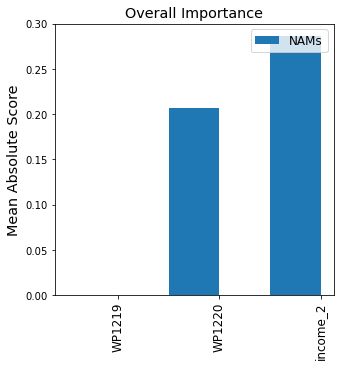

In [21]:
fig = plot_mean_feature_importance(model, dataset)

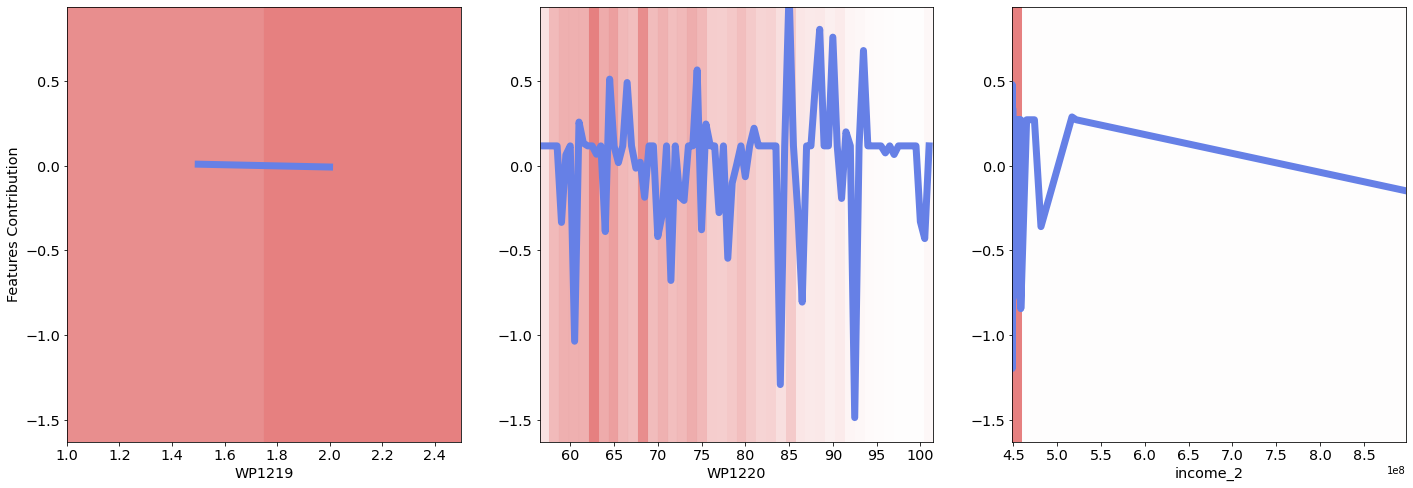

In [22]:
fig = plot_nams(model, dataset, num_cols= 3)

# WandB 

In [1]:
import wandb 

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston

import pytorch_lightning as pl

from nam.data import *
from nam.config import *
from nam.models import *
from nam.trainer import *
from nam.utils import *

In [2]:
def run():
    config = defaults()
    config.training_epochs = 2
    
#     dataset = load_sklearn_housing_data(config)
    dataset = load_gallup_data(config, 
                               features_columns= ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
                               weights_column=None)
    
    model = NAM(
      config=config,
      name="NAM_GallUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
    )
    
    
    trainer = Trainer(config, model, dataset)
    trainer.train()
    trainer.test()
    
    fig = plot_nams(model, dataset)
    wandb.log({
        "plot_mean_feature_importance": wandb.Image(plot_mean_feature_importance(model, dataset)),
        "plot_nams": wandb.Image(plot_nams(model, dataset))
    })

In [3]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'Logs/LossValEpoch',
        'goal': 'minimize'
    },
    'parameters': {
        'activation': {
            'values': ["exu", "relu"]
        },
        "batch_size": {
            'values': [2048, 4096]
        },
        "dropout": {
            'min': 0.0,
            'max': 1.0
        },
        "feature_dropout": {
            'min': 0.0,
            'max': 1.0
        },
        "output_regularization": {
            'min': 0.0,
            'max': 1.0
        },
        "lr": {
            'min': 1e-4,
            'max': 0.1
        },
        "hidden_sizes": {
            'values': [[], [32], [64, 32], [128, 64, 32]]
        },
        "num_basis_functions": {
            'min': 10,
            'max': 1000
        },
        "num_units": {
            'min': 8,
            'max': 128
        },
        "units_multiplier": {
            'min': 2,
            'max': 16
        }
    }
}

In [4]:
sweep_id = wandb.sweep(sweep_config, project="nam")

Create sweep with ID: 16jveiav
Sweep URL: https://wandb.ai/amrmkayid/nam/sweeps/16jveiav


wandb: Agent Starting Run: 4adso2ow with config:
wandb: 	activation: exu
wandb: 	batch_size: 4096
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	hidden_sizes: [128, 64, 32]
wandb: 	lr: 0.01261815805028057
wandb: 	num_basis_functions: 307
wandb: 	num_units: 51
wandb: 	output_regularization: 1
wandb: 	units_multiplier: 7
Run 4adso2ow errored: ValueError("Input contains NaN, infinity or a value too large for dtype('float64').")
wandb: ERROR Run 4adso2ow errored: ValueError("Input contains NaN, infinity or a value too large for dtype('float64').")
wandb: Agent Starting Run: 76qctz10 with config:
wandb: 	activation: exu
wandb: 	batch_size: 2048
wandb: 	dropout: 1
wandb: 	feature_dropout: 1
wandb: 	hidden_sizes: [128, 64, 32]
wandb: 	lr: 0.07244096853499721
wandb: 	num_basis_functions: 374
wandb: 	num_units: 110
wandb: 	output_regularization: 0
wandb: 	units_multiplier: 2
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more th

wandb: WARNING Ignored wandb.init() arg project when running a sweep


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

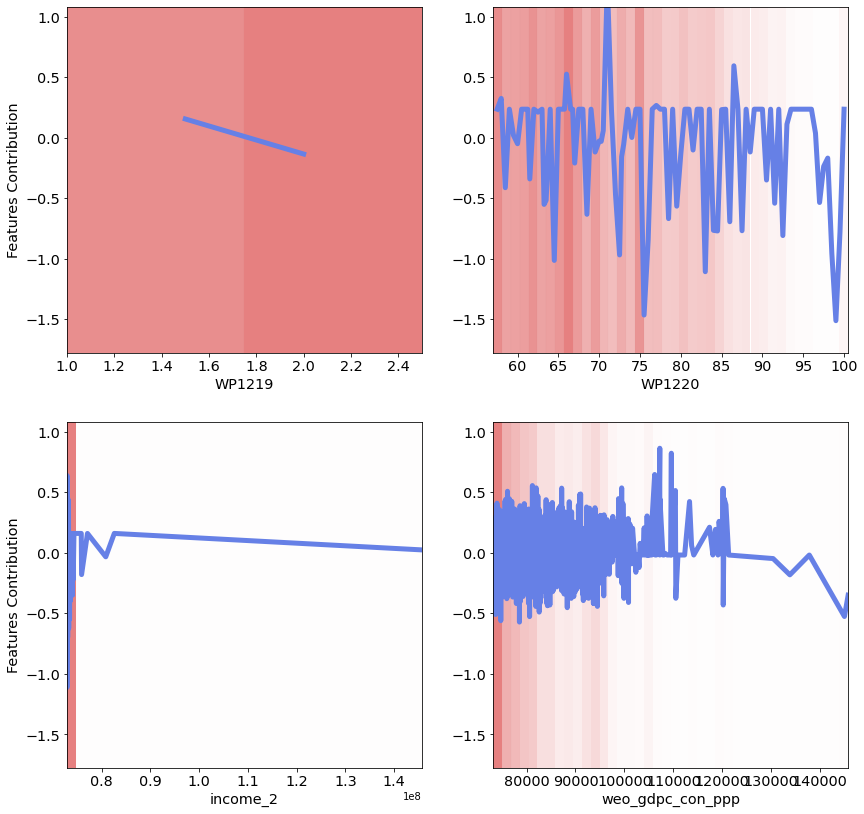

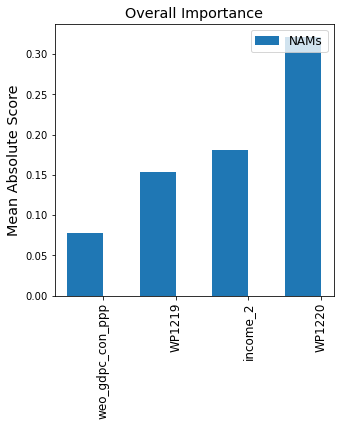

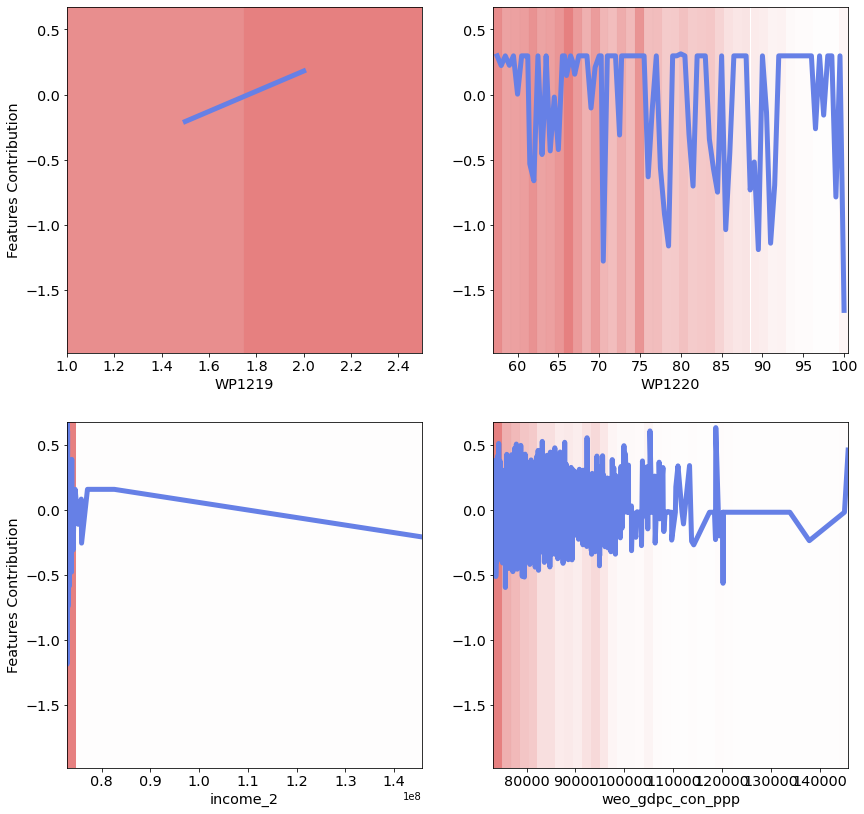

Logs/LossTrainEpoch,0.71152
_runtime,25
_timestamp,1619016264
_step,12
Logs/AccuracyTrainEpoch,0.6419
Logs/LossValEpoch,0.68374
Logs/AccuracyValEpoch,0.65795
Logs/LossTestEpoch,0.68403
Logs/AccuracyTestEpoch,0.65297


Logs/LossTrainEpoch,█▁
_runtime,▁▁▁▁▅▅▅▅▅▅▆▆█
_timestamp,▁▁▁▁▅▅▅▅▅▅▆▆█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█
Logs/AccuracyTrainEpoch,▁█
Logs/LossValEpoch,█▁
Logs/AccuracyValEpoch,▁█
Logs/LossTestEpoch,▁█
Logs/AccuracyTestEpoch,▁█


wandb: Agent Starting Run: 1ej33ntd with config:
wandb: 	activation: exu
wandb: 	batch_size: 4096
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	hidden_sizes: [64, 32]
wandb: 	lr: 0.0995381688099792
wandb: 	num_basis_functions: 480
wandb: 	num_units: 121
wandb: 	output_regularization: 0
wandb: 	units_multiplier: 8
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

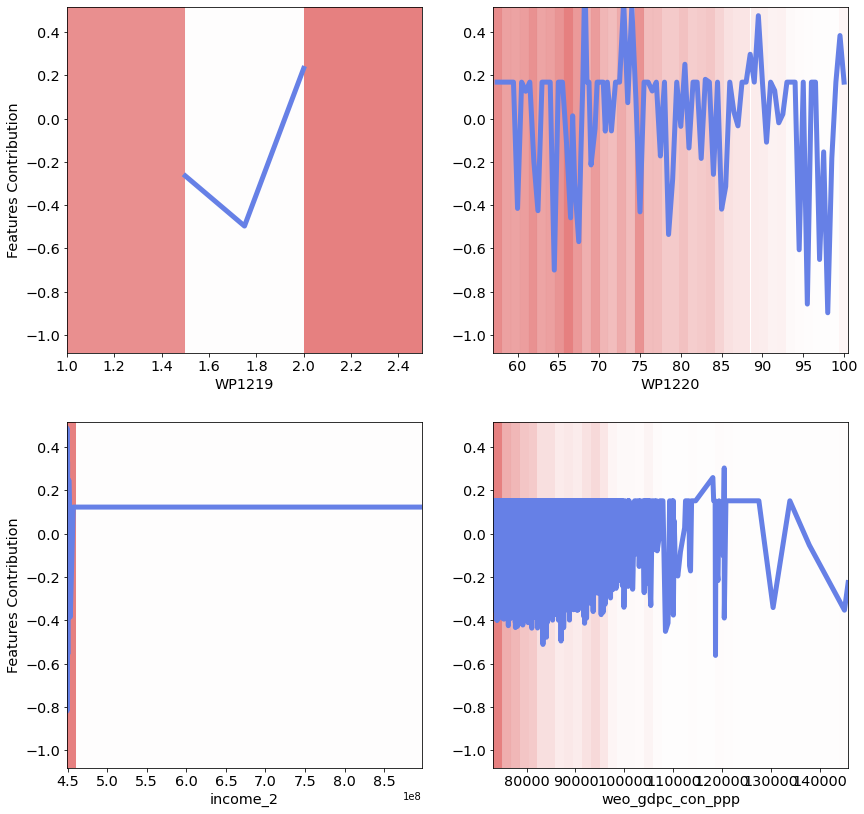

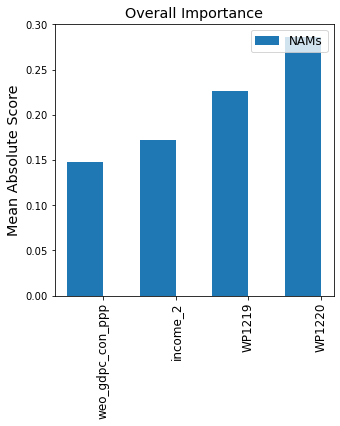

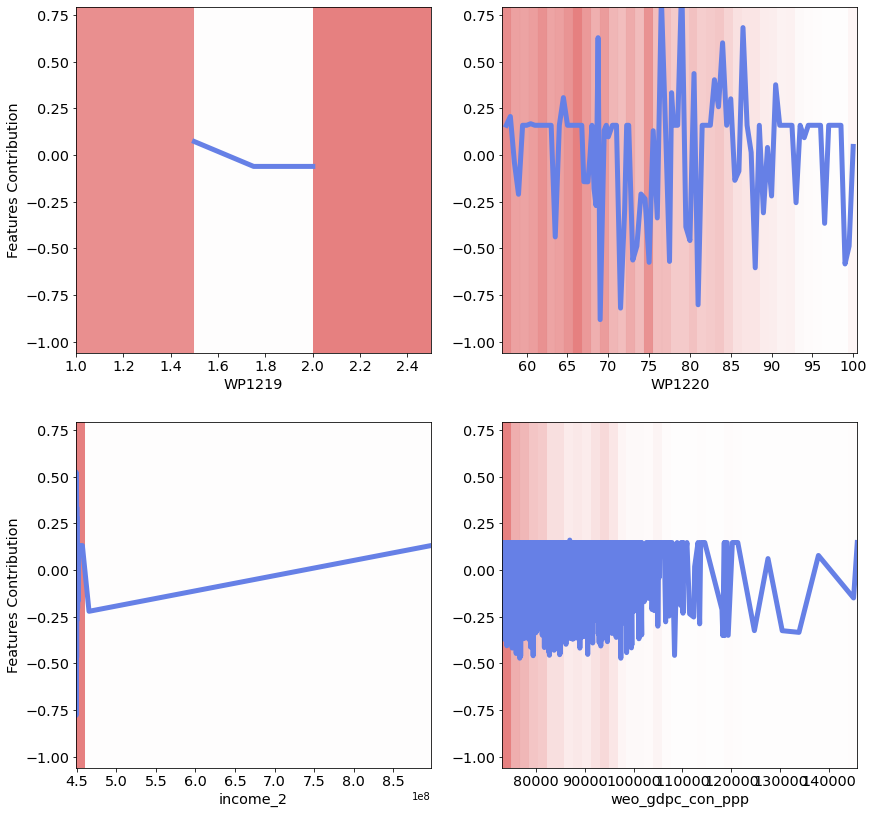

wandb: Ctrl + C detected. Stopping sweep.


In [5]:
wandb.agent(sweep_id, function=run)

In [2]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


In [3]:
wandb.init(project="NAMs", config=vars(config))

wandb: Currently logged in as: amrmkayid (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
dataset = load_sklearn_housing_data(config)
dataset

NAMDatasetSample(features=tensor([-0.6427, -0.6078, -0.9409, -0.9593, -0.8450, -0.9949,  0.1668, -0.3884]), targets=3.552000045776367)

In [6]:
model = NAM(
  config=config,
  name="NAM_Housing",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [7]:
wandb.watch(model)

In [10]:
trainer = Trainer(config, model, dataset)
trainer.train()
trainer.test()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

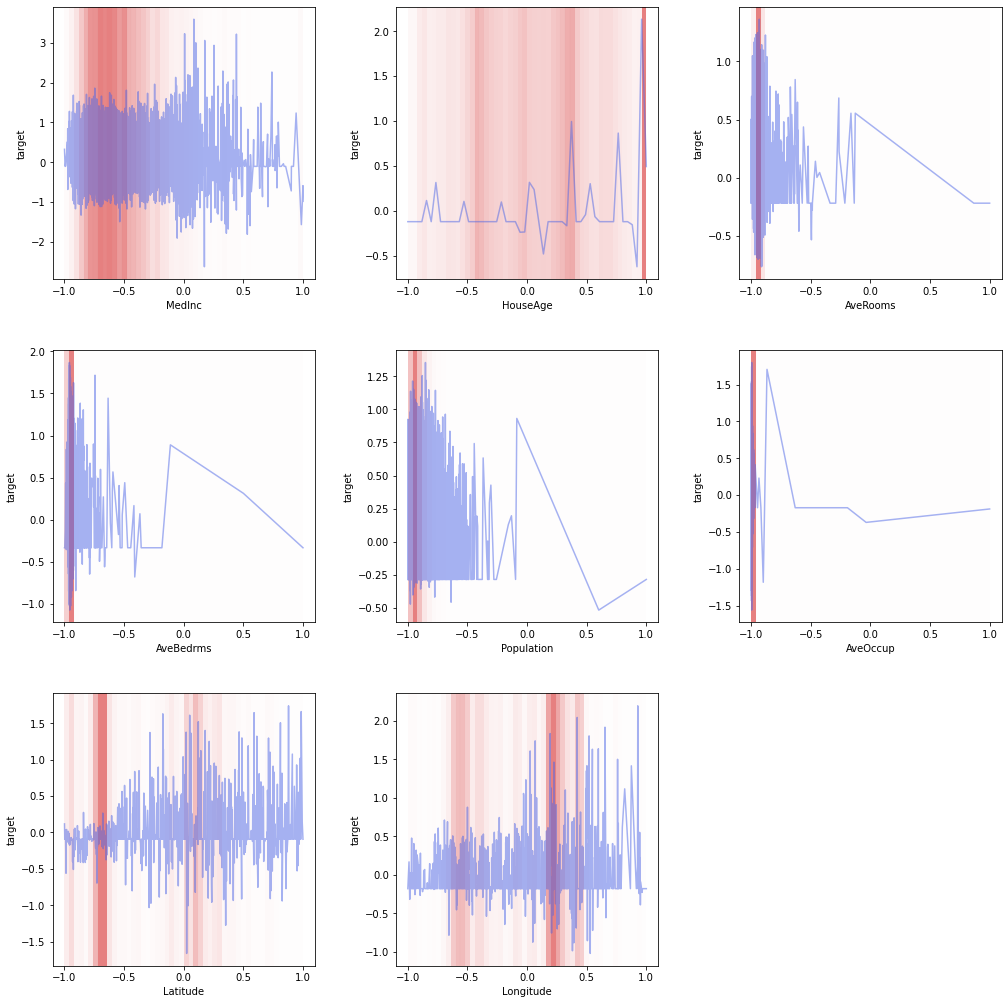

In [11]:
fig = nam_plot(dataset, [model])

In [12]:
wandb.log({"plots": wandb.Image(fig)})

## Imports

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston

import pytorch_lightning as pl

from nam.data import *
from nam.config import *
from nam.models import NAM, DNN, get_num_units
from nam.trainer import *
from nam.utils.graphing import *

## Configuration 

In [3]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


In [7]:
config.activation = "relu"
config.hidden_sizes=[]
config.batch_size = 2048
config.lr = 0.1
# config.feature_dropout = 0.5
# config.l2_regularization = 0.5
# config.decay_rate = 0.999
# config.output_regularization = 0.5

In [8]:
# config.training_epochs = 10

In [9]:
dataset = load_sklearn_housing_data(config)
# dataset = load_housing_data(config)

In [10]:
# dataset = load_gallup_data(config, 
#                            features_columns= ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
#                           weights_column=None)

In [11]:
dataset.__dict__

{'_config': namespace(device='cpu',
           output_dir='output',
           training_epochs=3,
           lr=0.1,
           batch_size=2048,
           hidden_sizes=[],
           activation='relu',
           optimizer='adam',
           dropout=0.5,
           feature_dropout=0.0,
           decay_rate=0.995,
           l2_regularization=0.0,
           output_regularization=0.0,
           num_basis_functions=64,
           units_multiplier=2,
           num_units=64,
           data_split=1,
           seed=1377,
           cross_val=False,
           n_models=1,
           num_splits=3,
           fold_num=1,
           shuffle=True,
           regression=True,
           debug=False,
           use_dnn=False,
           patience=10,
           n_folds=5,
           num_workers=16,
           test_split=0.2),
 'features': tensor([[ 0.0793,  0.5686, -0.9130,  ..., -0.9970,  0.1350, -0.5777],
         [ 0.0761, -0.2157, -0.9236,  ..., -0.9977,  0.1307, -0.5757],
         [-0.067

In [12]:
# models = [NAM(
#   config=config,
#   name="NAMModel_GALLUP",
#   num_inputs=len(dataset[0][0]),
#   num_units=get_num_units(config, dataset.features),
# ) for _ in range(1)]
model = NAM(
  config=config,
  name="NAMModel_GALLUP",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
# model

In [13]:
config.training_epochs = 25

In [14]:
# for model in models:
#     trainer = Trainer(config, model, dataset)
#     trainer.train()
#     trainer.test()
trainer = Trainer(config, model, dataset)
trainer.train()
trainer.test()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2021-04-13 21:15:28,255	WARNING session.py:32 -- Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
2021-04-13 21:15:28,256	WARNING session.py:33 --   File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 14

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

2021-04-13 21:15:43,565	WARNING session.py:32 -- Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
2021-04-13 21:15:43,566	WARNING session.py:33 --   File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 14

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

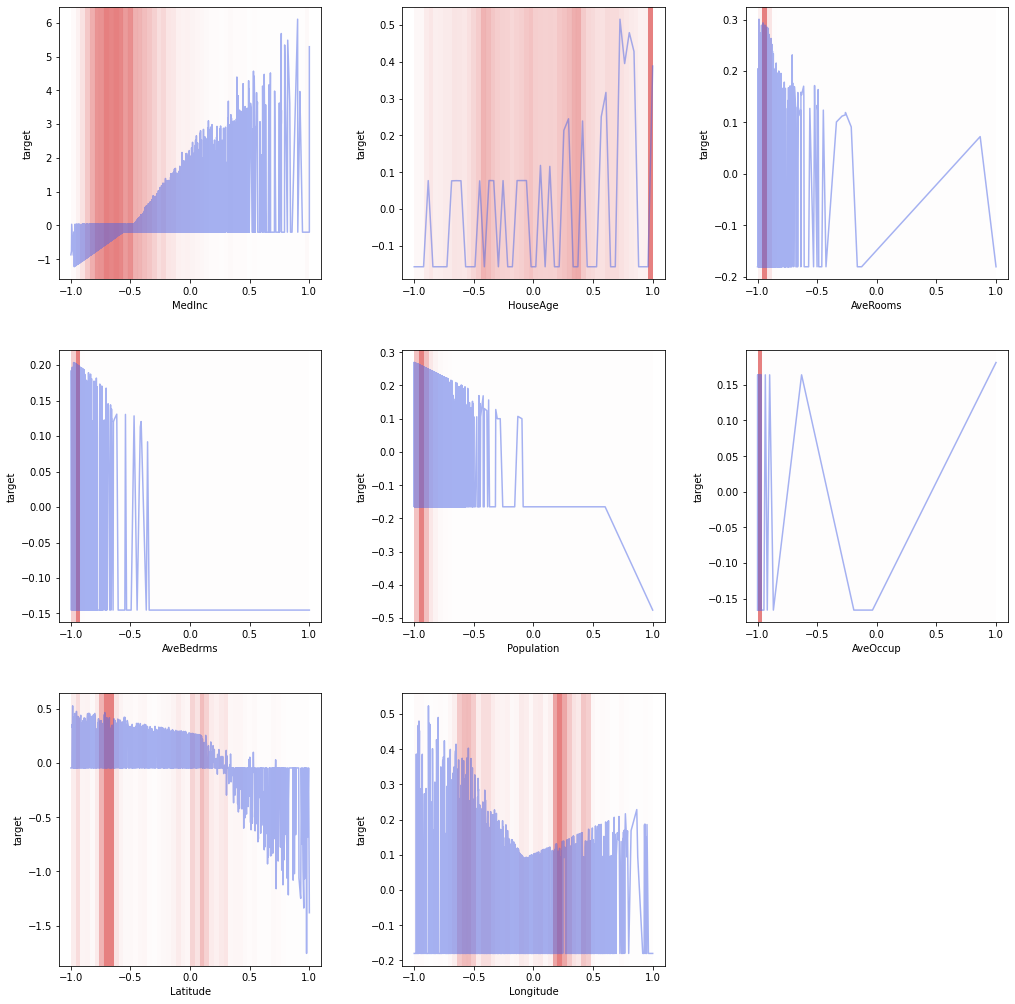

In [15]:
nam_plot(dataset, [model])

In [16]:
def get_feature_predictions(model: torch.nn.Module,
                              unique_features: torch.Tensor) -> Sequence[torch.Tensor]:
    feature_contributions = []
    for i, feature in enumerate(unique_features):
        feature_contributions.append(model.feature_nns[i](torch.tensor(feature).float()).detach().numpy().squeeze())

    return feature_contributions

In [17]:
get_feature_predictions(model, dataset.unique_features)[1]

array([0.23319559, 0.        , 0.23419961, 0.23386979, 0.23422588,
       0.        , 0.        , 0.23316786, 0.23427068, 0.        ,
       0.23447366, 0.        , 0.        , 0.23393072, 0.23390679,
       0.        , 0.23417193, 0.23388694, 0.23447369, 0.        ,
       0.        , 0.2343116 , 0.        , 0.        , 0.        ,
       0.        , 0.24918462, 0.        , 0.31071514, 0.        ,
       0.        , 0.30924767, 0.2982634 , 0.        , 0.4016922 ,
       0.38313174, 0.39816225, 0.        , 0.        , 0.49535602,
       0.4685666 , 0.56485295, 0.        , 0.66615355, 0.6101827 ,
       0.417747  , 0.        , 0.        , 0.8351132 , 0.        ,
       0.7745048 , 0.7300981 ], dtype=float32)

In [18]:
feature_predictions = get_feature_predictions(model, dataset.unique_features)

In [19]:
avg_hist_data = {col: predictions for col, predictions in zip(dataset.features_names, feature_predictions)}

In [20]:
avg_hist_data

{'MedInc': array([-0.19069621, -0.70518965, -0.        , ...,  0.        ,
         5.7732882 ,  0.        ], dtype=float32),
 'HouseAge': array([0.23417595, 0.        , 0.        , 0.23395197, 0.        ,
        0.23278548, 0.23372711, 0.        , 0.23360199, 0.23447366,
        0.23338172, 0.23375434, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.23410289,
        0.        , 0.        , 0.23428349, 0.23429286, 0.        ,
        0.        , 0.2451918 , 0.        , 0.        , 0.29625624,
        0.        , 0.        , 0.35814488, 0.39113742, 0.        ,
        0.        , 0.41050738, 0.        , 0.        , 0.5635654 ,
        0.38340664, 0.        , 0.5338739 , 0.        , 0.        ,
        0.        , 0.6224379 , 0.        , 0.7066301 , 0.        ,
        0.        , 0.7859268 ], dtype=float32),
 'AveRooms': array([0.        , 0.        , 0.4121527 , ..., 0.27473482, 0.        ,
        0.60787094], dtype=float32),
 'AveBedrms

In [21]:
#@title Individual arrays for each Dataset feature

NUM_FEATURES = dataset.features.shape[-1]
# SINGLE_FEATURES = np.split(data_x, NUM_FEATURES, axis=1)
UNIQUE_FEATURES = dataset.unique_features #[np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = dataset.sfo
UNIQUE_FEATURES_ORIGINAL = dataset.ufo

column_names = dataset.features_names

In [22]:
data_x = dataset.features
dataset_name = 'Housing'

In [23]:
#@title Calculate the mean prediction

ALL_INDICES = {}
MEAN_PRED = {}

for i, col in enumerate(column_names):
  x_i = dataset.features[:, i]
  ALL_INDICES[col] = np.searchsorted(UNIQUE_FEATURES[i][:, 0], x_i, 'left')
for col in column_names:
  MEAN_PRED[col] =  np.mean([avg_hist_data[col][i] for i in ALL_INDICES[col]])

print(MEAN_PRED)

{'MedInc': 0.14404124, 'HouseAge': 0.16166826, 'AveRooms': 0.17927785, 'AveBedrms': 0.14796433, 'Population': 0.1704935, 'AveOccup': 0.16526364, 'Latitude': 0.14369032, 'Longitude': 0.17103554}


In [24]:
#@title Helpers for MEAN feature importance

def compute_mean_feature_importance(avg_hist_data):
  mean_abs_score = {}
  for k in avg_hist_data:
        try:
            mean_abs_score[k] = np.mean(np.abs(avg_hist_data[k] - MEAN_PRED[k]))
        except: continue
  x1, x2 = zip(*mean_abs_score.items())
  return x1, x2

def plot_mean_feature_importance(x1, x2, width = 0.3):
  fig = plt.figure(figsize=(5, 4))
  ind = np.arange(len(x1))  # the x locations for the groups
  x1_indices = np.argsort(x2)
  cols_here = [cols[i] for i in x1_indices]
  # x1_here = [x12[i] for i in x1_indices]
  x2_here = [x2[i] for i in x1_indices]

  plt.bar(ind, x2_here, width, label='NAMs')
  # plt.bar(ind+width, x1_here, width, label='EBMs')
  plt.xticks(ind + width/2, cols_here, rotation=90, fontsize='large')
  plt.ylabel('Mean Absolute Score', fontsize='x-large')
  plt.legend(loc='upper right', fontsize='large')
  plt.title(f'Overall Importance: Housing', fontsize='x-large')
  plt.show()
  return fig

In [25]:
COL_NAMES = {}
COL_NAMES['Housing'] = {
    'MedInc': 'Median Income',
    'HouseAge': 'Median House Age',
    'AveRooms': '# Avg Rooms',
    'AveBedrms': '# Avg Bedrooms',
    'Population': 'Block Population',
    'AveOccup': '# Avg Occupancy',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude'
  }

In [26]:
x1, x2 = compute_mean_feature_importance(avg_hist_data)

In [27]:
x1, x2

(('MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'),
 (0.32222724,
  0.17621067,
  0.18093707,
  0.14578865,
  0.16915114,
  0.16499253,
  0.24707079,
  0.1852857))

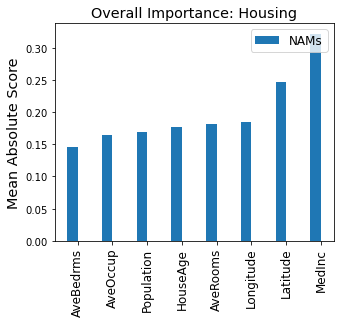

In [28]:
cols = column_names #[COL_NAMES["Housing"][x] for x in x1]
fig = plot_mean_feature_importance(x1, x2)

In [29]:
#@title Plotting Helper Functions

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches

def shade_by_density_blocks(hist_data, num_rows, num_cols, 
                            n_blocks=5, color=[0.9, 0.5, 0.5], 
                            feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
  max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 

  for i, (name, pred) in enumerate(hist_data_pairs):

    # unique_x_data, single_feature_data, pred = data
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
    ax = plt.subplot(num_rows, num_cols, i+1)
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    x_n_blocks = min(n_blocks, len(unique_x_data))
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    segments = (max_x - min_x) / x_n_blocks
    density = np.histogram(single_feature_data, bins=x_n_blocks)
    normed_density = density[0] / np.max(density[0])
    rect_params = []
    for p in range(x_n_blocks):
      start_x = min_x + segments * p
      end_x = min_x + segments * (p + 1)
      # start_insert_index = min(
      #     max(0, np.searchsorted(density[1], start_x) - 1), x_n_blocks - 1)
      # end_insert_index = min(
      #     max(0, np.searchsorted(density[1], end_x) - 1), x_n_blocks - 1)
      # d = (normed_density[start_insert_index] + normed_density[end_insert_index])/2
      d = min(1.0, 0.01 + normed_density[p])
      rect_params.append((d, start_x, end_x))

    for param in rect_params:
      alpha, start_x, end_x = param 
      rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x, 
                               max_y - min_y + 1, linewidth=0.01, 
                              edgecolor=color, facecolor=color, alpha=alpha)
      ax.add_patch(rect)


def plot_all_hist(hist_data, num_rows, num_cols,  color_base, 
                  linewidth=3.0, min_y=None, max_y=None, alpha=1.0, 
                  feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  if min_y is None:
    min_y = np.min([np.min(a) for _, a in hist_data_pairs])
  if max_y is None:
    max_y = np.max([np.max(a) for _, a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif
  col_mapping = column_names #COL_NAMES[dataset_name]
  feature_mapping = FEATURE_LABEL_MAPPING[dataset_name] 

  total_mean_bias = 0

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 
  
  for i, (name, pred) in enumerate(hist_data_pairs):
    mean_pred = MEAN_PRED[name] #np.mean(pred)
    total_mean_bias += mean_pred
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    plt.subplot(num_rows, num_cols, i+1)

    if name in CATEGORICAL_NAMES:
      unique_x_data = np.round(unique_x_data, decimals=1)
      if len(unique_x_data) <= 2:
        step_loc = "mid"
      else:
        step_loc = "post"
      unique_plot_data = np.array(unique_x_data) - 0.5
      unique_plot_data[-1] += 1
      plt.step(unique_plot_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, where=step_loc, alpha=alpha)

      if name in feature_mapping:
        labels, rot = feature_mapping[name]
      else:
        labels = unique_x_data
        rot = None
      plt.xticks(unique_x_data, labels=labels, fontsize='x-large', rotation=rot)
    else:
      plt.plot(unique_x_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, alpha=alpha)
      plt.xticks(fontsize='x-large')
  
   
    plt.ylim(min_y, max_y)
    plt.yticks(fontsize='x-large')
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    plt.xlim(min_x, max_x)
    if i % num_cols == 0:
      plt.ylabel('House Price Contribution', fontsize='x-large')
#     plt.xlabel(col_mapping[name], fontsize='x-large')
      plt.xlabel(name, fontsize='x-large')
  return min_y, max_y

In [30]:
CATEGORICAL_NAMES ={}
FEATURE_LABEL_MAPPING ={}
FEATURE_LABEL_MAPPING['Housing'] = {}

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


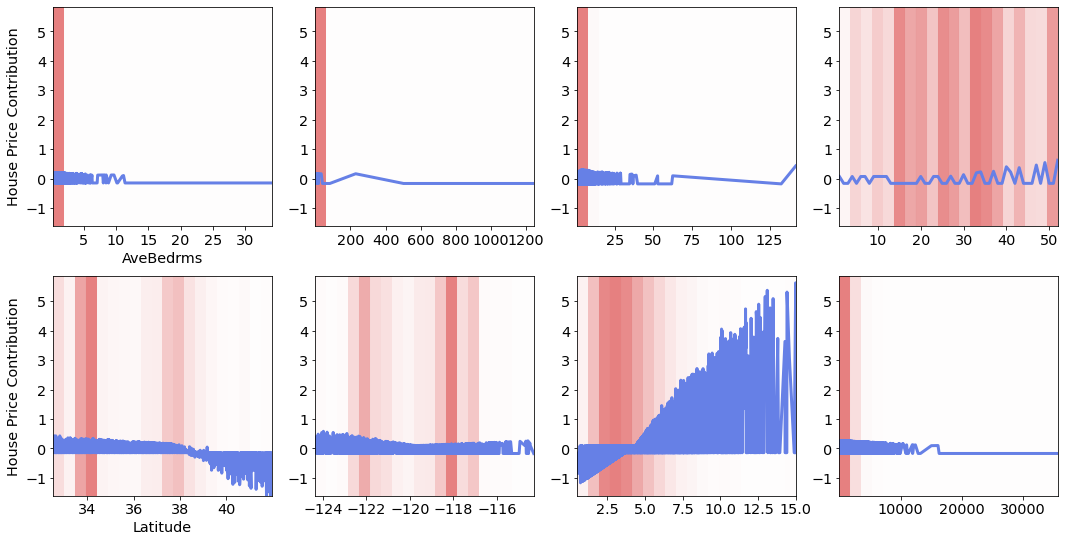

In [31]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS =  4#@param {'type': 'integer'}
N_BLOCKS =  20#@param 

MIN_Y = None
MAX_Y = None


NUM_ROWS = int(np.ceil(NUM_FEATURES / NUM_COLS))
fig = plt.figure(num=None, figsize=(NUM_COLS * 4.5, NUM_ROWS * 4.5),
                 facecolor='w', edgecolor='k')

MIN_Y, MAX_Y = plot_all_hist(avg_hist_data, NUM_ROWS, NUM_COLS, COLORS[2],
                             min_y=MIN_Y, max_y=MAX_Y, feature_to_use=column_names)
shade_by_density_blocks(avg_hist_data, NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=column_names)

# This is for plotting individual plots when there are multiple models
"""
for pred in feature_predictions:
  model_hist = {col: pred[0, i] for i, col in enumerate(column_names)}
  plot_all_hist(model_hist, NUM_ROWS, NUM_COLS,
                color_base=[0.3, 0.4, 0.9, 0.2], alpha=0.06,
                linewidth=0.1, min_y=MIN_Y, max_y=MAX_Y, feature_to_use=features)
"""
plt.subplots_adjust(hspace=0.23)
plt.show()

# Ray

In [1]:
from ray import tune

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer

import pytorch_lightning as pl

from nam.data import *
from nam.config import *
from nam.models import NAM, DNN, get_num_units
from nam.trainer import Trainer
from nam.utils.graphing import *

In [2]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


In [3]:
def tune_trainer(cfg):
    config.update(**cfg)
    print(config)
    dataset = load_sklearn_housing_data(config)
    
    model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
    )
    
    trainer = Trainer(config, model, dataset)
    trainer.train()
    trainer.test()
    
    nam_plot(dataset, [model])

In [4]:
analysis = tune.run(
    tune_trainer,
    config={
        "activation": tune.choice(["exu", "relu"]),
        "batch_size": tune.grid_search([512, 1024, 2048]),
#         "decay_rate": tune.grid_search([0.0, 0.9, 0.995]),
        "dropout": tune.grid_search([0.0, 0.5, 0.95]),
#         "feature_dropout": tune.grid_search([0.0, 0.5, 0.95]),
#         "l2_regularization": tune.grid_search([0.0, 0.5, 0.95]),
#         "output_regularization": tune.grid_search([0.0, 0.5, 0.95]),
        "lr": tune.grid_search([0.1, 0.01, 1e-3, 3e-4]),
        "hidden_sizes": tune.choice([[], [32], [64, 32, 32]])
    }
)

2021-04-13 21:10:13,235	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-13 21:10:14,989	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr
tune_trainer_e0bef_00000,RUNNING,,exu,512,0,[32],0.1


(pid=46673) Config(activation='relu', batch_size=512, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32, 32], l2_regularization=0.0, lr=0.1, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)
(pid=46669) Config(activation='exu', batch_size=512, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.0, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.1, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multip

(pid=46669) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=46669)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=46672) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=46672)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=46671) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=46671)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=46666) /Users/amr

(pid=46664) Config(activation='exu', batch_size=2048, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


  0%|          | 0/15 [00:00<?, ?it/s]
(pid=46664) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=46664)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=46669) 
TL Step: 4.335 | MAE: 1.665:   0%|          | 0/30 [00:02<?, ?it/s]
TL Step: 4.335 | MAE: 1.665:   3%|▎         | 1/30 [00:02<01:15,  2.59s/it]
(pid=46673) 
TL Step: 15.694 | MAE: 3.312:   0%|          | 0/30 [00:02<?, ?it/s]
TL Step: 15.694 | MAE: 3.312:   3%|▎         | 1/30 [00:02<01:24,  2.93s/it]
(pid=46667) 
TL Step: 3.551 | MAE: 1.465:   0%|          | 0/8 [00:02<?, ?it/s]
TL Step: 3.551 | MAE: 1.465:  12%|█▎        | 1/8 [00:02<00:20,  2.96s/it]
(pid=46669) 
TL Step: 1639.351 | MAE: 40.215:   3%|▎         | 1/30 [00:03<01:15,  2.59s/it]
TL Step: 1639.351 | MAE: 40.215:   7%|▋         | 2/30 [00:03<00:37,  1.

Result for tune_trainer_e0bef_00002:
  date: 2021-04-13_21-10-24
  done: false
  experiment_id: 0f41361403fd495189be9a1452c2564b
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 2.7947285175323486
  metrics_train: 1.2858335301280022
  node_ip: 192.168.1.12
  pid: 46674
  time_since_restore: 4.60654616355896
  time_this_iter_s: 4.60654616355896
  time_total_s: 4.60654616355896
  timestamp: 1618341024
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00002
  


(pid=46667) 
TL Step: 7.074 | MAE: 2.350:  50%|█████     | 4/8 [00:04<00:02,  1.49it/s] 
TL Step: 7.074 | MAE: 2.350:  62%|██████▎   | 5/8 [00:04<00:01,  1.91it/s]
(pid=46673) 
TL Step: 29.172 | MAE: 4.037:  10%|█         | 3/30 [00:04<00:27,  1.03s/it]
TL Step: 29.172 | MAE: 4.037:  17%|█▋        | 5/30 [00:04<00:13,  1.81it/s]
(pid=46674) 
TL Step: 1.558 | MAE: 0.909:  62%|██████▎   | 5/8 [00:04<00:01,  2.25it/s]
TL Step: 1.558 | MAE: 0.909:  75%|███████▌  | 6/8 [00:04<00:00,  2.58it/s]
TL Step: 1.148 | MAE: 0.818:  75%|███████▌  | 6/8 [00:04<00:00,  2.58it/s]
(pid=46666) 
TL Step: 2.739 | MAE: 1.490:   3%|▎         | 1/30 [00:04<01:49,  3.78s/it] 
TL Step: 2.739 | MAE: 1.490:  10%|█         | 3/30 [00:04<00:29,  1.11s/it]
(pid=46663) 
TL Step: 2.834 | MAE: 1.286:  17%|█▋        | 5/30 [00:04<00:11,  2.19it/s]
(pid=46665) 
TL Step: 196.283 | MAE: 4.356:  13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]
TL Step: 6.546 | MAE: 2.277:   0%|          | 0/8 [00:03<?, ?it/s]
TL Step: 6.546 | M

Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train
tune_trainer_e0bef_00000,RUNNING,,exu,512,0,[32],0.1,,,,
tune_trainer_e0bef_00001,RUNNING,,exu,1024,0,"[64, 32, 32]",0.1,,,,
tune_trainer_e0bef_00002,RUNNING,192.168.1.12:46674,relu,2048,0,[],0.1,1,4.60655,2.79473,1.28583
tune_trainer_e0bef_00003,RUNNING,,relu,512,0.5,"[64, 32, 32]",0.1,,,,
tune_trainer_e0bef_00004,RUNNING,,relu,1024,0.5,"[64, 32, 32]",0.1,,,,
tune_trainer_e0bef_00005,RUNNING,,relu,2048,0.5,[32],0.1,,,,
tune_trainer_e0bef_00006,RUNNING,,exu,512,0.95,[],0.1,,,,
tune_trainer_e0bef_00007,RUNNING,,exu,1024,0.95,[],0.1,,,,
tune_trainer_e0bef_00008,RUNNING,,relu,2048,0.95,[32],0.1,,,,
tune_trainer_e0bef_00009,RUNNING,,exu,512,0,[32],0.01,,,,


(pid=46669) 
TL Step: 8.116 | MAE: 2.522:  37%|███▋      | 11/30 [00:04<00:02,  6.73it/s]
(pid=46667) 
TL Step: 4.617 | MAE: 1.668:  62%|██████▎   | 5/8 [00:04<00:01,  1.91it/s]
TL Step: 4.617 | MAE: 1.668:  75%|███████▌  | 6/8 [00:04<00:00,  2.58it/s]
(pid=46673) 
TL Step: 31.268 | MAE: 4.460:  17%|█▋        | 5/30 [00:04<00:13,  1.81it/s]
TL Step: 31.268 | MAE: 4.460:  20%|██        | 6/30 [00:04<00:10,  2.33it/s]
(pid=46674) 
  0%|          | 0/1 [00:00<?, ?it/s]
(pid=46671) 
TL Step: 181.530 | MAE: 4.009:  20%|██        | 6/30 [00:04<00:10,  2.26it/s]
TL Step: 209.592 | MAE: 3.671:  20%|██        | 6/30 [00:04<00:10,  2.26it/s]
(pid=46666) 
TL Step: 9.756 | MAE: 2.858:  13%|█▎        | 4/30 [00:04<00:19,  1.31it/s]
(pid=46661) 
TL Step: 2.223 | MAE: 1.166:  27%|██▋       | 4/15 [00:04<00:07,  1.46it/s]
(pid=46663) 
TL Step: 2.855 | MAE: 1.296:  23%|██▎       | 7/30 [00:04<00:06,  3.80it/s]
(pid=46665) 
TL Step: 250.869 | MAE: 4.514:  27%|██▋       | 4/15 [00:04<00:07,  1.49it/s]
(p

(pid=46669) 
TL Step: 1.531 | MAE: 0.906:  57%|█████▋    | 17/30 [00:04<00:00, 13.21it/s]
TL Step: 1.531 | MAE: 0.906:  63%|██████▎   | 19/30 [00:04<00:00, 14.08it/s]
TL Step: 2.092 | MAE: 1.068:  63%|██████▎   | 19/30 [00:04<00:00, 14.08it/s]
TL Step: 3.324 | MAE: 1.450: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
(pid=46667) 
  0%|          | 0/1 [00:00<?, ?it/s]
(pid=46673) 
TL Step: 11.172 | MAE: 2.709:  27%|██▋       | 8/30 [00:04<00:05,  3.77it/s]
TL Step: 11.172 | MAE: 2.709:  33%|███▎      | 10/30 [00:04<00:03,  5.22it/s]
(pid=46672) 
TL Step: 8.014 | MAE: 2.298:  40%|████      | 6/15 [00:04<00:03,  2.75it/s] 
(pid=46674) 
VL Step: 1.206 | MAE: 0.902:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 1.206 | MAE: 0.902: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
(pid=46668) 
TL Step: 58.672 | MAE: 6.210:  27%|██▋       | 4/15 [00:04<00:08,  1.26it/s]
(pid=46671) 
TL Step: 62.120 | MAE: 2.388:  43%|████▎     | 13/30 [00:04<00:02,  7.56it/s]
TL Step: 62.120 | MAE: 2.388:  53%|█

Result for tune_trainer_e0bef_00005:
  date: 2021-04-13_21-10-24
  done: false
  experiment_id: 056e513949564e1fb905e55ba0c952ef
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 279.5399169921875
  metrics_train: 7.181010976433754
  node_ip: 192.168.1.12
  pid: 46667
  time_since_restore: 4.931343078613281
  time_this_iter_s: 4.931343078613281
  time_total_s: 4.931343078613281
  timestamp: 1618341024
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00005
  
Result for tune_trainer_e0bef_00011:
  date: 2021-04-13_21-10-24
  done: false
  experiment_id: 2fa256f5313946adbf8fc962a68b21dc
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 2.771907091140747
  metrics_train: 1.2991710528731346
  node_ip: 192.168.1.12
  pid: 46662
  time_since_restore: 4.829423904418945
  time_this_iter_s: 4.829423904418945
  time_total_s: 4.829423904418945
  timestamp: 1618341024
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_0001


TL Step: 6.273 | MAE: 2.000:  50%|█████     | 15/30 [00:04<00:01, 10.65it/s] 
(pid=46669) 
TL Step: 1.391 | MAE: 0.988:  70%|███████   | 21/30 [00:04<00:00, 14.99it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=46671) 
(pid=46669) 
TL Step: 1.341 | MAE: 0.964:  70%|███████   | 21/30 [00:04<00:00, 14.99it/s]
(pid=46673) 
TL Step: 7.553 | MAE: 2.216:  33%|███▎      | 10/30 [00:04<00:03,  5.22it/s] 
TL Step: 7.553 | MAE: 2.216:  40%|████      | 12/30 [00:04<00:02,  6.46it/s]
(pid=46668) 
TL Step: 16.905 | MAE: 3.109:  27%|██▋       | 4/15 [00:04<00:08,  1.26it/s]
TL Step: 16.905 | MAE: 3.109:  40%|████      | 6/15 [00:04<00:04,  2.13it/s]
(pid=46671) 
TL Step: 4.899 | MAE: 1.427:  63%|██████▎   | 19/30 [00:04<00:00, 12.50it/s]
(pid=46666) 
TL Step: 1.973 | MAE: 1.223:  43%|████▎     | 13/30 [00:04<00:02,  6.89it/s]
(pid=46670) 
TL Step: 25.795 | MAE: 2.258:  38%|███▊      | 3/8 [00:04<00:05,  1.06s/it]
TL Step: 25.795 | MAE: 2.258:  62%|██████▎   | 5/8 [00:04<00:01,  1.93it/s]
(pid=46661

Result for tune_trainer_e0bef_00007:
  date: 2021-04-13_21-10-24
  done: false
  experiment_id: f273bdb577c0496497f0935c9e28a5a3
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 136.21482849121094
  metrics_train: 3.329923963546753
  node_ip: 192.168.1.12
  pid: 46665
  time_since_restore: 5.1575539112091064
  time_this_iter_s: 5.1575539112091064
  time_total_s: 5.1575539112091064
  timestamp: 1618341024
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00007
  


(pid=46672) 
TL Step: 37.045 | MAE: 5.616:  60%|██████    | 9/15 [00:05<00:01,  4.80it/s]
TL Step: 37.045 | MAE: 5.616:  73%|███████▎  | 11/15 [00:05<00:00,  5.70it/s]
(pid=46666) 
TL Step: 1.698 | MAE: 0.931:  60%|██████    | 18/30 [00:05<00:01, 11.15it/s]
TL Step: 1.698 | MAE: 0.931:  67%|██████▋   | 20/30 [00:05<00:00, 12.10it/s]
(pid=46670) 
TL Step: 38.391 | MAE: 2.672:  88%|████████▊ | 7/8 [00:05<00:00,  3.09it/s]
VL Step: 1.775 | MAE: 1.012: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]
Epoch(0): TL: 3.072 | VL: 1.863 | Metrics: 1.387:  33%|███▎      | 1/3 [00:05<00:10,  5.07s/it]
(pid=46663) 
TL Step: 1.854 | MAE: 1.023:  70%|███████   | 21/30 [00:05<00:00, 13.85it/s]
(pid=46664) 
TL Step: 6.050 | MAE: 2.002:  50%|█████     | 4/8 [00:02<00:01,  2.00it/s]
TL Step: 6.050 | MAE: 2.002:  62%|██████▎   | 5/8 [00:02<00:01,  2.53it/s]
(pid=46669) 
TL Step: 1.127 | MAE: 0.811:  87%|████████▋ | 26/30 [00:05<00:00, 15.84it/s]
TL Step: 1.127 | MAE: 0.811:  93%|█████████▎| 28/30 [00:05<00:

Result for tune_trainer_e0bef_00008:
  date: 2021-04-13_21-10-25
  done: false
  experiment_id: 8f9cb4910f1b4546869fcf48c9858347
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 443.23126220703125
  metrics_train: 4.856981337070465
  node_ip: 192.168.1.12
  pid: 46670
  time_since_restore: 5.4117820262908936
  time_this_iter_s: 5.4117820262908936
  time_total_s: 5.4117820262908936
  timestamp: 1618341025
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00008
  
Result for tune_trainer_e0bef_00006:
  date: 2021-04-13_21-10-25
  done: false
  experiment_id: 4c2f52fdac794adc9bcc6cc86fef2393
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 105.83308410644531
  metrics_train: 2.7218952258427938
  node_ip: 192.168.1.12
  pid: 46671
  time_since_restore: 5.5986950397491455
  time_this_iter_s: 5.5986950397491455
  time_total_s: 5.5986950397491455
  timestamp: 1618341025
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0

(pid=46660) 
TL Step: 4.280 | MAE: 1.694:  77%|███████▋  | 23/30 [00:05<00:00, 13.72it/s]
TL Step: 0.503 | MAE: 0.606: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
(pid=46674) 
TL Step: 0.924 | MAE: 0.713:  38%|███▊      | 3/8 [00:00<00:00,  6.40it/s]
(pid=46668) 
TL Step: 17.916 | MAE: 3.522:  53%|█████▎    | 8/15 [00:05<00:02,  2.94it/s]
TL Step: 17.916 | MAE: 3.522:  60%|██████    | 9/15 [00:05<00:01,  3.35it/s]
(pid=46671) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=46666) 
TL Step: 1.164 | MAE: 0.784:  73%|███████▎  | 22/30 [00:05<00:00, 11.65it/s]
(pid=46663) 
TL Step: 1.861 | MAE: 1.060:  77%|███████▋  | 23/30 [00:05<00:00, 14.15it/s]
TL Step: 1.861 | MAE: 1.060:  83%|████████▎ | 25/30 [00:05<00:00, 13.24it/s]
VL Step: 5.866 | MAE: 1.527: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]
Epoch(0): TL: 136.215 | VL: 9.603 | Metrics: 3.330:  33%|███▎      | 1/3 [00:05<00:10,  5.18s/it]
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=46660) 
TL Step: 4.398 | MAE: 1.700:  77%|███████▋  |

Result for tune_trainer_e0bef_00000:
  date: 2021-04-13_21-10-25
  done: false
  experiment_id: c24539b769324d879982c29efe97b98d
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 59.33467483520508
  metrics_train: 2.8957818786303204
  node_ip: 192.168.1.12
  pid: 46669
  time_since_restore: 5.706405878067017
  time_this_iter_s: 5.706405878067017
  time_total_s: 5.706405878067017
  timestamp: 1618341025
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00000
  


(pid=46667) 
TL Step: 5.247 | MAE: 1.821:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 5.247 | MAE: 1.821:  12%|█▎        | 1/8 [00:00<00:03,  1.76it/s]
(pid=46673) 
TL Step: 5.490 | MAE: 1.903:  57%|█████▋    | 17/30 [00:05<00:01,  7.37it/s]
TL Step: 5.490 | MAE: 1.903:  60%|██████    | 18/30 [00:05<00:01,  7.18it/s]
(pid=46672) 
TL Step: 2.693 | MAE: 1.238:  87%|████████▋ | 13/15 [00:05<00:00,  5.92it/s]
TL Step: 2.693 | MAE: 1.238:  93%|█████████▎| 14/15 [00:05<00:00,  6.25it/s]
(pid=46674) 
TL Step: 0.762 | MAE: 0.690:  62%|██████▎   | 5/8 [00:00<00:00,  9.46it/s]
TL Step: 0.762 | MAE: 0.690:  88%|████████▊ | 7/8 [00:00<00:00, 10.55it/s]
(pid=46666) 
(pid=46670) 
VL Step: 89.571 | MAE: 3.100:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 89.571 | MAE: 3.100: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
(pid=46661) 
TL Step: 2.021 | MAE: 1.092:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 2.021 | MAE: 1.092:   7%|▋         | 1/15 [00:00<00:05,  2.34it/s]
(pid=46663) 
TL Step:

(pid=46667) 
TL Step: 11.761 | MAE: 2.722:  38%|███▊      | 3/8 [00:01<00:01,  3.37it/s]
(pid=46673) 
TL Step: 3.533 | MAE: 1.482:  70%|███████   | 21/30 [00:06<00:01,  6.90it/s]
TL Step: 1.461 | MAE: 0.936: 100%|██████████| 30/30 [00:06<00:00,  4.99it/s]
(pid=46665) 
TL Step: 9.801 | MAE: 1.605:  20%|██        | 3/15 [00:00<00:02,  5.40it/s] 
TL Step: 1.269 | MAE: 0.880: 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]
(pid=46675) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=46666) 
  0%|          | 0/4 [00:00<?, ?it/s]


Result for tune_trainer_e0bef_00014:
  date: 2021-04-13_21-10-25
  done: false
  experiment_id: bfd884608b7641dabf4f364749af4eac
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 6.135776042938232
  metrics_train: 1.8963896334171295
  node_ip: 192.168.1.12
  pid: 46664
  time_since_restore: 5.780545949935913
  time_this_iter_s: 5.780545949935913
  time_total_s: 5.780545949935913
  timestamp: 1618341025
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00014
  
Result for tune_trainer_e0bef_00010:
  date: 2021-04-13_21-10-25
  done: false
  experiment_id: 507e4e8a004847c4a7334868ebcd7ca8
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 3.6342549324035645
  metrics_train: 1.4406700412432352
  node_ip: 192.168.1.12
  pid: 46675
  time_since_restore: 6.275192022323608
  time_this_iter_s: 6.275192022323608
  time_total_s: 6.275192022323608
  timestamp: 1618341025
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00

VL Step: 0.987 | MAE: 0.728: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]
Epoch(0): TL: 59.335 | VL: 1.155 | Metrics: 2.896:  33%|███▎      | 1/3 [00:06<00:12,  6.27s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=46672) 
  0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 3.397 | MAE: 1.309: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]
Epoch(0): TL: 105.833 | VL: 5.585 | Metrics: 2.722:  33%|███▎      | 1/3 [00:06<00:12,  6.13s/it]
(pid=46661) 
TL Step: 2.001 | MAE: 1.034:  60%|██████    | 9/15 [00:00<00:00, 15.83it/s]
TL Step: 2.002 | MAE: 1.061:  60%|██████    | 9/15 [00:01<00:00, 15.83it/s]
TL Step: 2.002 | MAE: 1.061:  73%|███████▎  | 11/15 [00:01<00:00, 16.44it/s]
TL Step: 1.191 | MAE: 0.807: 100%|██████████| 30/30 [00:06<00:00,  4.95it/s]
(pid=46663) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=46665) 
TL Step: 13.555 | MAE: 1.489:  20%|██        | 3/15 [00:00<00:02,  5.40it/s]
TL Step: 13.555 | MAE: 1.489:  40%|████      | 6/15 [00:00<00:00,  9.62it/s]
TL Step: 6.241 | MAE: 2.117:

(pid=46664) 
VL Step: 2.541 | MAE: 1.258:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 2.541 | MAE: 1.258: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
(pid=46665) 
TL Step: 6.157 | MAE: 1.461:  40%|████      | 6/15 [00:01<00:00,  9.62it/s] 
VL Step: 2.541 | MAE: 1.258: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]
Epoch(0): TL: 6.136 | VL: 2.541 | Metrics: 1.896:  33%|███▎      | 1/3 [00:04<00:08,  4.14s/it]
(pid=46667) 
(pid=46668) 
TL Step: 5.493 | MAE: 1.865:  93%|█████████▎| 14/15 [00:06<00:00,  4.70it/s]
TL Step: 5.493 | MAE: 1.865: 100%|██████████| 15/15 [00:06<00:00,  5.15it/s]
(pid=46661) 
TL Step: 1.905 | MAE: 1.031:  73%|███████▎  | 11/15 [00:01<00:00, 16.44it/s]
TL Step: 1.905 | MAE: 1.031:  87%|████████▋ | 13/15 [00:01<00:00, 12.33it/s]
TL Step: 1.909 | MAE: 1.041:  87%|████████▋ | 13/15 [00:01<00:00, 12.33it/s]
TL Step: 7.741 | MAE: 2.316:  62%|██████▎   | 5/8 [00:01<00:00,  4.89it/s]
(pid=46667) 
TL Step: 7.741 | MAE: 2.316:  75%|███████▌  | 6/8 [00:01<00:00,  5.01it/

Result for tune_trainer_e0bef_00004:
  date: 2021-04-13_21-10-26
  done: false
  experiment_id: 3c086e8e4bb64be8a6ad43b2b22a04a6
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 1641.3831787109375
  metrics_train: 12.332776776949565
  node_ip: 192.168.1.12
  pid: 46668
  time_since_restore: 7.075724124908447
  time_this_iter_s: 7.075724124908447
  time_total_s: 7.075724124908447
  timestamp: 1618341026
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00004
  


(pid=46668) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=46669) 
TL Step: 1.159 | MAE: 0.834:   3%|▎         | 1/30 [00:00<00:18,  1.60it/s]
TL Step: 1.159 | MAE: 0.834:   7%|▋         | 2/30 [00:00<00:09,  3.01it/s]
TL Step: 1.099 | MAE: 0.812:   7%|▋         | 2/30 [00:00<00:09,  3.01it/s]
(pid=46673) 
TL Step: 3.022 | MAE: 1.380:  83%|████████▎ | 25/30 [00:07<00:00,  5.97it/s]
TL Step: 3.022 | MAE: 1.380:  90%|█████████ | 27/30 [00:07<00:00,  7.06it/s]
Epoch(0): TL: 371.139 | VL: 2.159 | Metrics: 10.471:  33%|███▎      | 1/3 [00:07<00:14,  7.00s/it]
(pid=46671) 
TL Step: 4.919 | MAE: 1.380:   3%|▎         | 1/30 [00:00<00:16,  1.80it/s]
TL Step: 4.919 | MAE: 1.380:  10%|█         | 3/30 [00:00<00:05,  4.83it/s]
TL Step: 3.489 | MAE: 1.269:  10%|█         | 3/30 [00:00<00:05,  4.83it/s]
(pid=46665) 
TL Step: 10.442 | MAE: 1.497:  80%|████████  | 12/15 [00:01<00:00, 10.15it/s]
TL Step: 5.271 | MAE: 1.361:  80%|████████  | 12/15 [00:01<00:00, 10.15it/s] 
TL Step: 5.271 | MAE: 1.361:  93

Result for tune_trainer_e0bef_00003:
  date: 2021-04-13_21-10-27
  done: false
  experiment_id: 07cb975fbe0b4f889df54e9809d00a8d
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 656.0241088867188
  metrics_train: 6.308100795745849
  node_ip: 192.168.1.12
  pid: 46673
  time_since_restore: 7.699234247207642
  time_this_iter_s: 7.699234247207642
  time_total_s: 7.699234247207642
  timestamp: 1618341027
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00003
  


(pid=46669) 
TL Step: 1.322 | MAE: 0.866:  23%|██▎       | 7/30 [00:01<00:02,  9.96it/s]
TL Step: 1.322 | MAE: 0.866:  30%|███       | 9/30 [00:01<00:02,  7.68it/s]
(pid=46666) 
TL Step: 1.277 | MAE: 0.925:   0%|          | 0/30 [00:00<?, ?it/s]
TL Step: 1.277 | MAE: 0.925:   3%|▎         | 1/30 [00:00<00:13,  2.19it/s]
(pid=46661) 
VL Step: 1.814 | MAE: 1.042:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 1.814 | MAE: 1.042:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s]
VL Step: 1.553 | MAE: 0.949:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s]
(pid=46670) 
TL Step: 9.369 | MAE: 1.631:  50%|█████     | 4/8 [00:01<00:01,  3.78it/s] 
TL Step: 9.369 | MAE: 1.631:  62%|██████▎   | 5/8 [00:01<00:00,  3.88it/s]
(pid=46674) 
TL Step: 0.732 | MAE: 0.611:  25%|██▌       | 2/8 [00:00<00:01,  3.06it/s]
TL Step: 0.732 | MAE: 0.611:  38%|███▊      | 3/8 [00:00<00:01,  3.49it/s]
(pid=46671) 
TL Step: 14.800 | MAE: 1.558:  33%|███▎      | 10/30 [00:01<00:01, 11.60it/s]
TL Step: 14.800 | MAE: 1.558: 

(pid=46661) 
TL Step: 1.844 | MAE: 1.036:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 1.844 | MAE: 1.036:   7%|▋         | 1/15 [00:00<00:07,  1.90it/s]
TL Step: 1.733 | MAE: 1.005:   7%|▋         | 1/15 [00:00<00:07,  1.90it/s]
(pid=46660) 
TL Step: 3.520 | MAE: 1.493:  10%|█         | 3/30 [00:01<00:07,  3.82it/s]
(pid=46664) 
TL Step: 2.250 | MAE: 1.169:  50%|█████     | 4/8 [00:01<00:01,  3.14it/s]
TL Step: 2.250 | MAE: 1.169:  62%|██████▎   | 5/8 [00:01<00:00,  3.92it/s]
(pid=46669) 
TL Step: 1.002 | MAE: 0.787:  57%|█████▋    | 17/30 [00:02<00:01, 12.13it/s]
VL Step: 2.266 | MAE: 1.102: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]
Epoch(0): TL: 656.024 | VL: 2.804 | Metrics: 6.308:  33%|███▎      | 1/3 [00:08<00:16,  8.35s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=46672) 
TL Step: 9.282 | MAE: 2.816:  13%|█▎        | 2/15 [00:01<00:06,  1.95it/s]
TL Step: 9.282 | MAE: 2.816:  20%|██        | 3/15 [00:01<00:04,  2.82it/s]
TL Step: 0.617 | MAE: 0.593: 100%|██████████| 8/

(pid=46669) 
TL Step: 1.049 | MAE: 0.769:  77%|███████▋  | 23/30 [00:02<00:00, 14.83it/s]
(pid=46666) 
TL Step: 1.160 | MAE: 0.855:  33%|███▎      | 10/30 [00:01<00:01, 10.69it/s]
TL Step: 1.160 | MAE: 0.855:  43%|████▎     | 13/30 [00:01<00:01, 11.28it/s]
(pid=46661) 
TL Step: 1.835 | MAE: 1.053:  53%|█████▎    | 8/15 [00:01<00:00, 13.04it/s]
(pid=46663) 
TL Step: 1.801 | MAE: 1.020:  30%|███       | 9/30 [00:01<00:02, 10.25it/s]
TL Step: 1.801 | MAE: 1.020:  37%|███▋      | 11/30 [00:01<00:01, 10.24it/s]
(pid=46665) 
TL Step: 15.353 | MAE: 1.476:  13%|█▎        | 2/15 [00:00<00:03,  3.35it/s]
TL Step: 15.353 | MAE: 1.476:  20%|██        | 3/15 [00:00<00:02,  4.49it/s]
(pid=46660) 
TL Step: 3.234 | MAE: 1.443:  27%|██▋       | 8/30 [00:01<00:02,  8.54it/s]
TL Step: 3.234 | MAE: 1.443:  37%|███▋      | 11/30 [00:01<00:01,  9.77it/s]
(pid=46668) 
TL Step: 3.962 | MAE: 1.574:  13%|█▎        | 2/15 [00:01<00:05,  2.17it/s]
TL Step: 3.962 | MAE: 1.574:  20%|██        | 3/15 [00:01<00:04,  

TL Step: 1.631 | MAE: 1.030: 100%|██████████| 30/30 [00:02<00:00, 10.36it/s]
(pid=46669) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=46667) 
(pid=46673) 
TL Step: 2.512 | MAE: 1.267:   3%|▎         | 1/30 [00:00<00:14,  1.97it/s]
TL Step: 2.512 | MAE: 1.267:  10%|█         | 3/30 [00:00<00:06,  4.34it/s]
(pid=46672) 
TL Step: 1.712 | MAE: 0.946:  53%|█████▎    | 8/15 [00:02<00:01,  6.54it/s]
TL Step: 1.712 | MAE: 0.946:  60%|██████    | 9/15 [00:02<00:00,  6.27it/s]
(pid=46668) 
TL Step: 3.546 | MAE: 1.488:  27%|██▋       | 4/15 [00:01<00:02,  3.88it/s]
TL Step: 3.546 | MAE: 1.488:  33%|███▎      | 5/15 [00:01<00:02,  4.11it/s]
(pid=46666) 
TL Step: 0.989 | MAE: 0.780:  53%|█████▎    | 16/30 [00:01<00:01, 13.97it/s]
TL Step: 0.989 | MAE: 0.780:  63%|██████▎   | 19/30 [00:01<00:00, 13.79it/s]
TL Step: 1.086 | MAE: 0.824:  63%|██████▎   | 19/30 [00:01<00:00, 13.79it/s]
(pid=46661) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=46663) 
TL Step: 1.798 | MAE: 1.024:  53%|█████▎    | 16/30 [00:

(pid=46673) 
TL Step: 2.969 | MAE: 1.306:  17%|█▋        | 5/30 [00:01<00:04,  5.45it/s]
VL Step: 0.501 | MAE: 0.601: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]
(pid=46668) 
TL Step: 3.337 | MAE: 1.430:  40%|████      | 6/15 [00:01<00:01,  4.51it/s]
TL Step: 3.337 | MAE: 1.430:  47%|████▋     | 7/15 [00:01<00:01,  4.75it/s]
TL Step: 0.843 | MAE: 0.709:  77%|███████▋  | 23/30 [00:02<00:00, 14.84it/s]
TL Step: 0.843 | MAE: 0.709:  87%|████████▋ | 26/30 [00:02<00:00, 17.26it/s]
(pid=46670) 
TL Step: 3.587 | MAE: 1.456:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 3.587 | MAE: 1.456:  12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]
(pid=46663) 
TL Step: 1.792 | MAE: 0.985:  67%|██████▋   | 20/30 [00:02<00:00, 13.36it/s]
TL Step: 1.792 | MAE: 0.985:  73%|███████▎  | 22/30 [00:02<00:00, 14.15it/s]
(pid=46665) 
TL Step: 5.357 | MAE: 1.433:  80%|████████  | 12/15 [00:01<00:00, 11.82it/s]
TL Step: 5.357 | MAE: 1.433: 100%|██████████| 15/15 [00:01<00:00, 14.04it/s]
(pid=46660) 
TL Step: 2.993 

Result for tune_trainer_e0bef_00002:
  date: 2021-04-13_21-10-29
  done: false
  experiment_id: 0f41361403fd495189be9a1452c2564b
  hostname: KayidmacOS
  iterations_since_restore: 4
  loss_test: 0.6023902297019958
  node_ip: 192.168.1.12
  pid: 46674
  time_since_restore: 9.775254964828491
  time_this_iter_s: 1.2186360359191895
  time_total_s: 9.775254964828491
  timestamp: 1618341029
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0bef_00002
  



TL Step: 1.224 | MAE: 0.882:  73%|███████▎  | 11/15 [00:02<00:00,  6.22it/s]
(pid=46671) 
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=46666) 
TL Step: 0.944 | MAE: 0.730:  87%|████████▋ | 26/30 [00:02<00:00, 17.26it/s]
TL Step: 0.976 | MAE: 0.759:  87%|████████▋ | 26/30 [00:02<00:00, 17.26it/s]
(pid=46670) 
TL Step: 3.639 | MAE: 1.422:  12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]
(pid=46663) 
TL Step: 1.975 | MAE: 1.081:  73%|███████▎  | 22/30 [00:02<00:00, 14.15it/s]
TL Step: 1.815 | MAE: 1.016:  73%|███████▎  | 22/30 [00:02<00:00, 14.15it/s]
(pid=46660) 
TL Step: 3.201 | MAE: 1.431:  77%|███████▋  | 23/30 [00:02<00:00, 14.30it/s]
(pid=46675) 
TL Step: 1.283 | MAE: 0.885:  67%|██████▋   | 10/15 [00:02<00:00,  6.59it/s]
TL Step: 1.283 | MAE: 0.885:  80%|████████  | 12/15 [00:02<00:00,  7.55it/s]
(pid=46673) 
TL Step: 3.267 | MAE: 1.420:  17%|█▋        | 5/30 [00:01<00:04,  5.45it/s]
(pid=46673) 
TL Step: 3.267 | MAE: 1.420:  23%|██▎       | 7/30 [00:01<00:03,  6.76it/s]
(pid=46672) 


Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train,loss_test
tune_trainer_e0bef_00000,RUNNING,192.168.1.12:46669,exu,512,0,[32],0.1,2,9.4088,1.12067,0.819344,
tune_trainer_e0bef_00001,RUNNING,192.168.1.12:46672,exu,1024,0,"[64, 32, 32]",0.1,1,6.41468,371.139,10.4711,
tune_trainer_e0bef_00002,RUNNING,192.168.1.12:46674,relu,2048,0,[],0.1,4,9.77525,,,0.60239
tune_trainer_e0bef_00003,RUNNING,192.168.1.12:46673,relu,512,0.5,"[64, 32, 32]",0.1,1,7.69923,656.024,6.3081,
tune_trainer_e0bef_00004,RUNNING,192.168.1.12:46668,relu,1024,0.5,"[64, 32, 32]",0.1,1,7.07572,1641.38,12.3328,
tune_trainer_e0bef_00005,RUNNING,192.168.1.12:46667,relu,2048,0.5,[32],0.1,2,7.38722,7.84916,2.2228,
tune_trainer_e0bef_00006,RUNNING,192.168.1.12:46671,exu,512,0.95,[],0.1,2,9.01034,5.76551,1.32364,
tune_trainer_e0bef_00007,RUNNING,192.168.1.12:46665,exu,1024,0.95,[],0.1,2,7.35585,9.5028,1.49695,
tune_trainer_e0bef_00008,RUNNING,192.168.1.12:46670,relu,2048,0.95,[32],0.1,2,8.51169,16.3766,1.8742,
tune_trainer_e0bef_00009,RUNNING,192.168.1.12:46666,exu,512,0,[32],0.01,1,6.31047,3.09054,1.325,


(pid=46673) 
TL Step: 2.476 | MAE: 1.220:  23%|██▎       | 7/30 [00:01<00:03,  6.76it/s]
(pid=46663) 
TL Step: 1.711 | MAE: 0.990:  83%|████████▎ | 25/30 [00:02<00:00, 14.56it/s]
(pid=46660) 
TL Step: 3.371 | MAE: 1.455:  83%|████████▎ | 25/30 [00:02<00:00, 14.33it/s]
(pid=46675) 
TL Step: 1.257 | MAE: 0.880:  80%|████████  | 12/15 [00:02<00:00,  7.55it/s]
TL Step: 1.257 | MAE: 0.880:  87%|████████▋ | 13/15 [00:02<00:00,  7.47it/s]
(pid=46672) 
TL Step: 1.303 | MAE: 0.831:  87%|████████▋ | 13/15 [00:02<00:00,  7.19it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
(pid=46668) 
TL Step: 3.477 | MAE: 1.441:  53%|█████▎    | 8/15 [00:02<00:01,  5.06it/s]
(pid=46670) 
TL Step: 3.223 | MAE: 1.399:  12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]
TL Step: 3.223 | MAE: 1.399:  38%|███▊      | 3/8 [00:00<00:01,  4.29it/s]
VL Step: 1.720 | MAE: 1.011: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]
Epoch(2): TL: 1.774 | VL: 1.752 | Metrics: 1.020: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]
(pid=46663) 


Result for tune_trainer_e0bef_00005:
  date: 2021-04-13_21-10-29
  done: false
  experiment_id: 056e513949564e1fb905e55ba0c952ef
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 2.8203532695770264
  metrics_train: 1.290542870759964
  node_ip: 192.168.1.12
  pid: 46667
  time_since_restore: 10.089385986328125
  time_this_iter_s: 2.7021701335906982
  time_total_s: 10.089385986328125
  timestamp: 1618341029
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00005
  
Result for tune_trainer_e0bef_00011:
  date: 2021-04-13_21-10-29
  done: false
  experiment_id: 2fa256f5313946adbf8fc962a68b21dc
  hostname: KayidmacOS
  iterations_since_restore: 4
  loss_test: 1.272395372390747
  node_ip: 192.168.1.12
  pid: 46662
  time_since_restore: 9.995299100875854
  time_this_iter_s: 1.2792620658874512
  time_total_s: 9.995299100875854
  timestamp: 1618341029
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0bef_00011
  


Epoch(1): TL: 1.121 | VL: 1.127 | Metrics: 0.819:  67%|██████▋   | 2/3 [00:09<00:04,  4.70s/it] 
(pid=46663) 
TL Step: 1.806 | MAE: 1.034:  83%|████████▎ | 25/30 [00:02<00:00, 14.56it/s]
TL Step: 1.806 | MAE: 1.034:  93%|█████████▎| 28/30 [00:02<00:00, 16.97it/s]
(pid=46669) 
  0%|          | 0/30 [00:00<?, ?it/s]
TL Step: 2.093 | MAE: 1.104: 100%|██████████| 8/8 [00:01<00:00,  4.21it/s]
(pid=46673) 
TL Step: 2.587 | MAE: 1.234:  23%|██▎       | 7/30 [00:01<00:03,  6.76it/s]
TL Step: 2.587 | MAE: 1.234:  30%|███       | 9/30 [00:01<00:02,  7.83it/s]
TL Step: 0.535 | MAE: 0.572: 100%|██████████| 30/30 [00:02<00:00, 11.19it/s]
TL Step: 5.357 | MAE: 1.433: 100%|██████████| 15/15 [00:01<00:00,  7.97it/s]
(pid=46665) 
  0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 1.456 | MAE: 0.885: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]
(pid=46660) 
TL Step: 3.067 | MAE: 1.403:  93%|█████████▎| 28/30 [00:02<00:00, 15.94it/s]
(pid=46675) 
TL Step: 1.314 | MAE: 0.918:  87%|████████▋ | 13/15 [00:02<00

(pid=46669) 
(pid=46673) 
VL Step: 0.501 | MAE: 0.601: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
(pid=46671) 
TL Step: 3.126 | MAE: 1.193:  20%|██        | 6/30 [00:01<00:02,  8.48it/s]
TL Step: 3.874 | MAE: 1.360:  20%|██        | 6/30 [00:01<00:02,  8.48it/s]
TL Step: 3.874 | MAE: 1.360:  27%|██▋       | 8/30 [00:01<00:02, 10.74it/s]
(pid=46670) 
TL Step: 2.746 | MAE: 1.267:  88%|████████▊ | 7/8 [00:01<00:00,  4.99it/s]
(pid=46663) 
VL Step: 1.879 | MAE: 1.055:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 1.879 | MAE: 1.055:  25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]
VL Step: 1.685 | MAE: 1.010:  25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]
VL Step: 1.848 | MAE: 1.052:  25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]
(pid=46675) 
TL Step: 1.019 | MAE: 0.753:   7%|▋         | 2/30 [00:00<00:08,  3.20it/s]
TL Step: 2.841 | MAE: 1.282:  43%|████▎     | 13/30 [00:02<00:02,  6.50it/s]
(pid=46668) 
(pid=46671) 
(pid=46663) 
VL Step: 1.182 | MAE: 0.822:  25%|██▌       | 1/4 [00:00<00:

Result for tune_trainer_e0bef_00008:
  date: 2021-04-13_21-10-31
  done: false
  experiment_id: 8f9cb4910f1b4546869fcf48c9858347
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 3.323914051055908
  metrics_train: 1.36868317425251
  node_ip: 192.168.1.12
  pid: 46670
  time_since_restore: 11.534637928009033
  time_this_iter_s: 3.022951126098633
  time_total_s: 11.534637928009033
  timestamp: 1618341031
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00008
  
Result for tune_trainer_e0bef_00013:
  date: 2021-04-13_21-10-31
  done: false
  experiment_id: 3bd6461bf9674d7e8ca5990fa6052870
  hostname: KayidmacOS
  iterations_since_restore: 4
  loss_test: 1.8111298084259033
  node_ip: 192.168.1.12
  pid: 46661
  time_since_restore: 11.61332082748413
  time_this_iter_s: 2.381854772567749
  time_total_s: 11.61332082748413
  timestamp: 1618341031
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0bef_00013
  


(pid=46669) 
TL Step: 1.090 | MAE: 0.806:  43%|████▎     | 13/30 [00:01<00:01, 12.79it/s]
(pid=46661) 
  0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 3.012 | MAE: 1.296: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
(pid=46673) 
TL Step: 2.678 | MAE: 1.266:  63%|██████▎   | 19/30 [00:03<00:01,  7.60it/s]
TL Step: 2.678 | MAE: 1.266:  67%|██████▋   | 20/30 [00:03<00:01,  6.88it/s]
(pid=46671) 
TL Step: 2.525 | MAE: 1.170:  73%|███████▎  | 22/30 [00:02<00:00, 19.32it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
(pid=46664) 
TL Step: 2.020 | MAE: 1.115:  88%|████████▊ | 7/8 [00:02<00:00,  5.10it/s]
TL Step: 2.020 | MAE: 1.115: 100%|██████████| 8/8 [00:02<00:00,  5.07it/s]
(pid=46669) 
TL Step: 1.040 | MAE: 0.779:  43%|████▎     | 13/30 [00:01<00:01, 12.79it/s]
TL Step: 1.040 | MAE: 0.779:  50%|█████     | 15/30 [00:01<00:01, 10.63it/s]
VL Step: 0.501 | MAE: 0.601: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]
(pid=46671) 
TL Step: 2.542 | MAE: 1.200:  73%|███████▎  | 22/30 [00:02<00:00, 19.32

Result for tune_trainer_e0bef_00007:
  date: 2021-04-13_21-10-31
  done: false
  experiment_id: f273bdb577c0496497f0935c9e28a5a3
  hostname: KayidmacOS
  iterations_since_restore: 4
  loss_test: 3.370164394378662
  node_ip: 192.168.1.12
  pid: 46665
  time_since_restore: 11.763639688491821
  time_this_iter_s: 1.783085823059082
  time_total_s: 11.763639688491821
  timestamp: 1618341031
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0bef_00007
  


(pid=46671) 
TL Step: 3.480 | MAE: 1.354:  73%|███████▎  | 22/30 [00:02<00:00, 19.32it/s]
TL Step: 3.480 | MAE: 1.354:  83%|████████▎ | 25/30 [00:02<00:00, 14.27it/s]
(pid=46662) 
VL Step: 1.168 | MAE: 0.814:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 1.168 | MAE: 0.814:  33%|███▎      | 1/3 [00:00<00:00,  2.04it/s]
(pid=46669) 
TL Step: 1.011 | MAE: 0.783:  50%|█████     | 15/30 [00:02<00:01, 10.63it/s]
(pid=46673) 
TL Step: 2.482 | MAE: 1.211:  67%|██████▋   | 20/30 [00:03<00:01,  6.88it/s]
TL Step: 2.482 | MAE: 1.211:  70%|███████   | 21/30 [00:03<00:01,  5.94it/s]
Test Loss: 0.60 : 100%|██████████| 3/3 [00:02<00:00,  1.00it/s]
(pid=46671) 
TL Step: 5.361 | MAE: 1.412:  83%|████████▎ | 25/30 [00:02<00:00, 14.27it/s]
TL Step: 3.105 | MAE: 1.315:  83%|████████▎ | 25/30 [00:02<00:00, 14.27it/s]
(pid=46670) 
VL Step: 2.775 | MAE: 1.273:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 2.775 | MAE: 1.273: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
(pid=46662) 
VL Step: 1.194 | MAE: 

Result for tune_trainer_e0bef_00014:
  date: 2021-04-13_21-10-31
  done: false
  experiment_id: bfd884608b7641dabf4f364749af4eac
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1.9670616388320923
  metrics_train: 1.0649437457323074
  node_ip: 192.168.1.12
  pid: 46664
  time_since_restore: 11.746779918670654
  time_this_iter_s: 3.029810905456543
  time_total_s: 11.746779918670654
  timestamp: 1618341031
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00014
  


(pid=46668) 
VL Step: 2.604 | MAE: 1.244:   0%|          | 0/2 [00:00<?, ?it/s]
(pid=46661) 
(pid=46663) 
TL Step: 1.757 | MAE: 1.016:   3%|▎         | 1/30 [00:00<00:17,  1.68it/s]
(pid=46665) 
(pid=46668) 
VL Step: 2.604 | MAE: 1.244:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s]
VL Step: 5.571 | MAE: 1.339:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 5.571 | MAE: 1.339:  20%|██        | 1/5 [00:00<00:01,  2.27it/s]
(pid=46671) 
TL Step: 2.711 | MAE: 1.229:  83%|████████▎ | 25/30 [00:02<00:00, 14.27it/s]
TL Step: 2.711 | MAE: 1.229:  93%|█████████▎| 28/30 [00:02<00:00, 12.91it/s]
VL Step: 2.775 | MAE: 1.273: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
Epoch(2): TL: 3.324 | VL: 2.775 | Metrics: 1.369: 100%|██████████| 3/3 [00:11<00:00,  3.99s/it] 
(pid=46669) 
TL Step: 1.035 | MAE: 0.769:  57%|█████▋    | 17/30 [00:02<00:01,  9.37it/s]
(pid=46673) 
TL Step: 2.402 | MAE: 1.157:  70%|███████   | 21/30 [00:03<00:01,  5.94it/s]
TL Step: 2.402 | MAE: 1.157:  73%|███████▎  | 22/30 [00:

Result for tune_trainer_e0bef_00006:
  date: 2021-04-13_21-10-31
  done: false
  experiment_id: 4c2f52fdac794adc9bcc6cc86fef2393
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 6.7756500244140625
  metrics_train: 1.3259397705396017
  node_ip: 192.168.1.12
  pid: 46671
  time_since_restore: 12.400612831115723
  time_this_iter_s: 3.3902719020843506
  time_total_s: 12.400612831115723
  timestamp: 1618341031
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00006
  


  0%|          | 0/3 [00:00<?, ?it/s]
(pid=46672) 
TL Step: 1.225 | MAE: 0.870:   7%|▋         | 1/15 [00:00<00:11,  1.26it/s]
TL Step: 1.225 | MAE: 0.870:  13%|█▎        | 2/15 [00:00<00:05,  2.45it/s]
(pid=46666) 
TL Step: 1.009 | MAE: 0.745:  10%|█         | 3/30 [00:00<00:05,  4.54it/s]
TL Step: 1.009 | MAE: 0.745:  17%|█▋        | 5/30 [00:00<00:03,  7.03it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
(pid=46660) 
TL Step: 3.356 | MAE: 1.464:  10%|█         | 3/30 [00:00<00:06,  3.99it/s]
(pid=46675) 
TL Step: 1.316 | MAE: 0.918:   7%|▋         | 1/15 [00:00<00:11,  1.21it/s]
TL Step: 1.316 | MAE: 0.918:  13%|█▎        | 2/15 [00:00<00:05,  2.35it/s]
VL Step: 1.806 | MAE: 1.022: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
(pid=46669) 
TL Step: 0.994 | MAE: 0.777:  73%|███████▎  | 22/30 [00:02<00:00, 11.84it/s]
TL Step: 0.994 | MAE: 0.777:  80%|████████  | 24/30 [00:02<00:00, 13.04it/s]
(pid=46673) 
TL Step: 2.508 | MAE: 1.221:  80%|████████  | 24/30 [00:04<00:00,  6.36it/s]
TL Step:

(pid=46673) 
TL Step: 2.424 | MAE: 1.181:  93%|█████████▎| 28/30 [00:04<00:00,  7.69it/s]
TL Step: 1.627 | MAE: 0.985:  93%|█████████▎| 28/30 [00:04<00:00,  7.69it/s]
TL Step: 1.627 | MAE: 0.985: 100%|██████████| 30/30 [00:04<00:00, 10.52it/s]
(pid=46672) 
TL Step: 1.138 | MAE: 0.801:  27%|██▋       | 4/15 [00:01<00:02,  3.99it/s]
TL Step: 1.138 | MAE: 0.801:  33%|███▎      | 5/15 [00:01<00:02,  4.65it/s]
(pid=46666) 
TL Step: 0.833 | MAE: 0.709:  37%|███▋      | 11/30 [00:01<00:01, 10.86it/s]
(pid=46663) 
TL Step: 1.625 | MAE: 0.993:  43%|████▎     | 13/30 [00:01<00:01, 11.22it/s]
VL Step: 2.431 | MAE: 1.193: 100%|██████████| 5/5 [00:00<00:00, 10.42it/s]
(pid=46664) 
VL Step: 1.785 | MAE: 1.035:  33%|███▎      | 1/3 [00:00<00:00,  2.76it/s]
VL Step: 2.188 | MAE: 1.090:  33%|███▎      | 1/3 [00:00<00:00,  2.76it/s]
TL Step: 0.873 | MAE: 0.748: 100%|██████████| 30/30 [00:03<00:00,  9.40it/s]
(pid=46671) 
VL Step: 2.358 | MAE: 1.169:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 2.358 |

Result for tune_trainer_e0bef_00000:
  date: 2021-04-13_21-10-32
  done: false
  experiment_id: c24539b769324d879982c29efe97b98d
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1.017054796218872
  metrics_train: 0.7789541125297547
  node_ip: 192.168.1.12
  pid: 46669
  time_since_restore: 13.330235958099365
  time_this_iter_s: 3.921431064605713
  time_total_s: 13.330235958099365
  timestamp: 1618341032
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00000
  
Result for tune_trainer_e0bef_00003:
  date: 2021-04-13_21-10-32
  done: false
  experiment_id: 07cb975fbe0b4f889df54e9809d00a8d
  hostname: KayidmacOS
  iterations_since_restore: 2
  loss_train: 2.595686674118042
  metrics_train: 1.2360419094562531
  node_ip: 192.168.1.12
  pid: 46673
  time_since_restore: 13.459805250167847
  time_this_iter_s: 5.760571002960205
  time_total_s: 13.459805250167847
  timestamp: 1618341032
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: e0bef

(pid=46673) 
  0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 2.254 | MAE: 1.180: 100%|██████████| 9/9 [00:00<00:00, 19.49it/s]
  0%|          | 0/9 [00:00<?, ?it/s]
(pid=46666) 
TL Step: 0.800 | MAE: 0.684:  57%|█████▋    | 17/30 [00:01<00:00, 17.40it/s]
VL Step: 3.960 | MAE: 1.667: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
(pid=46663) 
TL Step: 1.680 | MAE: 0.972:  60%|██████    | 18/30 [00:01<00:00, 16.15it/s]
TL Step: 1.680 | MAE: 0.972:  67%|██████▋   | 20/30 [00:01<00:00, 15.94it/s]
(pid=46660) 
TL Step: 3.215 | MAE: 1.406:  47%|████▋     | 14/30 [00:01<00:01, 14.32it/s]
TL Step: 3.215 | MAE: 1.406:  53%|█████▎    | 16/30 [00:01<00:00, 14.21it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
(pid=46666) 
TL Step: 0.830 | MAE: 0.689:  57%|█████▋    | 17/30 [00:01<00:00, 17.40it/s]
TL Step: 0.830 | MAE: 0.689:  67%|██████▋   | 20/30 [00:01<00:00, 14.82it/s]
(pid=46663) 
TL Step: 1.917 | MAE: 1.065:  67%|██████▋   | 20/30 [00:01<00:00, 15.94it/s]
(pid

(pid=46669) 
VL Step: 1.052 | MAE: 0.768:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 1.052 | MAE: 0.768:  11%|█         | 1/9 [00:00<00:01,  5.20it/s]
VL Step: 0.971 | MAE: 0.750:  11%|█         | 1/9 [00:00<00:01,  5.20it/s]
(pid=46672) 
TL Step: 1.246 | MAE: 0.889:  67%|██████▋   | 10/15 [00:02<00:00,  7.02it/s]
TL Step: 1.246 | MAE: 0.889:  73%|███████▎  | 11/15 [00:02<00:00,  7.42it/s]
(pid=46668) 
TL Step: 2.636 | MAE: 1.250:  33%|███▎      | 5/15 [00:01<00:02,  4.73it/s]
TL Step: 2.636 | MAE: 1.250:  40%|████      | 6/15 [00:01<00:01,  5.15it/s]
(pid=46666) 
TL Step: 0.817 | MAE: 0.699:  83%|████████▎ | 25/30 [00:02<00:00, 17.14it/s]
(pid=46663) 
TL Step: 1.510 | MAE: 0.922:  87%|████████▋ | 26/30 [00:02<00:00, 15.65it/s]
(pid=46660) 
TL Step: 3.080 | MAE: 1.381:  73%|███████▎  | 22/30 [00:02<00:00, 15.71it/s]
TL Step: 3.080 | MAE: 1.381:  80%|████████  | 24/30 [00:02<00:00, 16.41it/s]
(pid=46675) 
TL Step: 1.321 | MAE: 0.911:  73%|███████▎  | 11/15 [00:02<00:00,  7.55it/s]
T

Result for tune_trainer_e0bef_00012:
  date: 2021-04-13_21-10-33
  done: false
  experiment_id: 7077b6fe0a40447fa1c2f25bd79350d3
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1.6723946332931519
  metrics_train: 0.9883570075035095
  node_ip: 192.168.1.12
  pid: 46663
  time_since_restore: 14.146913051605225
  time_this_iter_s: 3.751304864883423
  time_total_s: 14.146913051605225
  timestamp: 1618341033
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00012
  
Result for tune_trainer_e0bef_00009:
  date: 2021-04-13_21-10-33
  done: false
  experiment_id: 1a6ebbd24abb4bbca7bbf857b674786e
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 0.8570051789283752
  metrics_train: 0.7027620732784271
  node_ip: 192.168.1.12
  pid: 46666
  time_since_restore: 14.16309380531311
  time_this_iter_s: 4.156468868255615
  time_total_s: 14.16309380531311
  timestamp: 1618341033
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef

(pid=46671) 
VL Step: 4.568 | MAE: 1.240:  11%|█         | 1/9 [00:00<00:02,  3.13it/s]
VL Step: 1.992 | MAE: 1.120:  11%|█         | 1/9 [00:00<00:02,  3.13it/s]
(pid=46660) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=46672) 
TL Step: 1.262 | MAE: 0.924:  93%|█████████▎| 14/15 [00:02<00:00,  7.12it/s]
TL Step: 1.262 | MAE: 0.924: 100%|██████████| 15/15 [00:02<00:00,  7.30it/s]
(pid=46664) 
VL Step: 1.781 | MAE: 1.021:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 1.781 | MAE: 1.021:  33%|███▎      | 1/3 [00:00<00:00,  2.49it/s]
VL Step: 1.992 | MAE: 1.120: 100%|██████████| 9/9 [00:00<00:00, 17.58it/s]
Test Loss: 9.24 : 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
(pid=46663) 
VL Step: 1.593 | MAE: 0.965:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 1.593 | MAE: 0.965:  25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]
(pid=46669) 
VL Step: 1.052 | MAE: 0.768:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 1.052 | MAE: 0.768:  11%|█         | 1/9 [00:00<00:02,  2.91it/s]
TL Step: 1.262 

Result for tune_trainer_e0bef_00001:
  date: 2021-04-13_21-10-34
  done: false
  experiment_id: eda0e5dd7d4a44d9b11427bf9cb48fc5
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1.2001324892044067
  metrics_train: 0.8534825126330058
  node_ip: 192.168.1.12
  pid: 46672
  time_since_restore: 14.579817056655884
  time_this_iter_s: 4.249829053878784
  time_total_s: 14.579817056655884
  timestamp: 1618341034
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00001
  


(pid=46669) 
VL Step: 1.022 | MAE: 0.771:  11%|█         | 1/9 [00:00<00:02,  2.91it/s]
VL Step: 1.667 | MAE: 0.941:  11%|█         | 1/9 [00:00<00:02,  2.91it/s]
(pid=46675) 
VL Step: 1.419 | MAE: 0.963:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 1.419 | MAE: 0.963:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s]
(pid=46675) 
VL Step: 1.274 | MAE: 0.905:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s]
(pid=46673) 
TL Step: 2.529 | MAE: 1.253:   3%|▎         | 1/30 [00:00<00:16,  1.73it/s]
TL Step: 2.529 | MAE: 1.253:   7%|▋         | 2/30 [00:00<00:09,  3.07it/s]
(pid=46660) 
VL Step: 3.453 | MAE: 1.453:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 3.453 | MAE: 1.453:  25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]
VL Step: 3.004 | MAE: 1.336:  25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]
VL Step: 3.149 | MAE: 1.344:  25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]
(pid=46660) 
VL Step: 3.277 | MAE: 1.365:  25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]
VL Step: 1.667 | MAE: 0.941: 100%|██

Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train,loss_test
tune_trainer_e0bef_00000,RUNNING,192.168.1.12:46669,exu,512,0,[32],0.1,5,14.9144,,,1.04447
tune_trainer_e0bef_00001,RUNNING,192.168.1.12:46672,exu,1024,0,"[64, 32, 32]",0.1,3,14.5798,1.20013,0.853483,
tune_trainer_e0bef_00002,RUNNING,192.168.1.12:46674,relu,2048,0,[],0.1,5,11.0155,,,0.60239
tune_trainer_e0bef_00003,RUNNING,192.168.1.12:46673,relu,512,0.5,"[64, 32, 32]",0.1,2,13.4598,2.59569,1.23604,
tune_trainer_e0bef_00004,RUNNING,192.168.1.12:46668,relu,1024,0.5,"[64, 32, 32]",0.1,2,11.6842,3.50166,1.462,
tune_trainer_e0bef_00005,RUNNING,192.168.1.12:46667,relu,2048,0.5,[32],0.1,6,13.9976,,,1.98394
tune_trainer_e0bef_00006,RUNNING,192.168.1.12:46671,exu,512,0.95,[],0.1,5,13.9438,,,4.1552
tune_trainer_e0bef_00007,RUNNING,192.168.1.12:46665,exu,1024,0.95,[],0.1,6,13.1059,,,3.93512
tune_trainer_e0bef_00008,RUNNING,192.168.1.12:46670,relu,2048,0.95,[32],0.1,6,14.0524,,,3.32455
tune_trainer_e0bef_00009,RUNNING,192.168.1.12:46666,exu,512,0,[32],0.01,4,15.2908,,,0.729249


VL Step: 1.667 | MAE: 0.941: 100%|██████████| 9/9 [00:00<00:00, 21.25it/s]
Test Loss: 1.04 : 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]
(pid=46673) 
TL Step: 2.563 | MAE: 1.201:  20%|██        | 6/30 [00:01<00:03,  6.37it/s]
TL Step: 2.563 | MAE: 1.201:  27%|██▋       | 8/30 [00:01<00:02,  8.06it/s]
(pid=46672) 
VL Step: 1.145 | MAE: 0.845:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 1.145 | MAE: 0.845:  20%|██        | 1/5 [00:00<00:01,  3.32it/s]
VL Step: 1.259 | MAE: 0.910:  20%|██        | 1/5 [00:00<00:01,  3.32it/s]
VL Step: 1.141 | MAE: 0.855:  20%|██        | 1/5 [00:00<00:01,  3.32it/s]
TL Step: 2.534 | MAE: 1.196: 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]
(pid=46668) 
  0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 0.532 | MAE: 0.593: 100%|██████████| 9/9 [00:00<00:00, 19.59it/s]
  0%|          | 0/9 [00:00<?, ?it/s]
(pid=46663) 
VL Step: 1.504 | MAE: 0.933:  11%|█         | 1/9 [00:00<00:02,  3.08it/s]
VL Step: 1.697 | MAE: 0.998:  11%|█         | 1/9 [00:00<00:02

Result for tune_trainer_e0bef_00004:
  date: 2021-04-13_21-10-34
  done: false
  experiment_id: 3c086e8e4bb64be8a6ad43b2b22a04a6
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 2.6488003730773926
  metrics_train: 1.249299152692159
  node_ip: 192.168.1.12
  pid: 46668
  time_since_restore: 15.372144222259521
  time_this_iter_s: 3.6879239082336426
  time_total_s: 15.372144222259521
  timestamp: 1618341034
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00004
  


VL Step: 1.785 | MAE: 1.057: 100%|██████████| 5/5 [00:00<00:00,  9.59it/s]
(pid=46666) 
VL Step: 0.708 | MAE: 0.645:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 0.708 | MAE: 0.645:  11%|█         | 1/9 [00:00<00:01,  5.61it/s]
VL Step: 0.642 | MAE: 0.622:  11%|█         | 1/9 [00:00<00:01,  5.61it/s]
VL Step: 0.823 | MAE: 0.673:  11%|█         | 1/9 [00:00<00:01,  5.61it/s]
VL Step: 0.827 | MAE: 0.664:  11%|█         | 1/9 [00:00<00:01,  5.61it/s]
VL Step: 1.881 | MAE: 1.202: 100%|██████████| 5/5 [00:00<00:00,  9.24it/s]
(pid=46673) 
TL Step: 2.615 | MAE: 1.186:  30%|███       | 9/30 [00:01<00:02,  8.41it/s]
TL Step: 2.615 | MAE: 1.186:  33%|███▎      | 10/30 [00:01<00:02,  8.50it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
(pid=46668) 
(pid=46666) 
VL Step: 0.882 | MAE: 0.716:  11%|█         | 1/9 [00:00<00:01,  5.61it/s]
VL Step: 2.405 | MAE: 1.015: 100%|██████████| 9/9 [00:00<00:00, 15.04it/s]
  0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 3.494 | MAE: 1.490: 100%|██████████| 9/9 [0

Result for tune_trainer_e0bef_00002:
  date: 2021-04-13_21-10-31
  done: false
  experiment_id: 0f41361403fd495189be9a1452c2564b
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 0.6023902297019958
  node_ip: 192.168.1.12
  pid: 46674
  time_since_restore: 12.029058933258057
  time_this_iter_s: 1.0136051177978516
  time_total_s: 12.029058933258057
  timestamp: 1618341031
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00002
  
Result for tune_trainer_e0bef_00002:
  date: 2021-04-13_21-10-31
  done: true
  experiment_id: 0f41361403fd495189be9a1452c2564b
  experiment_tag: 2_activation=relu,batch_size=2048,dropout=0.0,hidden_sizes=[],lr=0.1
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 0.6023902297019958
  node_ip: 192.168.1.12
  pid: 46674
  time_since_restore: 12.029058933258057
  time_this_iter_s: 1.0136051177978516
  time_total_s: 12.029058933258057
  timestamp: 1618341031
  timesteps_since_restore: 0
  training_iteration: 6
 

(pid=46668) 
VL Step: 1.639 | MAE: 0.884:  60%|██████    | 3/5 [00:00<00:00,  9.20it/s]
(pid=46675) 
VL Step: 1.357 | MAE: 0.924:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 1.357 | MAE: 0.924:  20%|██        | 1/5 [00:00<00:01,  3.69it/s]
(pid=46673) 
TL Step: 2.430 | MAE: 1.193:  53%|█████▎    | 16/30 [00:02<00:01,  9.28it/s]
TL Step: 2.430 | MAE: 1.193:  57%|█████▋    | 17/30 [00:02<00:01,  8.44it/s]
(pid=46672) 
VL Step: 1.145 | MAE: 0.845:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 1.145 | MAE: 0.845:  20%|██        | 1/5 [00:00<00:01,  2.89it/s]
VL Step: 1.639 | MAE: 0.884: 100%|██████████| 5/5 [00:00<00:00,  9.31it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
(pid=46660) 
VL Step: 3.270 | MAE: 1.406:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 3.270 | MAE: 1.406:  11%|█         | 1/9 [00:00<00:02,  2.79it/s]
VL Step: 3.002 | MAE: 1.322:  11%|█         | 1/9 [00:00<00:02,  2.79it/s]
VL Step: 2.933 | MAE: 1.348:  11%|█         | 1/9 [00:00<00:02,  2.79it/s]
(pid=46672) 
VL S

Result for tune_trainer_e0bef_00013:
  date: 2021-04-13_21-10-32
  done: true
  experiment_id: 3bd6461bf9674d7e8ca5990fa6052870
  experiment_tag: 13_activation=relu,batch_size=1024,dropout=0.5,hidden_sizes=[],lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.8680092096328735
  node_ip: 192.168.1.12
  pid: 46661
  time_since_restore: 13.179644107818604
  time_this_iter_s: 0.6481051445007324
  time_total_s: 13.179644107818604
  timestamp: 1618341032
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00013
  
Result for tune_trainer_e0bef_00007:
  date: 2021-04-13_21-10-32
  done: true
  experiment_id: f273bdb577c0496497f0935c9e28a5a3
  experiment_tag: 7_activation=exu,batch_size=1024,dropout=0.95,hidden_sizes=[],lr=0.1
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 3.935117244720459
  node_ip: 192.168.1.12
  pid: 46665
  time_since_restore: 13.105910778045654
  time_this_iter_s: 0.5332770347595215
  time_total_s: 13.1059107

(pid=46668) 
VL Step: 2.502 | MAE: 1.208:  20%|██        | 1/5 [00:00<00:01,  4.00it/s]
(pid=46673) 
TL Step: 2.284 | MAE: 1.122:  83%|████████▎ | 25/30 [00:03<00:00, 10.11it/s]
TL Step: 2.284 | MAE: 1.122:  87%|████████▋ | 26/30 [00:03<00:00,  9.79it/s]
(pid=46668) 
VL Step: 2.438 | MAE: 1.187:  20%|██        | 1/5 [00:00<00:01,  4.00it/s]
VL Step: 2.438 | MAE: 1.187:  60%|██████    | 3/5 [00:00<00:00,  8.73it/s]
(pid=46668) 
VL Step: 2.673 | MAE: 1.233:  60%|██████    | 3/5 [00:00<00:00,  8.73it/s]
VL Step: 2.280 | MAE: 1.162:  60%|██████    | 3/5 [00:00<00:00,  8.73it/s]
(pid=46673) 
TL Step: 2.498 | MAE: 1.181:  87%|████████▋ | 26/30 [00:03<00:00,  9.79it/s]
VL Step: 2.280 | MAE: 1.162: 100%|██████████| 5/5 [00:00<00:00, 10.42it/s]
Test Loss: 2.49 : 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
(pid=46673) 
TL Step: 2.286 | MAE: 1.148:  87%|████████▋ | 26/30 [00:03<00:00,  9.79it/s]
TL Step: 2.286 | MAE: 1.148:  93%|█████████▎| 28/30 [00:03<00:00, 10.28it/s]
(pid=46673) 
TL Step: 2

Result for tune_trainer_e0bef_00005:
  date: 2021-04-13_21-10-33
  done: true
  experiment_id: 056e513949564e1fb905e55ba0c952ef
  experiment_tag: 5_activation=relu,batch_size=2048,dropout=0.5,hidden_sizes=[32],lr=0.1
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.9839410781860352
  node_ip: 192.168.1.12
  pid: 46667
  time_since_restore: 13.997615814208984
  time_this_iter_s: 0.6774511337280273
  time_total_s: 13.997615814208984
  timestamp: 1618341033
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00005
  
Result for tune_trainer_e0bef_00008:
  date: 2021-04-13_21-10-33
  done: true
  experiment_id: 8f9cb4910f1b4546869fcf48c9858347
  experiment_tag: 8_activation=relu,batch_size=2048,dropout=0.95,hidden_sizes=[32],lr=0.1
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 3.3245458602905273
  node_ip: 192.168.1.12
  pid: 46670
  time_since_restore: 14.052390098571777
  time_this_iter_s: 0.6474921703338623
  time_total_s: 14.052

(pid=46673) 
VL Step: 2.126 | MAE: 1.088:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 2.126 | MAE: 1.088:  11%|█         | 1/9 [00:00<00:01,  4.31it/s]
(pid=46673) 
VL Step: 2.139 | MAE: 1.085:  11%|█         | 1/9 [00:00<00:01,  4.31it/s]
VL Step: 2.355 | MAE: 1.161:  11%|█         | 1/9 [00:00<00:01,  4.31it/s]
(pid=46673) 
VL Step: 2.537 | MAE: 1.185:  11%|█         | 1/9 [00:00<00:01,  4.31it/s]
VL Step: 2.537 | MAE: 1.185:  44%|████▍     | 4/9 [00:00<00:00, 12.89it/s]
(pid=46673) 
VL Step: 2.394 | MAE: 1.187:  44%|████▍     | 4/9 [00:00<00:00, 12.89it/s]
VL Step: 2.514 | MAE: 1.207:  44%|████▍     | 4/9 [00:00<00:00, 12.89it/s]


Result for tune_trainer_e0bef_00006:
  date: 2021-04-13_21-10-34
  done: false
  experiment_id: 4c2f52fdac794adc9bcc6cc86fef2393
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 9.241311073303223
  node_ip: 192.168.1.12
  pid: 46671
  time_since_restore: 14.506147861480713
  time_this_iter_s: 0.562370777130127
  time_total_s: 14.506147861480713
  timestamp: 1618341034
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00006
  
Result for tune_trainer_e0bef_00006:
  date: 2021-04-13_21-10-34
  done: true
  experiment_id: 4c2f52fdac794adc9bcc6cc86fef2393
  experiment_tag: 6_activation=exu,batch_size=512,dropout=0.95,hidden_sizes=[],lr=0.1
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 9.241311073303223
  node_ip: 192.168.1.12
  pid: 46671
  time_since_restore: 14.506147861480713
  time_this_iter_s: 0.562370777130127
  time_total_s: 14.506147861480713
  timestamp: 1618341034
  timesteps_since_restore: 0
  training_iteration: 6
  tria

(pid=46673) 
VL Step: 2.265 | MAE: 1.147:  44%|████▍     | 4/9 [00:00<00:00, 12.89it/s]
VL Step: 2.641 | MAE: 1.237:  44%|████▍     | 4/9 [00:00<00:00, 12.89it/s]
VL Step: 1.908 | MAE: 0.986:  44%|████▍     | 4/9 [00:00<00:00, 12.89it/s]
VL Step: 1.908 | MAE: 0.986: 100%|██████████| 9/9 [00:00<00:00, 18.23it/s]
  0%|          | 0/9 [00:00<?, ?it/s]
(pid=46673) 
VL Step: 2.089 | MAE: 1.092:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 2.089 | MAE: 1.092:  11%|█         | 1/9 [00:00<00:01,  4.20it/s]
(pid=46673) 
VL Step: 2.137 | MAE: 1.104:  11%|█         | 1/9 [00:00<00:01,  4.20it/s]
(pid=46673) 
VL Step: 2.350 | MAE: 1.157:  11%|█         | 1/9 [00:00<00:01,  4.20it/s]
VL Step: 2.350 | MAE: 1.157:  33%|███▎      | 3/9 [00:00<00:00,  8.78it/s]
(pid=46673) 
VL Step: 2.260 | MAE: 1.128:  33%|███▎      | 3/9 [00:00<00:00,  8.78it/s]


Result for tune_trainer_e0bef_00014:
  date: 2021-04-13_21-10-34
  done: true
  experiment_id: bfd884608b7641dabf4f364749af4eac
  experiment_tag: 14_activation=exu,batch_size=2048,dropout=0.5,hidden_sizes=[32],lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.8285642862319946
  node_ip: 192.168.1.12
  pid: 46664
  time_since_restore: 14.518332958221436
  time_this_iter_s: 0.820206880569458
  time_total_s: 14.518332958221436
  timestamp: 1618341034
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00014
  


(pid=46673) 
VL Step: 2.297 | MAE: 1.154:  33%|███▎      | 3/9 [00:00<00:00,  8.78it/s]
VL Step: 2.548 | MAE: 1.208:  33%|███▎      | 3/9 [00:00<00:00,  8.78it/s]
(pid=46673) 
VL Step: 2.362 | MAE: 1.161:  33%|███▎      | 3/9 [00:00<00:00,  8.78it/s]
VL Step: 2.362 | MAE: 1.161:  78%|███████▊  | 7/9 [00:00<00:00, 14.15it/s]
VL Step: 2.831 | MAE: 1.279:  78%|███████▊  | 7/9 [00:00<00:00, 14.15it/s]
VL Step: 1.877 | MAE: 1.075:  78%|███████▊  | 7/9 [00:00<00:00, 14.15it/s]
VL Step: 1.877 | MAE: 1.075: 100%|██████████| 9/9 [00:00<00:00, 13.24it/s]


Result for tune_trainer_e0bef_00000:
  date: 2021-04-13_21-10-34
  done: false
  experiment_id: c24539b769324d879982c29efe97b98d
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.0444716215133667
  node_ip: 192.168.1.12
  pid: 46669
  time_since_restore: 15.411596775054932
  time_this_iter_s: 0.4972379207611084
  time_total_s: 15.411596775054932
  timestamp: 1618341034
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00000
  
Result for tune_trainer_e0bef_00000:
  date: 2021-04-13_21-10-34
  done: true
  experiment_id: c24539b769324d879982c29efe97b98d
  experiment_tag: 0_activation=exu,batch_size=512,dropout=0.0,hidden_sizes=[32],lr=0.1
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.0444716215133667
  node_ip: 192.168.1.12
  pid: 46669
  time_since_restore: 15.411596775054932
  time_this_iter_s: 0.4972379207611084
  time_total_s: 15.411596775054932
  timestamp: 1618341034
  timesteps_since_restore: 0
  training_iteration: 6
 

  0%|          | 0/9 [00:00<?, ?it/s]
(pid=46673) 
VL Step: 2.096 | MAE: 1.078:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 2.096 | MAE: 1.078:  11%|█         | 1/9 [00:00<00:02,  3.57it/s]
VL Step: 2.111 | MAE: 1.095:  11%|█         | 1/9 [00:00<00:02,  3.57it/s]
(pid=46673) 
VL Step: 2.413 | MAE: 1.183:  11%|█         | 1/9 [00:00<00:02,  3.57it/s]
(pid=46673) 
VL Step: 2.432 | MAE: 1.184:  11%|█         | 1/9 [00:00<00:02,  3.57it/s]
VL Step: 2.432 | MAE: 1.184:  44%|████▍     | 4/9 [00:00<00:00, 11.32it/s]
(pid=46673) 
VL Step: 2.370 | MAE: 1.184:  44%|████▍     | 4/9 [00:00<00:00, 11.32it/s]
(pid=46673) 
VL Step: 2.542 | MAE: 1.221:  44%|████▍     | 4/9 [00:00<00:00, 11.32it/s]
VL Step: 2.240 | MAE: 1.121:  44%|████▍     | 4/9 [00:00<00:00, 11.32it/s]
VL Step: 2.240 | MAE: 1.121:  78%|███████▊  | 7/9 [00:00<00:00, 15.88it/s]
VL Step: 2.630 | MAE: 1.229:  78%|███████▊  | 7/9 [00:00<00:00, 15.88it/s]
(pid=46673) 
VL Step: 1.887 | MAE: 1.006:  78%|███████▊  | 7/9 [00:00<00:00, 15.

Result for tune_trainer_e0bef_00009:
  date: 2021-04-13_21-10-35
  done: false
  experiment_id: 1a6ebbd24abb4bbca7bbf857b674786e
  hostname: KayidmacOS
  iterations_since_restore: 5
  loss_test: 0.7292487621307373
  node_ip: 192.168.1.12
  pid: 46666
  time_since_restore: 15.742316961288452
  time_this_iter_s: 0.4515390396118164
  time_total_s: 15.742316961288452
  timestamp: 1618341035
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: e0bef_00009
  
Result for tune_trainer_e0bef_00009:
  date: 2021-04-13_21-10-35
  done: true
  experiment_id: 1a6ebbd24abb4bbca7bbf857b674786e
  experiment_tag: 9_activation=exu,batch_size=512,dropout=0.0,hidden_sizes=[32],lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 0.7292487621307373
  node_ip: 192.168.1.12
  pid: 46666
  time_since_restore: 16.083666801452637
  time_this_iter_s: 0.34134984016418457
  time_total_s: 16.083666801452637
  timestamp: 1618341035
  timesteps_since_restore: 0
  training_iteration: 6

Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_test
tune_trainer_e0bef_00001,RUNNING,192.168.1.12:46672,exu,1024,0,"[64, 32, 32]",0.1,5,16.0464,1.27731
tune_trainer_e0bef_00003,RUNNING,192.168.1.12:46673,relu,512,0.5,"[64, 32, 32]",0.1,5,19.303,2.30575
tune_trainer_e0bef_00004,RUNNING,192.168.1.12:46668,relu,1024,0.5,"[64, 32, 32]",0.1,4,16.3957,2.35566
tune_trainer_e0bef_00010,RUNNING,192.168.1.12:46675,relu,1024,0,"[64, 32, 32]",0.01,6,16.5542,1.45691
tune_trainer_e0bef_00012,RUNNING,192.168.1.12:46663,relu,512,0.5,[32],0.01,6,16.6499,1.6829
tune_trainer_e0bef_00016,RUNNING,,relu,1024,0.95,[],0.01,,,
tune_trainer_e0bef_00017,RUNNING,,relu,2048,0.95,[],0.01,,,
tune_trainer_e0bef_00018,RUNNING,,relu,512,0,[32],0.001,,,
tune_trainer_e0bef_00019,RUNNING,,exu,1024,0,[32],0.001,,,
tune_trainer_e0bef_00020,RUNNING,,relu,2048,0,[32],0.001,,,


Result for tune_trainer_e0bef_00010:
  date: 2021-04-13_21-10-36
  done: true
  experiment_id: 507e4e8a004847c4a7334868ebcd7ca8
  experiment_tag: 10_activation=relu,batch_size=1024,dropout=0.0,hidden_sizes=[64, 32,
    32],lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.4569058418273926
  node_ip: 192.168.1.12
  pid: 46675
  time_since_restore: 16.554173946380615
  time_this_iter_s: 0.5777890682220459
  time_total_s: 16.554173946380615
  timestamp: 1618341036
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00010
  
Result for tune_trainer_e0bef_00012:
  date: 2021-04-13_21-10-36
  done: true
  experiment_id: 7077b6fe0a40447fa1c2f25bd79350d3
  experiment_tag: 12_activation=relu,batch_size=512,dropout=0.5,hidden_sizes=[32],lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.682904839515686
  node_ip: 192.168.1.12
  pid: 46663
  time_since_restore: 16.649885177612305
  time_this_iter_s: 0.6346359252929688
  time_to

  0%|          | 0/30 [00:00<?, ?it/s]
(pid=49151) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=49151)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/15 [00:00<?, ?it/s]


(pid=49225) Config(activation='relu', batch_size=2048, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.0, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.001, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)
(pid=49227) Config(activation='exu', batch_size=2048, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.001, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multipli

  0%|          | 0/8 [00:00<?, ?it/s]
(pid=49134) 
TL Step: 3.404 | MAE: 1.437:   0%|          | 0/30 [00:01<?, ?it/s]
TL Step: 3.404 | MAE: 1.437:   3%|▎         | 1/30 [00:01<00:34,  1.18s/it]
(pid=49134) 
TL Step: 2.168 | MAE: 1.057:   3%|▎         | 1/30 [00:01<00:34,  1.18s/it]
(pid=49134) 
TL Step: 1.806 | MAE: 0.973:   3%|▎         | 1/30 [00:01<00:34,  1.18s/it]
TL Step: 1.806 | MAE: 0.973:  10%|█         | 3/30 [00:01<00:09,  2.72it/s]
(pid=49227) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=49227)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)


(pid=49229) Config(activation='relu', batch_size=512, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.95, feature_dropout=0.0, fold_num=1, hidden_sizes=[], l2_regularization=0.0, lr=0.001, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


(pid=49149) 
TL Step: 15.181 | MAE: 2.768:   0%|          | 0/15 [00:01<?, ?it/s]
TL Step: 15.181 | MAE: 2.768:   7%|▋         | 1/15 [00:01<00:19,  1.42s/it]
TL Step: 11.369 | MAE: 2.575:   7%|▋         | 1/15 [00:01<00:19,  1.42s/it]
(pid=49134) 
TL Step: 1.389 | MAE: 0.925:  10%|█         | 3/30 [00:01<00:09,  2.72it/s]
(pid=49226) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=49226)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=49228) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=49228)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=49148) 
TL Step: 15

Result for tune_trainer_e0bef_00017:
  date: 2021-04-13_21-10-49
  done: false
  experiment_id: 2f345eb5562a4fb49d700262c0258a16
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 8.832635879516602
  metrics_train: 2.2403624206781387
  node_ip: 192.168.1.12
  pid: 49148
  time_since_restore: 2.5836181640625
  time_this_iter_s: 2.5836181640625
  time_total_s: 2.5836181640625
  timestamp: 1618341049
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00017
  
(pid=49295) Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.95, feature_dropout=0.0, fold_num=1, hidden_sizes=[], l2_regularization=0.0, lr=0.001, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=F

(pid=49149) 
TL Step: 4.445 | MAE: 1.738:  80%|████████  | 12/15 [00:02<00:00,  9.16it/s]
(pid=49134) 
TL Step: 1.317 | MAE: 0.869:  47%|████▋     | 14/30 [00:02<00:01,  9.38it/s]
(pid=49151) 
TL Step: 1.801 | MAE: 1.153:  47%|████▋     | 7/15 [00:02<00:01,  5.04it/s]
TL Step: 1.801 | MAE: 1.153:  53%|█████▎    | 8/15 [00:02<00:01,  5.12it/s]
(pid=49228) 
TL Step: 5.327 | MAE: 1.907:   0%|          | 0/30 [00:01<?, ?it/s]
TL Step: 5.327 | MAE: 1.907:   3%|▎         | 1/30 [00:01<00:33,  1.16s/it]
(pid=49149) 
TL Step: 4.718 | MAE: 1.780:  80%|████████  | 12/15 [00:02<00:00,  9.16it/s]
TL Step: 4.718 | MAE: 1.780:  93%|█████████▎| 14/15 [00:02<00:00,  7.98it/s]
(pid=49134) 
TL Step: 1.532 | MAE: 0.924:  47%|████▋     | 14/30 [00:02<00:01,  9.38it/s]
TL Step: 1.532 | MAE: 0.924:  53%|█████▎    | 16/30 [00:02<00:01,  8.13it/s]
(pid=49151) 
TL Step: 2.227 | MAE: 1.303:  53%|█████▎    | 8/15 [00:02<00:01,  5.12it/s]
TL Step: 2.227 | MAE: 1.303:  60%|██████    | 9/15 [00:02<00:01,  5.69it/s]

Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train,loss_test
tune_trainer_e0bef_00016,RUNNING,,relu,1024,0.95,[],0.01,,,,,
tune_trainer_e0bef_00017,RUNNING,192.168.1.12:49148,relu,2048,0.95,[],0.01,1,2.58362,8.83264,2.24036,
tune_trainer_e0bef_00018,RUNNING,,relu,512,0,[32],0.001,,,,,
tune_trainer_e0bef_00019,RUNNING,,exu,1024,0,[32],0.001,,,,,
tune_trainer_e0bef_00020,RUNNING,,relu,2048,0,[32],0.001,,,,,
tune_trainer_e0bef_00021,RUNNING,,exu,512,0.5,[],0.001,,,,,
tune_trainer_e0bef_00022,RUNNING,,exu,1024,0.5,[32],0.001,,,,,
tune_trainer_e0bef_00023,RUNNING,,exu,2048,0.5,[32],0.001,,,,,
tune_trainer_e0bef_00024,RUNNING,,relu,512,0.95,[],0.001,,,,,
tune_trainer_e0bef_00025,RUNNING,,exu,1024,0.95,[],0.001,,,,,


(pid=49134) 
TL Step: 1.497 | MAE: 0.889:  53%|█████▎    | 16/30 [00:02<00:01,  8.13it/s]
TL Step: 4.235 | MAE: 1.692: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s]
(pid=49151) 
TL Step: 2.487 | MAE: 1.400:  60%|██████    | 9/15 [00:02<00:01,  5.69it/s]
TL Step: 2.487 | MAE: 1.400:  67%|██████▋   | 10/15 [00:02<00:00,  6.19it/s]
(pid=49148) 
VL Step: 5.295 | MAE: 1.846:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 5.295 | MAE: 1.846: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
(pid=49149) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49134) 
TL Step: 1.458 | MAE: 0.867:  53%|█████▎    | 16/30 [00:02<00:01,  8.13it/s]
TL Step: 1.458 | MAE: 0.867:  60%|██████    | 18/30 [00:02<00:01,  9.02it/s]
(pid=49225) 
TL Step: 1.386 | MAE: 0.869:  38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]
TL Step: 1.386 | MAE: 0.869:  50%|█████     | 4/8 [00:01<00:01,  2.49it/s]
(pid=49134) 
TL Step: 1.448 | MAE: 0.868:  60%|██████    | 18/30 [00:02<00:01,  9.02it/s]
(pid=49227) 
TL Step: 11.362 | MAE: 2.855

Result for tune_trainer_e0bef_00016:
  date: 2021-04-13_21-10-49
  done: false
  experiment_id: 8100649695b349c09647cfa17f5105b4
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 7.1528167724609375
  metrics_train: 2.0717339515686035
  node_ip: 192.168.1.12
  pid: 49149
  time_since_restore: 3.0495386123657227
  time_this_iter_s: 3.0495386123657227
  time_total_s: 3.0495386123657227
  timestamp: 1618341049
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00016
  


(pid=49151) 
TL Step: 2.803 | MAE: 1.510:  73%|███████▎  | 11/15 [00:03<00:00,  5.85it/s]
(pid=49228) 
TL Step: 4.862 | MAE: 1.822:   7%|▋         | 2/30 [00:01<00:19,  1.44it/s]
TL Step: 4.862 | MAE: 1.822:  17%|█▋        | 5/30 [00:01<00:05,  4.40it/s]
(pid=49134) 
TL Step: 1.313 | MAE: 0.859:  67%|██████▋   | 20/30 [00:03<00:01,  9.60it/s]
(pid=49225) 
TL Step: 1.425 | MAE: 1.001:  62%|██████▎   | 5/8 [00:02<00:00,  3.20it/s]
(pid=49134) 
TL Step: 1.337 | MAE: 0.887:  67%|██████▋   | 20/30 [00:03<00:01,  9.60it/s]
TL Step: 1.337 | MAE: 0.887:  73%|███████▎  | 22/30 [00:03<00:00, 11.04it/s]
(pid=49151) 
TL Step: 2.396 | MAE: 1.371:  73%|███████▎  | 11/15 [00:03<00:00,  5.85it/s]
TL Step: 2.396 | MAE: 1.371:  87%|████████▋ | 13/15 [00:03<00:00,  7.88it/s]
(pid=49226) 
TL Step: 4.991 | MAE: 1.759:   7%|▋         | 1/15 [00:01<00:21,  1.57s/it]
TL Step: 4.991 | MAE: 1.759:  13%|█▎        | 2/15 [00:01<00:09,  1.38it/s]
(pid=49228) 
TL Step: 4.166 | MAE: 1.701:  17%|█▋        | 5/30 [00:

(pid=49305) Config(activation='exu', batch_size=512, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.0, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)
Result for tune_trainer_e0bef_00020:
  date: 2021-04-13_21-10-50
  done: false
  experiment_id: d2e1741054594aa3a5eb08c5c45c76d7
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 1.8900429010391235
  metrics_train: 1.073391579091549
  node_ip: 192.168.1.12
  pid: 49225
  time_since_restore: 3.269944906234741
  time_this_iter_s: 3.269944906234741
  time_total_s: 3.269944906234741
  timestamp: 1618341050
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0

(pid=49134) 
TL Step: 1.368 | MAE: 0.943:  83%|████████▎ | 25/30 [00:03<00:00, 11.17it/s]
TL Step: 1.368 | MAE: 0.943:  90%|█████████ | 27/30 [00:03<00:00, 12.04it/s]
(pid=49148) 
TL Step: 4.945 | MAE: 1.848:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 4.945 | MAE: 1.848:  12%|█▎        | 1/8 [00:00<00:04,  1.65it/s]
(pid=49134) 
TL Step: 1.243 | MAE: 0.936:  90%|█████████ | 27/30 [00:03<00:00, 12.04it/s]
(pid=49226) 
TL Step: 4.756 | MAE: 1.730:  27%|██▋       | 4/15 [00:02<00:03,  2.96it/s]
TL Step: 4.756 | MAE: 1.730:  33%|███▎      | 5/15 [00:02<00:02,  3.52it/s]
(pid=49228) 
TL Step: 4.184 | MAE: 1.666:  33%|███▎      | 10/30 [00:02<00:02,  7.90it/s]
TL Step: 4.371 | MAE: 1.719:  33%|███▎      | 10/30 [00:02<00:02,  7.90it/s]
TL Step: 4.371 | MAE: 1.719:  40%|████      | 12/30 [00:02<00:02,  8.34it/s]
(pid=49229) 
TL Step: 23.518 | MAE: 3.136:  10%|█         | 3/30 [00:01<00:09,  2.91it/s]
TL Step: 23.518 | MAE: 3.136:  17%|█▋        | 5/30 [00:01<00:05,  4.58it/s]
(pid=49227) 

Result for tune_trainer_e0bef_00018:
  date: 2021-04-13_21-10-50
  done: false
  experiment_id: fadb09c0909348d4b421437f049e4d8c
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 1.5318071842193604
  metrics_train: 0.9748429437478383
  node_ip: 192.168.1.12
  pid: 49134
  time_since_restore: 4.090203046798706
  time_this_iter_s: 4.090203046798706
  time_total_s: 4.090203046798706
  timestamp: 1618341050
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00018
  
(pid=49330) Config(activation='relu', batch_size=2048, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.0, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2,

(pid=49225) 
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=49228) 
TL Step: 3.756 | MAE: 1.559:  50%|█████     | 15/30 [00:02<00:01,  9.75it/s]
(pid=49229) 
TL Step: 19.143 | MAE: 2.995:  33%|███▎      | 10/30 [00:01<00:02,  9.32it/s]
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=49148) 
TL Step: 4.319 | MAE: 1.716:  50%|█████     | 4/8 [00:01<00:00,  5.09it/s]
(pid=49149) 
TL Step: 4.251 | MAE: 1.682:   7%|▋         | 1/15 [00:00<00:05,  2.35it/s]
TL Step: 4.251 | MAE: 1.682:  13%|█▎        | 2/15 [00:00<00:03,  4.01it/s]
(pid=49151) 
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=49226) 
TL Step: 4.062 | MAE: 1.596:  47%|████▋     | 7/15 [00:02<00:01,  4.73it/s]
TL Step: 4.062 | MAE: 1.596:  53%|█████▎    | 8/15 [00:02<00:01,  5.61it/s]
(pid=49228) 
TL Step: 3.600 | MAE: 1.546:  50%|█████     | 15/30 [00:02<00:01,  9.75it/s]
TL Step: 3.600 | MAE: 1.546:  60%|██████    | 18/30 [00:02<00:01, 11.87it/s]
TL Step: 3.980 | MAE: 1.653:  60%|██████    | 18/30 [00:02<00:01, 11.87it/s]
(pid=49229) 
TL

Result for tune_trainer_e0bef_00023:
  date: 2021-04-13_21-10-51
  done: false
  experiment_id: c2d58056cab445b78774f0049e71828c
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 6.370500087738037
  metrics_train: 2.0035435557365417
  node_ip: 192.168.1.12
  pid: 49227
  time_since_restore: 4.124622106552124
  time_this_iter_s: 4.124622106552124
  time_total_s: 4.124622106552124
  timestamp: 1618341051
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00023
  


(pid=49228) 
TL Step: 3.312 | MAE: 1.474:  80%|████████  | 24/30 [00:03<00:00, 11.25it/s]
TL Step: 3.312 | MAE: 1.474:  87%|████████▋ | 26/30 [00:03<00:00, 12.12it/s]
(pid=49149) 
TL Step: 3.748 | MAE: 1.586:  33%|███▎      | 5/15 [00:01<00:01,  5.51it/s]
TL Step: 3.748 | MAE: 1.586:  53%|█████▎    | 8/15 [00:01<00:00,  7.88it/s]
(pid=49226) 
TL Step: 3.341 | MAE: 1.419:  73%|███████▎  | 11/15 [00:03<00:00,  4.93it/s]
TL Step: 3.341 | MAE: 1.419:  80%|████████  | 12/15 [00:03<00:00,  5.14it/s]
(pid=49228) 
TL Step: 3.540 | MAE: 1.538:  87%|████████▋ | 26/30 [00:03<00:00, 12.12it/s]
(pid=49229) 
TL Step: 12.155 | MAE: 2.608:  70%|███████   | 21/30 [00:02<00:00, 12.96it/s]
(pid=49295) 
TL Step: 172.123 | MAE: 4.494:  27%|██▋       | 4/15 [00:01<00:03,  3.36it/s]
TL Step: 172.123 | MAE: 4.494:  33%|███▎      | 5/15 [00:01<00:02,  3.93it/s]
(pid=49149) 
TL Step: 4.068 | MAE: 1.637:  53%|█████▎    | 8/15 [00:01<00:00,  7.88it/s]
(pid=49151) 
TL Step: 1.563 | MAE: 1.062:   7%|▋         | 1/1

Result for tune_trainer_e0bef_00021:
  date: 2021-04-13_21-10-52
  done: false
  experiment_id: 7a766f8f9e7e4c1fa27b3e2b2f393f18
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 4.08848237991333
  metrics_train: 1.6403038263320924
  node_ip: 192.168.1.12
  pid: 49228
  time_since_restore: 4.59955620765686
  time_this_iter_s: 4.59955620765686
  time_total_s: 4.59955620765686
  timestamp: 1618341052
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00021
  


(pid=49148) 
VL Step: 4.134 | MAE: 1.665:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 4.134 | MAE: 1.665: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
(pid=49149) 
TL Step: 3.760 | MAE: 1.595:  73%|███████▎  | 11/15 [00:01<00:00,  8.87it/s]
TL Step: 3.760 | MAE: 1.595:  80%|████████  | 12/15 [00:01<00:00,  8.38it/s]
TL Step: 4.145 | MAE: 1.633:  80%|████████  | 12/15 [00:01<00:00,  8.38it/s]
(pid=49225) 
TL Step: 1.580 | MAE: 1.088:  25%|██▌       | 2/8 [00:01<00:02,  2.30it/s]
TL Step: 1.580 | MAE: 1.088:  38%|███▊      | 3/8 [00:01<00:01,  2.82it/s]
(pid=49226) 
TL Step: 3.193 | MAE: 1.389:  93%|█████████▎| 14/15 [00:03<00:00,  5.33it/s]
TL Step: 4.099 | MAE: 1.598: 100%|██████████| 30/30 [00:03<00:00,  7.99it/s]
(pid=49228) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=49229) 
TL Step: 13.997 | MAE: 2.766:  83%|████████▎ | 25/30 [00:03<00:00, 12.65it/s]
TL Step: 13.997 | MAE: 2.766:  90%|█████████ | 27/30 [00:03<00:00, 12.08it/s]
(pid=49295) 
TL Step: 174.483 | MAE: 4.505:  47%|██

Result for tune_trainer_e0bef_00022:
  date: 2021-04-13_21-10-52
  done: false
  experiment_id: 7ace4613089e486293ba67cc0bdf89f2
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 4.2134175300598145
  metrics_train: 1.6042856057484944
  node_ip: 192.168.1.12
  pid: 49226
  time_since_restore: 4.743799209594727
  time_this_iter_s: 4.743799209594727
  time_total_s: 4.743799209594727
  timestamp: 1618341052
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00022
  
Result for tune_trainer_e0bef_00024:
  date: 2021-04-13_21-10-52
  done: false
  experiment_id: 12e8f5624aa149d0ad501732fe606fbd
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 19.697460174560547
  metrics_train: 2.9914838155110677
  node_ip: 192.168.1.12
  pid: 49229
  time_since_restore: 4.204604148864746
  time_this_iter_s: 4.204604148864746
  time_total_s: 4.204604148864746
  timestamp: 1618341052
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_0

TL Step: 3.792 | MAE: 1.538: 100%|██████████| 15/15 [00:01<00:00,  7.57it/s]
(pid=49151) 
TL Step: 1.320 | MAE: 0.891:  27%|██▋       | 4/15 [00:01<00:02,  3.75it/s]
TL Step: 1.320 | MAE: 0.891:  33%|███▎      | 5/15 [00:01<00:02,  4.13it/s]
(pid=49226) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49295) 
TL Step: 103.099 | MAE: 4.024:  67%|██████▋   | 10/15 [00:02<00:00,  7.35it/s]
(pid=49295) 
(pid=49305) 
TL Step: 3.954 | MAE: 1.664:   3%|▎         | 1/30 [00:01<00:40,  1.40s/it]
TL Step: 3.954 | MAE: 1.664:   7%|▋         | 2/30 [00:01<00:19,  1.47it/s]
(pid=49134) 
TL Step: 1.300 | MAE: 0.924:  10%|█         | 3/30 [00:01<00:07,  3.42it/s]
TL Step: 1.300 | MAE: 0.924:  17%|█▋        | 5/30 [00:01<00:04,  5.18it/s]
(pid=49225) 
TL Step: 1.334 | MAE: 0.958:  50%|█████     | 4/8 [00:01<00:01,  3.53it/s]
TL Step: 1.334 | MAE: 0.958:  62%|██████▎   | 5/8 [00:01<00:00,  4.15it/s]
TL Step: 26.154 | MAE: 3.382: 100%|██████████| 30/30 [00:03<00:00,  8.82it/s]
(pid=49229) 
  0%|          | 0

Result for tune_trainer_e0bef_00025:
  date: 2021-04-13_21-10-53
  done: false
  experiment_id: 38f2e54fd2954c5a9248f3b79b86eef4
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 158.98126220703125
  metrics_train: 4.408766222000122
  node_ip: 192.168.1.12
  pid: 49295
  time_since_restore: 3.5546040534973145
  time_this_iter_s: 3.5546040534973145
  time_total_s: 3.5546040534973145
  timestamp: 1618341053
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00025
  


(pid=49134) 
TL Step: 1.323 | MAE: 0.878:  30%|███       | 9/30 [00:01<00:02,  7.63it/s]
TL Step: 1.323 | MAE: 0.878:  37%|███▋      | 11/30 [00:01<00:02,  8.66it/s]
TL Step: 1.231 | MAE: 0.845: 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]
VL Step: 3.241 | MAE: 1.410: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]
Epoch(0): TL: 4.213 | VL: 3.200 | Metrics: 1.604:  33%|███▎      | 1/3 [00:04<00:09,  4.77s/it]
VL Step: 10.909 | MAE: 2.443: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]
Epoch(0): TL: 19.697 | VL: 11.551 | Metrics: 2.991:  33%|███▎      | 1/3 [00:04<00:08,  4.08s/it]
(pid=49305) 
TL Step: 2.426 | MAE: 1.148:  20%|██        | 6/30 [00:02<00:05,  4.68it/s]
TL Step: 2.426 | MAE: 1.148:  27%|██▋       | 8/30 [00:02<00:03,  6.55it/s]
(pid=49303) 
TL Step: 2905.570 | MAE: 13.142:  12%|█▎        | 1/8 [00:02<00:12,  1.81s/it]
TL Step: 2905.570 | MAE: 13.142:  25%|██▌       | 2/8 [00:02<00:05,  1.13it/s]
(pid=49330) 
TL Step: 8.556 | MAE: 2.688:  12%|█▎        | 1/8 [00:01<00:10,  

(pid=49148) 
TL Step: 3.878 | MAE: 1.605:  75%|███████▌  | 6/8 [00:01<00:00,  6.57it/s]
TL Step: 3.878 | MAE: 1.605:  88%|████████▊ | 7/8 [00:01<00:00,  6.89it/s]
TL Step: 3.759 | MAE: 1.581:  88%|████████▊ | 7/8 [00:01<00:00,  6.89it/s]
(pid=49149) 
TL Step: 3.547 | MAE: 1.526:   7%|▋         | 1/15 [00:00<00:06,  2.16it/s]
TL Step: 3.547 | MAE: 1.526:  20%|██        | 3/15 [00:00<00:02,  5.33it/s]
TL Step: 3.905 | MAE: 1.603:  20%|██        | 3/15 [00:00<00:02,  5.33it/s]
(pid=49134) 
TL Step: 1.231 | MAE: 0.894:  67%|██████▋   | 20/30 [00:02<00:00, 13.77it/s]
TL Step: 1.231 | MAE: 0.894:  73%|███████▎  | 22/30 [00:02<00:00, 13.65it/s]
TL Step: 3.204 | MAE: 1.421:  23%|██▎       | 7/30 [00:00<00:01, 12.02it/s]
TL Step: 3.215 | MAE: 1.413:  23%|██▎       | 7/30 [00:01<00:01, 12.02it/s]
TL Step: 3.215 | MAE: 1.413:  30%|███       | 9/30 [00:01<00:01, 12.05it/s]
(pid=49229) 
TL Step: 12.606 | MAE: 2.538:   3%|▎         | 1/30 [00:00<00:13,  2.20it/s]
TL Step: 12.606 | MAE: 2.538:  13%|█

Result for tune_trainer_e0bef_00029:
  date: 2021-04-13_21-10-53
  done: false
  experiment_id: 8934f676bb644e4dbac767611d2eb347
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 6.955946922302246
  metrics_train: 2.3618943840265274
  node_ip: 192.168.1.12
  pid: 49330
  time_since_restore: 3.176048755645752
  time_this_iter_s: 3.176048755645752
  time_total_s: 3.176048755645752
  timestamp: 1618341053
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00029
  
Result for tune_trainer_e0bef_00026:
  date: 2021-04-13_21-10-54
  done: false
  experiment_id: fe33afec44ee49c4b0eaf42ce13a3942
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 2773.366943359375
  metrics_train: 12.072571277618408
  node_ip: 192.168.1.12
  pid: 49303
  time_since_restore: 3.759373903274536
  time_this_iter_s: 3.759373903274536
  time_total_s: 3.759373903274536
  timestamp: 1618341054
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_000

(pid=49149) 
TL Step: 3.487 | MAE: 1.501:  33%|███▎      | 5/15 [00:00<00:01,  7.97it/s]
(pid=49134) 
TL Step: 1.250 | MAE: 0.889:  80%|████████  | 24/30 [00:02<00:00, 14.23it/s]
VL Step: 1.356 | MAE: 0.879: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]
Epoch(1): TL: 1.470 | VL: 1.273 | Metrics: 0.922:  67%|██████▋   | 2/3 [00:07<00:03,  3.49s/it]
(pid=49228) 
TL Step: 2.766 | MAE: 1.333:  37%|███▋      | 11/30 [00:01<00:01, 13.95it/s]
(pid=49229) 
TL Step: 10.873 | MAE: 2.548:  23%|██▎       | 7/30 [00:00<00:02, 11.27it/s]
(pid=49295) 
TL Step: 150.209 | MAE: 4.350:   7%|▋         | 1/15 [00:00<00:06,  2.15it/s]
TL Step: 150.209 | MAE: 4.350:  13%|█▎        | 2/15 [00:00<00:03,  3.70it/s]
(pid=49305) 
TL Step: 1.173 | MAE: 0.868:  63%|██████▎   | 19/30 [00:03<00:00, 12.14it/s]
TL Step: 1.173 | MAE: 0.868:  70%|███████   | 21/30 [00:03<00:00, 12.68it/s]
(pid=49303) 
TL Step: 3090.110 | MAE: 12.741:  88%|████████▊ | 7/8 [00:03<00:00,  4.19it/s]
(pid=49328) 
TL Step: 1.433 | MAE: 0.923: 

(pid=49149) 
TL Step: 3.371 | MAE: 1.458:  73%|███████▎  | 11/15 [00:01<00:00, 12.39it/s]
TL Step: 3.371 | MAE: 1.458:  87%|████████▋ | 13/15 [00:01<00:00, 13.44it/s]
TL Step: 1.254 | MAE: 0.849: 100%|██████████| 30/30 [00:03<00:00,  9.06it/s]
(pid=49226) 
TL Step: 2.740 | MAE: 1.272:  33%|███▎      | 5/15 [00:01<00:01,  5.58it/s]
TL Step: 2.740 | MAE: 1.272:  40%|████      | 6/15 [00:01<00:01,  6.27it/s]
(pid=49228) 
TL Step: 2.637 | MAE: 1.277:  57%|█████▋    | 17/30 [00:01<00:00, 14.13it/s]
TL Step: 2.981 | MAE: 1.381:  57%|█████▋    | 17/30 [00:01<00:00, 14.13it/s]
(pid=49229) 
TL Step: 7.963 | MAE: 2.262:  53%|█████▎    | 16/30 [00:01<00:00, 17.08it/s] 
(pid=49295) 
TL Step: 104.908 | MAE: 3.646:  33%|███▎      | 5/15 [00:01<00:01,  7.37it/s]
TL Step: 104.908 | MAE: 3.646:  47%|████▋     | 7/15 [00:01<00:00,  9.17it/s]
TL Step: 176.852 | MAE: 4.529:  47%|████▋     | 7/15 [00:01<00:00,  9.17it/s]
(pid=49305) 
TL Step: 1.314 | MAE: 0.953:  87%|████████▋ | 26/30 [00:03<00:00, 13.79it

Result for tune_trainer_e0bef_00028:
  date: 2021-04-13_21-10-54
  done: false
  experiment_id: 295c62f3436e439dac17124cc33da644
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 2.2215912342071533
  metrics_train: 1.1345781644185384
  node_ip: 192.168.1.12
  pid: 49328
  time_since_restore: 3.691176176071167
  time_this_iter_s: 3.691176176071167
  time_total_s: 3.691176176071167
  timestamp: 1618341054
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00028
  
Result for tune_trainer_e0bef_00016:
  date: 2021-04-13_21-10-54
  done: false
  experiment_id: 8100649695b349c09647cfa17f5105b4
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 3.6245155334472656
  metrics_train: 1.5221980492273965
  node_ip: 192.168.1.12
  pid: 49149
  time_since_restore: 8.07473087310791
  time_this_iter_s: 2.359312057495117
  time_total_s: 8.07473087310791
  timestamp: 1618341054
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_000

(pid=49225) 
TL Step: 1.340 | MAE: 0.854:  50%|█████     | 4/8 [00:01<00:00,  5.55it/s]
TL Step: 1.340 | MAE: 0.854:  62%|██████▎   | 5/8 [00:01<00:00,  5.65it/s]
(pid=49228) 
TL Step: 3.187 | MAE: 1.433:  70%|███████   | 21/30 [00:01<00:00, 15.10it/s]
(pid=49229) 
TL Step: 9.220 | MAE: 2.411:  67%|██████▋   | 20/30 [00:01<00:00, 20.47it/s] 
(pid=49305) 
TL Step: 2.090 | MAE: 1.341:  93%|█████████▎| 28/30 [00:03<00:00, 14.58it/s]
TL Step: 2.090 | MAE: 1.341: 100%|██████████| 30/30 [00:03<00:00, 12.34it/s]
(pid=49148) 
VL Step: 4.054 | MAE: 1.636:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 4.054 | MAE: 1.636:  33%|███▎      | 1/3 [00:00<00:00,  2.17it/s]
TL Step: 3.624 | MAE: 1.535: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]
(pid=49228) 
TL Step: 3.162 | MAE: 1.408:  70%|███████   | 21/30 [00:01<00:00, 15.10it/s]
TL Step: 3.162 | MAE: 1.408:  77%|███████▋  | 23/30 [00:01<00:00, 14.02it/s]
(pid=49229) 
TL Step: 8.427 | MAE: 2.233:  67%|██████▋   | 20/30 [00:01<00:00, 20.47it/s]


Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train,loss_test
tune_trainer_e0bef_00016,RUNNING,192.168.1.12:49149,relu,1024,0.95,[],0.01,3,8.07473,3.62452,1.5222,
tune_trainer_e0bef_00017,RUNNING,192.168.1.12:49148,relu,2048,0.95,[],0.01,3,7.23072,4.00582,1.6315,
tune_trainer_e0bef_00018,RUNNING,192.168.1.12:49134,relu,512,0,[32],0.001,2,7.83697,1.2634,0.887351,
tune_trainer_e0bef_00019,RUNNING,192.168.1.12:49151,exu,1024,0,[32],0.001,2,6.92746,1.4699,0.922332,
tune_trainer_e0bef_00020,RUNNING,192.168.1.12:49225,relu,2048,0,[32],0.001,2,6.0768,1.44568,1.00216,
tune_trainer_e0bef_00021,RUNNING,192.168.1.12:49228,exu,512,0.5,[],0.001,1,4.59956,4.08848,1.6403,
tune_trainer_e0bef_00022,RUNNING,192.168.1.12:49226,exu,1024,0.5,[32],0.001,1,4.7438,4.21342,1.60429,
tune_trainer_e0bef_00023,RUNNING,192.168.1.12:49227,exu,2048,0.5,[32],0.001,2,7.08951,4.2345,1.60127,
tune_trainer_e0bef_00024,RUNNING,192.168.1.12:49229,relu,512,0.95,[],0.001,1,4.2046,19.6975,2.99148,
tune_trainer_e0bef_00025,RUNNING,192.168.1.12:49295,exu,1024,0.95,[],0.001,1,3.5546,158.981,4.40877,


(pid=49148) 
VL Step: 3.279 | MAE: 1.438:  33%|███▎      | 1/3 [00:00<00:00,  2.17it/s]
(pid=49149) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49151) 
TL Step: 1.169 | MAE: 0.832:   7%|▋         | 1/15 [00:00<00:06,  2.21it/s]
TL Step: 1.169 | MAE: 0.832:  13%|█▎        | 2/15 [00:00<00:04,  3.10it/s]
(pid=49225) 
TL Step: 1.362 | MAE: 0.863:  62%|██████▎   | 5/8 [00:01<00:00,  5.65it/s]
TL Step: 1.362 | MAE: 0.863:  75%|███████▌  | 6/8 [00:01<00:00,  6.38it/s]
(pid=49226) 
TL Step: 2.720 | MAE: 1.271:  53%|█████▎    | 8/15 [00:01<00:00,  8.21it/s]
TL Step: 2.720 | MAE: 1.271:  60%|██████    | 9/15 [00:01<00:00,  6.91it/s]
(pid=49228) 
TL Step: 3.080 | MAE: 1.371:  77%|███████▋  | 23/30 [00:02<00:00, 14.02it/s]
(pid=49229) 
TL Step: 8.795 | MAE: 2.302:  77%|███████▋  | 23/30 [00:01<00:00, 17.61it/s]
TL Step: 11.062 | MAE: 2.449:  77%|███████▋  | 23/30 [00:01<00:00, 17.61it/s]
TL Step: 11.062 | MAE: 2.449:  83%|████████▎ | 25/30 [00:01<00:00, 17.99it/s]
(pid=49295) 
TL Step: 82.888 | M

Result for tune_trainer_e0bef_00027:
  date: 2021-04-13_21-10-54
  done: false
  experiment_id: 1d1f135e59174ceca80b328af7b55107
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 1.990376591682434
  metrics_train: 1.07599329551061
  node_ip: 192.168.1.12
  pid: 49305
  time_since_restore: 4.550654172897339
  time_this_iter_s: 4.550654172897339
  time_total_s: 4.550654172897339
  timestamp: 1618341054
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00027
  
Result for tune_trainer_e0bef_00017:
  date: 2021-04-13_21-10-55
  done: false
  experiment_id: 2f345eb5562a4fb49d700262c0258a16
  hostname: KayidmacOS
  iterations_since_restore: 4
  loss_test: 3.7535126209259033
  node_ip: 192.168.1.12
  pid: 49148
  time_since_restore: 8.256819248199463
  time_this_iter_s: 1.0261039733886719
  time_total_s: 8.256819248199463
  timestamp: 1618341055
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0bef_00017
  


(pid=49295) 
TL Step: 80.067 | MAE: 3.436:  73%|███████▎  | 11/15 [00:01<00:00,  9.95it/s]
(pid=49330) 
TL Step: 4.627 | MAE: 1.838:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 4.627 | MAE: 1.838:  12%|█▎        | 1/8 [00:00<00:04,  1.67it/s]
(pid=49328) 
VL Step: 1.539 | MAE: 1.028:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 1.539 | MAE: 1.028:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s]
VL Step: 1.548 | MAE: 1.036:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s]
VL Step: 3.279 | MAE: 1.438: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]
(pid=49134) 
VL Step: 1.148 | MAE: 0.825:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 1.148 | MAE: 0.825:  25%|██▌       | 1/4 [00:00<00:01,  2.36it/s]
VL Step: 1.169 | MAE: 0.856:  25%|██▌       | 1/4 [00:00<00:01,  2.36it/s]
VL Step: 1.085 | MAE: 0.796:  25%|██▌       | 1/4 [00:00<00:01,  2.36it/s]
VL Step: 0.947 | MAE: 0.784:  25%|██▌       | 1/4 [00:00<00:01,  2.36it/s]
(pid=49151) 
TL Step: 1.288 | MAE: 0.871:  13%|█▎        | 2/15 [00:0

(pid=49151) 
TL Step: 1.190 | MAE: 0.890:  47%|████▋     | 7/15 [00:01<00:01,  7.96it/s]
TL Step: 1.190 | MAE: 0.890:  60%|██████    | 9/15 [00:01<00:00,  8.25it/s]
(pid=49226) 
TL Step: 2.377 | MAE: 1.208:  87%|████████▋ | 13/15 [00:02<00:00,  7.78it/s]
TL Step: 2.377 | MAE: 1.208: 100%|██████████| 15/15 [00:02<00:00,  7.82it/s]
(pid=49303) 
TL Step: 2116.092 | MAE: 10.671:  12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]
TL Step: 2116.092 | MAE: 10.671:  25%|██▌       | 2/8 [00:00<00:02,  2.16it/s]
(pid=49228) 
  0%|          | 0/4 [00:00<?, ?it/s]
TL Step: 2.377 | MAE: 1.208: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
(pid=49328) 
TL Step: 1.462 | MAE: 0.982:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 1.462 | MAE: 0.982:   7%|▋         | 1/15 [00:00<00:08,  1.70it/s]
VL Step: 3.635 | MAE: 1.525: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
(pid=49151) 
TL Step: 1.209 | MAE: 0.900:  60%|██████    | 9/15 [00:01<00:00,  8.25it/s]
TL Step: 1

(pid=49453) Config(activation='relu', batch_size=512, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


(pid=49149) 
VL Step: 3.080 | MAE: 1.471:  20%|██        | 1/5 [00:00<00:02,  1.93it/s]
VL Step: 3.080 | MAE: 1.471: 100%|██████████| 5/5 [00:00<00:00,  9.45it/s]
(pid=49228) 
VL Step: 2.938 | MAE: 1.353:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 2.938 | MAE: 1.353:  25%|██▌       | 1/4 [00:00<00:01,  2.24it/s]
VL Step: 2.692 | MAE: 1.285:  25%|██▌       | 1/4 [00:00<00:01,  2.24it/s]
VL Step: 2.891 | MAE: 1.374:  25%|██▌       | 1/4 [00:00<00:01,  2.24it/s]
VL Step: 2.064 | MAE: 1.166:  25%|██▌       | 1/4 [00:00<00:01,  2.24it/s]
(pid=49305) 
TL Step: 1.376 | MAE: 0.969:   0%|          | 0/30 [00:00<?, ?it/s]
TL Step: 1.376 | MAE: 0.969:   3%|▎         | 1/30 [00:00<00:18,  1.59it/s]
(pid=49328) 
TL Step: 1.709 | MAE: 1.092:  13%|█▎        | 2/15 [00:00<00:05,  2.53it/s]
TL Step: 1.709 | MAE: 1.092:  20%|██        | 3/15 [00:00<00:03,  3.62it/s]
(pid=49134) 
TL Step: 1.241 | MAE: 0.877:   7%|▋         | 2/30 [00:01<00:10,  2.77it/s]
TL Step: 1.241 | MAE: 0.877:  10%|█         | 

Result for tune_trainer_e0bef_00019:
  date: 2021-04-13_21-10-56
  done: false
  experiment_id: b0987598d2b2488c8cbb33154327bcb5
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1.2174521684646606
  metrics_train: 0.8856669465700785
  node_ip: 192.168.1.12
  pid: 49151
  time_since_restore: 9.847642183303833
  time_this_iter_s: 2.9201831817626953
  time_total_s: 9.847642183303833
  timestamp: 1618341056
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00019
  


VL Step: 3.430 | MAE: 1.588: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]
Test Loss: 3.23 :  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]
(pid=49134) 
TL Step: 1.201 | MAE: 0.848:  30%|███       | 9/30 [00:01<00:01, 13.41it/s]
TL Step: 1.201 | MAE: 0.848:  40%|████      | 12/30 [00:01<00:01, 14.68it/s]
TL Step: 1.190 | MAE: 0.855: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s]
Epoch(1): TL: 2.747 | VL: 2.384 | Metrics: 1.288:  67%|██████▋   | 2/3 [00:08<00:03,  3.96s/it]
(pid=49151) 
  0%|          | 0/2 [00:00<?, ?it/s]
TL Step: 1721.479 | MAE: 9.285: 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]
(pid=49149) 
  0%|          | 0/5 [00:00<?, ?it/s]
(pid=49149) 
(pid=49225) 
VL Step: 1.255 | MAE: 0.868:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 1.255 | MAE: 0.868:  33%|███▎      | 1/3 [00:00<00:00,  2.04it/s]
(pid=49226) 
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=49228) 
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=49295) 
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=49305) 
TL St

Result for tune_trainer_e0bef_00020:
  date: 2021-04-13_21-10-57
  done: false
  experiment_id: d2e1741054594aa3a5eb08c5c45c76d7
  hostname: KayidmacOS
  iterations_since_restore: 4
  loss_test: 1.3014910221099854
  node_ip: 192.168.1.12
  pid: 49225
  time_since_restore: 9.989766120910645
  time_this_iter_s: 1.771723985671997
  time_total_s: 9.989766120910645
  timestamp: 1618341057
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0bef_00020
  


(pid=49134) 
TL Step: 1.109 | MAE: 0.828:  47%|████▋     | 14/30 [00:01<00:01,  9.38it/s]
VL Step: 1.360 | MAE: 0.918: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
(pid=49328) 
TL Step: 1.541 | MAE: 1.021:  73%|███████▎  | 11/15 [00:01<00:00,  7.46it/s]
(pid=49151) 
VL Step: 1.064 | MAE: 0.813:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 1.064 | MAE: 0.813:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s]
VL Step: 1.195 | MAE: 0.871:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s]
(pid=49227) 
TL Step: 3.228 | MAE: 1.400:  38%|███▊      | 3/8 [00:01<00:02,  2.45it/s]
TL Step: 3.228 | MAE: 1.400:  50%|█████     | 4/8 [00:01<00:01,  2.80it/s]
(pid=49305) 
TL Step: 1.127 | MAE: 0.837:  37%|███▋      | 11/30 [00:01<00:02,  8.55it/s]
(pid=49149) 
VL Step: 3.393 | MAE: 1.469:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 3.393 | MAE: 1.469:  20%|██        | 1/5 [00:00<00:02,  1.96it/s]
VL Step: 3.437 | MAE: 1.508:  20%|██        | 1/5 [00:00<00:02,  1.96

VL Step: 3.326 | MAE: 1.462:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 3.326 | MAE: 1.462:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]
(pid=49227) 
TL Step: 3.226 | MAE: 1.401:  88%|████████▊ | 7/8 [00:02<00:00,  4.23it/s]
TL Step: 3.226 | MAE: 1.401: 100%|██████████| 8/8 [00:02<00:00,  5.10it/s]
(pid=49149) 
VL Step: 3.327 | MAE: 1.464:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]
(pid=49149) 
VL Step: 3.156 | MAE: 1.403:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]
VL Step: 3.408 | MAE: 1.474:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]
VL Step: 2.967 | MAE: 1.414:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]
(pid=49134) 
TL Step: 1.194 | MAE: 0.867:  77%|███████▋  | 23/30 [00:02<00:00, 11.98it/s]
TL Step: 1.194 | MAE: 0.867:  83%|████████▎ | 25/30 [00:02<00:00, 12.13it/s]
TL Step: 1.068 | MAE: 0.817:  83%|████████▎ | 25/30 [00:02<00:00, 12.13it/s]
(pid=49151) 
VL Step: 1.191 | MAE: 0.856:  20%|██        | 1/5 [00:00<00:01,  3.20it/s]
VL Step: 1.093 | MAE: 0.832:  20%|██ 

Result for tune_trainer_e0bef_00023:
  date: 2021-04-13_21-10-58
  done: false
  experiment_id: c2d58056cab445b78774f0049e71828c
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 3.3462414741516113
  metrics_train: 1.4310861825942993
  node_ip: 192.168.1.12
  pid: 49227
  time_since_restore: 10.604742050170898
  time_this_iter_s: 3.51523494720459
  time_total_s: 10.604742050170898
  timestamp: 1618341058
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00023
  
(pid=49656) Config(activation='relu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2

(pid=49134) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=49226) 
TL Step: 2.299 | MAE: 1.167:  40%|████      | 6/15 [00:01<00:01,  6.93it/s]
TL Step: 2.299 | MAE: 1.167:  60%|██████    | 9/15 [00:01<00:00,  9.50it/s]
(pid=49228) 
TL Step: 2.916 | MAE: 1.307:  50%|█████     | 15/30 [00:01<00:00, 19.49it/s]
TL Step: 2.916 | MAE: 1.307:  63%|██████▎   | 19/30 [00:01<00:00, 20.17it/s]
TL Step: 45.088 | MAE: 2.944: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]
(pid=49295) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49330) 
TL Step: 1.745 | MAE: 0.947:  38%|███▊      | 3/8 [00:00<00:00,  5.13it/s]
TL Step: 1.745 | MAE: 0.947:  75%|███████▌  | 6/8 [00:00<00:00,  8.75it/s]
(pid=49228) 
TL Step: 2.665 | MAE: 1.276:  63%|██████▎   | 19/30 [00:01<00:00, 20.17it/s]
(pid=49229) 
TL Step: 6.715 | MAE: 2.157:  77%|███████▋  | 23/30 [00:01<00:00, 23.25it/s]
(pid=49453) 
TL Step: 4.231 | MAE: 1.622:  40%|████      | 12/30 [00:01<00:01, 12.60it/s]
(pid=49226) 
TL Step: 2.039 | MAE: 1.105:  60%|██████  

Result for tune_trainer_e0bef_00024:
  date: 2021-04-13_21-10-59
  done: false
  experiment_id: 12e8f5624aa149d0ad501732fe606fbd
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 7.631991863250732
  metrics_train: 2.1928064465522765
  node_ip: 192.168.1.12
  pid: 49229
  time_since_restore: 10.70840311050415
  time_this_iter_s: 3.5245110988616943
  time_total_s: 10.70840311050415
  timestamp: 1618341059
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00024
  


Epoch(2): TL: 1.142 | VL: 0.995 | Metrics: 0.842: 100%|██████████| 3/3 [00:12<00:00,  4.03s/it]
(pid=49226) 
TL Step: 2.140 | MAE: 1.124:  80%|████████  | 12/15 [00:02<00:00,  8.17it/s]
TL Step: 2.140 | MAE: 1.124:  93%|█████████▎| 14/15 [00:02<00:00,  7.89it/s]
(pid=49228) 
TL Step: 2.430 | MAE: 1.207:  93%|█████████▎| 28/30 [00:02<00:00, 17.82it/s]
(pid=49229) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=49453) 
TL Step: 2.975 | MAE: 1.348:  63%|██████▎   | 19/30 [00:02<00:00, 12.51it/s]
TL Step: 2.975 | MAE: 1.348:  73%|███████▎  | 22/30 [00:02<00:00, 11.94it/s]
  0%|          | 0/9 [00:00<?, ?it/s]
(pid=49228) 
TL Step: 1.589 | MAE: 0.958:  93%|█████████▎| 28/30 [00:02<00:00, 17.82it/s]
TL Step: 1.589 | MAE: 0.958: 100%|██████████| 30/30 [00:02<00:00, 14.52it/s]
(pid=49303) 
TL Step: 1790.857 | MAE: 8.533:  62%|██████▎   | 5/8 [00:01<00:00,  4.73it/s]
TL Step: 1790.857 | MAE: 8.533:  75%|███████▌  | 6/8 [00:01<00:00,  4.11it/s]
(pid=49328) 
TL Step: 1.451 | MAE: 0.958:  20%|██      

Result for tune_trainer_e0bef_00022:
  date: 2021-04-13_21-10-59
  done: false
  experiment_id: 7ace4613089e486293ba67cc0bdf89f2
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 2.231431245803833
  metrics_train: 1.1533481280008953
  node_ip: 192.168.1.12
  pid: 49226
  time_since_restore: 11.626509189605713
  time_this_iter_s: 3.52721905708313
  time_total_s: 11.626509189605713
  timestamp: 1618341059
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00022
  
Result for tune_trainer_e0bef_00021:
  date: 2021-04-13_21-10-59
  done: false
  experiment_id: 7a766f8f9e7e4c1fa27b3e2b2f393f18
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 2.6770145893096924
  metrics_train: 1.2770635902881622
  node_ip: 192.168.1.12
  pid: 49228
  time_since_restore: 11.726176023483276
  time_this_iter_s: 3.6721060276031494
  time_total_s: 11.726176023483276
  timestamp: 1618341059
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0be

TL Step: 2.138 | MAE: 1.131: 100%|██████████| 15/15 [00:02<00:00,  5.95it/s]
(pid=49328) 
TL Step: 1.298 | MAE: 0.910:  27%|██▋       | 4/15 [00:01<00:02,  4.34it/s]
TL Step: 1.298 | MAE: 0.910:  33%|███▎      | 5/15 [00:01<00:01,  5.36it/s]
(pid=49453) 
TL Step: 2.918 | MAE: 1.349:  73%|███████▎  | 22/30 [00:02<00:00, 11.94it/s]
TL Step: 2.918 | MAE: 1.349:  80%|████████  | 24/30 [00:02<00:00, 10.64it/s]
(pid=49226) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49228) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=49151) 
VL Step: 1.088 | MAE: 0.825:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 1.088 | MAE: 0.825:  20%|██        | 1/5 [00:00<00:01,  2.24it/s]
(pid=49229) 
VL Step: 6.792 | MAE: 2.115:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 6.792 | MAE: 2.115:  25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]
VL Step: 6.090 | MAE: 2.030:  25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]
VL Step: 7.134 | MAE: 2.143:  25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]
VL Step: 7.236 | MAE: 2.252: 

Result for tune_trainer_e0bef_00026:
  date: 2021-04-13_21-10-59
  done: false
  experiment_id: fe33afec44ee49c4b0eaf42ce13a3942
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1915.74462890625
  metrics_train: 9.315270185470581
  node_ip: 192.168.1.12
  pid: 49303
  time_since_restore: 9.347551107406616
  time_this_iter_s: 3.007061243057251
  time_total_s: 9.347551107406616
  timestamp: 1618341059
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00026
  


(pid=49227) 
VL Step: 2.852 | MAE: 1.308:  33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]
VL Step: 3.159 | MAE: 1.366:  33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]
(pid=49226) 
VL Step: 2.147 | MAE: 1.131:   0%|          | 0/2 [00:00<?, ?it/s]
(pid=49228) 
VL Step: 2.680 | MAE: 1.256:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 2.680 | MAE: 1.256:  25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]
VL Step: 2.507 | MAE: 1.222:  25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]
VL Step: 2.888 | MAE: 1.318:  25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]
VL Step: 2.110 | MAE: 1.166: 100%|██████████| 4/4 [00:00<00:00,  8.52it/s]
(pid=49229) 
VL Step: 75.405 | MAE: 3.185: 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]
(pid=49305) 
TL Step: 1.154 | MAE: 0.822:   3%|▎         | 1/30 [00:00<00:18,  1.60it/s]
TL Step: 1.154 | MAE: 0.822:   7%|▋         | 2/30 [00:00<00:09,  2.88it/s]
TL Step: 1.249 | MAE: 0.870:   7%|▋         | 2/30 [00:00<00:09,  2.88it/s]
TL Step: 1646.879 | MAE: 8.729: 100%|██████████

Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train,loss_test
tune_trainer_e0bef_00016,RUNNING,192.168.1.12:49149,relu,1024,0.95,[],0.01,6,11.3694,,,3.23674
tune_trainer_e0bef_00017,RUNNING,192.168.1.12:49148,relu,2048,0.95,[],0.01,6,9.83484,,,3.77719
tune_trainer_e0bef_00018,RUNNING,192.168.1.12:49134,relu,512,0,[32],0.001,3,11.5611,1.14215,0.842216,
tune_trainer_e0bef_00019,RUNNING,192.168.1.12:49151,exu,1024,0,[32],0.001,4,11.4416,,,1.17554
tune_trainer_e0bef_00020,RUNNING,192.168.1.12:49225,relu,2048,0,[32],0.001,6,11.046,,,1.30149
tune_trainer_e0bef_00021,RUNNING,192.168.1.12:49228,exu,512,0.5,[],0.001,3,11.7262,2.67701,1.27706,
tune_trainer_e0bef_00022,RUNNING,192.168.1.12:49226,exu,1024,0.5,[32],0.001,3,11.6265,2.23143,1.15335,
tune_trainer_e0bef_00023,RUNNING,192.168.1.12:49227,exu,2048,0.5,[32],0.001,3,10.6047,3.34624,1.43109,
tune_trainer_e0bef_00024,RUNNING,192.168.1.12:49229,relu,512,0.95,[],0.001,3,10.7084,7.63199,2.19281,
tune_trainer_e0bef_00025,RUNNING,192.168.1.12:49295,exu,1024,0.95,[],0.001,3,8.89101,99.6397,3.7182,


TL Step: 2.816 | MAE: 1.329:  93%|█████████▎| 28/30 [00:03<00:00,  8.78it/s]
TL Step: 2.886 | MAE: 1.330:  93%|█████████▎| 28/30 [00:03<00:00,  8.78it/s]
VL Step: 1.899 | MAE: 1.043: 100%|██████████| 9/9 [00:00<00:00, 12.21it/s]
VL Step: 1.315 | MAE: 0.860: 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]
VL Step: 3.159 | MAE: 1.366: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
(pid=49226) 
VL Step: 2.147 | MAE: 1.131:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s]
VL Step: 2.051 | MAE: 1.110:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s]
(pid=49228) 
Epoch(2): TL: 2.677 | VL: 2.546 | Metrics: 1.277: 100%|██████████| 3/3 [00:11<00:00,  3.82s/it]
  0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 6.684 | MAE: 2.094:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 6.684 | MAE: 2.094:  11%|█         | 1/9 [00:00<00:01,  4.40it/s]
VL Step: 6.479 | MAE: 2.059:  11%|█         | 1/9 [00:00<00:01,  4.40it/s]
VL Step: 7.356 | MAE: 2.173:  11%|█         | 1/9 [00:00<00:01,  4.40it/s]
VL Step: 7.620 | MA

Result for tune_trainer_e0bef_00030:
  date: 2021-04-13_21-11-00
  done: false
  experiment_id: cd6065a8126b4da194a44252f4fcfc4a
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 4.856653213500977
  metrics_train: 1.7508599877357482
  node_ip: 192.168.1.12
  pid: 49453
  time_since_restore: 4.076303005218506
  time_this_iter_s: 4.076303005218506
  time_total_s: 4.076303005218506
  timestamp: 1618341060
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00030
  


(pid=49226) 
  0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 5.756 | MAE: 1.785: 100%|██████████| 9/9 [00:00<00:00, 16.95it/s]
  0%|          | 0/9 [00:00<?, ?it/s]
(pid=49330) 
VL Step: 1.482 | MAE: 0.891:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 1.482 | MAE: 0.891:  33%|███▎      | 1/3 [00:00<00:00,  3.01it/s]
(pid=49328) 
TL Step: 1.301 | MAE: 0.877:  73%|███████▎  | 11/15 [00:02<00:00,  8.89it/s]
TL Step: 1.301 | MAE: 0.877:  87%|████████▋ | 13/15 [00:02<00:00,  8.77it/s]
(pid=49656) 
TL Step: 4.369 | MAE: 1.640:   7%|▋         | 1/15 [00:01<00:19,  1.42s/it]
TL Step: 4.369 | MAE: 1.640:  13%|█▎        | 2/15 [00:01<00:08,  1.53it/s]
(pid=49228) 
(pid=49305) 
TL Step: 1.132 | MAE: 0.832:  20%|██        | 6/30 [00:01<00:02,  8.44it/s]
TL Step: 1.132 | MAE: 0.832:  27%|██▋       | 8/30 [00:01<00:02,  8.48it/s]
(pid=49330) 
VL Step: 1.424 | MAE: 0.874:  33%|███▎      | 1/3 [00:00<00:00,  3.01it/s]
VL Step: 2.562 | MAE: 1.247:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 2.562 |

Result for tune_trainer_e0bef_00029:
  date: 2021-04-13_21-11-00
  done: false
  experiment_id: 8934f676bb644e4dbac767611d2eb347
  hostname: KayidmacOS
  iterations_since_restore: 4
  loss_test: 1.2228991985321045
  node_ip: 192.168.1.12
  pid: 49330
  time_since_restore: 9.630704879760742
  time_this_iter_s: 1.6390490531921387
  time_total_s: 9.630704879760742
  timestamp: 1618341060
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0bef_00029
  


(pid=49226) 
VL Step: 2.264 | MAE: 1.143:  20%|██        | 1/5 [00:00<00:01,  2.94it/s]
VL Step: 2.264 | MAE: 1.143:  60%|██████    | 3/5 [00:00<00:00,  7.44it/s]
(pid=49305) 
TL Step: 1.173 | MAE: 0.844:  40%|████      | 12/30 [00:01<00:01, 10.57it/s]
TL Step: 1.173 | MAE: 0.844:  47%|████▋     | 14/30 [00:01<00:01, 12.46it/s]
(pid=49656) 
TL Step: 3.996 | MAE: 1.556:  27%|██▋       | 4/15 [00:02<00:03,  3.08it/s]
TL Step: 3.996 | MAE: 1.556:  40%|████      | 6/15 [00:02<00:01,  5.39it/s]
(pid=49226) 
VL Step: 1.962 | MAE: 1.091:  60%|██████    | 3/5 [00:00<00:00,  7.44it/s]
VL Step: 1.234 | MAE: 0.864:  60%|██████    | 3/5 [00:00<00:00,  7.44it/s]
(pid=49305) 
TL Step: 1.075 | MAE: 0.808:  47%|████▋     | 14/30 [00:01<00:01, 12.46it/s]
TL Step: 1.110 | MAE: 0.811:  47%|████▋     | 14/30 [00:01<00:01, 12.46it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 2.710 | MAE: 1.274: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]
(pid=49656) 
TL Step: 3.402 | MAE: 1.446:  40%|████      | 6/1

Result for tune_trainer_e0bef_00028:
  date: 2021-04-13_21-11-00
  done: false
  experiment_id: 295c62f3436e439dac17124cc33da644
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1.3991503715515137
  metrics_train: 0.9270657539367676
  node_ip: 192.168.1.12
  pid: 49328
  time_since_restore: 9.857898235321045
  time_this_iter_s: 3.1193461418151855
  time_total_s: 9.857898235321045
  timestamp: 1618341060
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_00028
  


  0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 88.362 | MAE: 3.577: 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]
Test Loss: 95.99 :  67%|██████▋   | 2/3 [00:02<00:00,  1.02it/s]
(pid=49305) 
TL Step: 1.088 | MAE: 0.808:  60%|██████    | 18/30 [00:01<00:00, 17.05it/s]
TL Step: 1.114 | MAE: 0.813:  60%|██████    | 18/30 [00:02<00:00, 17.05it/s]
TL Step: 1.114 | MAE: 0.813:  67%|██████▋   | 20/30 [00:02<00:00, 17.65it/s]
(pid=49328) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49656) 
TL Step: 3.371 | MAE: 1.431:  47%|████▋     | 7/15 [00:02<00:01,  6.16it/s]
TL Step: 3.371 | MAE: 1.431:  60%|██████    | 9/15 [00:02<00:00,  8.15it/s]
TL Step: 3.097 | MAE: 1.380:  60%|██████    | 9/15 [00:02<00:00,  8.15it/s]
(pid=49295) 
  0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 1.234 | MAE: 0.864: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]
VL Step: 0.762 | MAE: 0.689: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]
Test Loss: 6.59 :  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]
(pid=49305) 
TL Step

Result for tune_trainer_e0bef_00017:
  date: 2021-04-13_21-10-56
  done: true
  experiment_id: 2f345eb5562a4fb49d700262c0258a16
  experiment_tag: 17_activation=relu,batch_size=2048,dropout=0.95,hidden_sizes=[],lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 3.7771871089935303
  node_ip: 192.168.1.12
  pid: 49148
  time_since_restore: 9.834838151931763
  time_this_iter_s: 0.8471889495849609
  time_total_s: 9.834838151931763
  timestamp: 1618341056
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00017
  


(pid=49226) 
VL Step: 1.975 | MAE: 1.074:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 1.975 | MAE: 1.074:  20%|██        | 1/5 [00:00<00:01,  2.75it/s]
(pid=49228) 
VL Step: 2.283 | MAE: 1.148:  11%|█         | 1/9 [00:00<00:02,  3.29it/s]
VL Step: 2.283 | MAE: 1.148:  44%|████▍     | 4/9 [00:00<00:00, 10.66it/s]
(pid=49229) 
VL Step: 6.338 | MAE: 2.023:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 6.338 | MAE: 2.023:  11%|█         | 1/9 [00:00<00:02,  3.06it/s]
VL Step: 7.251 | MAE: 2.177:  11%|█         | 1/9 [00:00<00:02,  3.06it/s]
VL Step: 7.262 | MAE: 2.219:  11%|█         | 1/9 [00:00<00:02,  3.06it/s]
VL Step: 6.557 | MAE: 2.116:  11%|█         | 1/9 [00:00<00:02,  3.06it/s]
(pid=49305) 
TL Step: 1.209 | MAE: 0.861:  73%|███████▎  | 22/30 [00:02<00:00, 14.36it/s]
TL Step: 1.209 | MAE: 0.861:  80%|████████  | 24/30 [00:02<00:00, 12.65it/s]
(pid=49305) 
TL Step: 1.090 | MAE: 0.818:  80%|████████  | 24/30 [00:02<00:00, 12.65it/s]
(pid=49228) 
VL Step: 1.328 | MAE: 0.906: 100

Result for tune_trainer_e0bef_00031:
  date: 2021-04-13_21-11-02
  done: false
  experiment_id: 3126101b6c76450d84266ef208b95144
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 3.6329164505004883
  metrics_train: 1.4906898260116577
  node_ip: 192.168.1.12
  pid: 49656
  time_since_restore: 3.730299949645996
  time_this_iter_s: 3.730299949645996
  time_total_s: 3.730299949645996
  timestamp: 1618341062
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00031
  
Result for tune_trainer_e0bef_00027:
  date: 2021-04-13_21-11-02
  done: false
  experiment_id: 1d1f135e59174ceca80b328af7b55107
  hostname: KayidmacOS
  iterations_since_restore: 3
  loss_train: 1.1129342317581177
  metrics_train: 0.8259321749210358
  node_ip: 192.168.1.12
  pid: 49305
  time_since_restore: 11.71934723854065
  time_this_iter_s: 3.6232411861419678
  time_total_s: 11.71934723854065
  timestamp: 1618341062
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0bef_

VL Step: 3.749 | MAE: 1.561: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
VL Step: 43.549 | MAE: 3.804: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]
(pid=49453) 
TL Step: 2.819 | MAE: 1.307:  23%|██▎       | 7/30 [00:01<00:02,  9.80it/s]
(pid=49656) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49305) 
Test Loss: 3.31 : 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]
VL Step: 1.758 | MAE: 1.036: 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]
Test Loss: 978.55 :  67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s] 
(pid=49303) 
  0%|          | 0/5 [00:00<?, ?it/s]
(pid=49453) 
TL Step: 2.487 | MAE: 1.231:  23%|██▎       | 7/30 [00:01<00:02,  9.80it/s]
TL Step: 2.487 | MAE: 1.231:  33%|███▎      | 10/30 [00:01<00:01, 11.90it/s]
(pid=49453) 
TL Step: 2.867 | MAE: 1.323:  33%|███▎      | 10/30 [00:01<00:01, 11.90it/s]
(pid=49226) 
VL Step: 1.884 | MAE: 1.057:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 1.884 | MAE: 1.057:  20%|██        | 1/5 [00:00<00:01,  3.19it/s]
VL Step: 2.089 | MAE: 1.100:

Result for tune_trainer_e0bef_00020:
  date: 2021-04-13_21-10-58
  done: true
  experiment_id: d2e1741054594aa3a5eb08c5c45c76d7
  experiment_tag: 20_activation=relu,batch_size=2048,dropout=0.0,hidden_sizes=[32],lr=0.001
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.3014910221099854
  node_ip: 192.168.1.12
  pid: 49225
  time_since_restore: 11.04604697227478
  time_this_iter_s: 0.5669488906860352
  time_total_s: 11.04604697227478
  timestamp: 1618341058
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00020
  
Result for tune_trainer_e0bef_00016:
  date: 2021-04-13_21-10-58
  done: true
  experiment_id: 8100649695b349c09647cfa17f5105b4
  experiment_tag: 16_activation=relu,batch_size=1024,dropout=0.95,hidden_sizes=[],lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 3.2367382049560547
  node_ip: 192.168.1.12
  pid: 49149
  time_since_restore: 11.369396924972534
  time_this_iter_s: 0.6682171821594238
  time_total_s: 11.36

VL Step: 1.159 | MAE: 0.837: 100%|██████████| 4/4 [00:00<00:00,  8.71it/s]
(pid=49303) 
VL Step: 2439.016 | MAE: 11.660:  33%|███▎      | 1/3 [00:00<00:00,  3.54it/s]
(pid=49453) 
TL Step: 2.371 | MAE: 1.219:  47%|████▋     | 14/30 [00:01<00:01, 13.17it/s]
TL Step: 2.706 | MAE: 1.319:  47%|████▋     | 14/30 [00:01<00:01, 13.17it/s]
VL Step: 3.215 | MAE: 1.436: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]
VL Step: 2.651 | MAE: 1.283: 100%|██████████| 9/9 [00:00<00:00, 15.85it/s]
(pid=49453) 
TL Step: 2.650 | MAE: 1.270:  47%|████▋     | 14/30 [00:01<00:01, 13.17it/s]
TL Step: 2.650 | MAE: 1.270:  60%|██████    | 18/30 [00:01<00:00, 18.70it/s]
Epoch(0): TL: 3.633 | VL: 3.019 | Metrics: 1.491:  33%|███▎      | 1/3 [00:03<00:07,  3.91s/it]
Epoch(2): TL: 1.113 | VL: 1.151 | Metrics: 0.826: 100%|██████████| 3/3 [00:11<00:00,  3.77s/it]
Epoch(2): TL: 1.113 | VL: 1.151 | Metrics: 0.826: 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]
(pid=49656) 
  0%|          | 0/15 [00:00<?, ?it/s]
VL Step: 

(pid=49453) 
TL Step: 2.239 | MAE: 1.190:   0%|          | 0/30 [00:00<?, ?it/s]
TL Step: 2.239 | MAE: 1.190:   3%|▎         | 1/30 [00:00<00:07,  3.79it/s]
(pid=49656) 
TL Step: 3.069 | MAE: 1.390:  60%|██████    | 9/15 [00:01<00:00, 10.95it/s]
TL Step: 2.525 | MAE: 1.241:  60%|██████    | 9/15 [00:01<00:00, 10.95it/s]
TL Step: 2.525 | MAE: 1.241:  73%|███████▎  | 11/15 [00:01<00:00, 10.96it/s]
(pid=49656) 
TL Step: 2.964 | MAE: 1.360:  73%|███████▎  | 11/15 [00:01<00:00, 10.96it/s]
(pid=49453) 
TL Step: 2.572 | MAE: 1.229:   3%|▎         | 1/30 [00:00<00:07,  3.79it/s]
TL Step: 2.493 | MAE: 1.222:   3%|▎         | 1/30 [00:00<00:07,  3.79it/s]
(pid=49656) 
TL Step: 2.648 | MAE: 1.270:  73%|███████▎  | 11/15 [00:01<00:00, 10.96it/s]
(pid=49656) 
TL Step: 2.806 | MAE: 1.307:  73%|███████▎  | 11/15 [00:01<00:00, 10.96it/s]
(pid=49453) 
TL Step: 2.622 | MAE: 1.257:   3%|▎         | 1/30 [00:00<00:07,  3.79it/s]
TL Step: 2.622 | MAE: 1.257:  13%|█▎        | 4/30 [00:00<00:02, 12.83it/s]
(

Result for tune_trainer_e0bef_00019:
  date: 2021-04-13_21-10-59
  done: true
  experiment_id: b0987598d2b2488c8cbb33154327bcb5
  experiment_tag: 19_activation=exu,batch_size=1024,dropout=0.0,hidden_sizes=[32],lr=0.001
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.1755406856536865
  node_ip: 192.168.1.12
  pid: 49151
  time_since_restore: 13.0450758934021
  time_this_iter_s: 0.9257369041442871
  time_total_s: 13.0450758934021
  timestamp: 1618341059
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00019
  


(pid=49656) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=49453) 
TL Step: 2.420 | MAE: 1.199:  13%|█▎        | 4/30 [00:00<00:02, 12.83it/s]
TL Step: 2.420 | MAE: 1.199:  23%|██▎       | 7/30 [00:00<00:01, 14.41it/s]
TL Step: 2.395 | MAE: 1.211:  23%|██▎       | 7/30 [00:00<00:01, 14.41it/s]
(pid=49453) 
TL Step: 2.443 | MAE: 1.234:  23%|██▎       | 7/30 [00:00<00:01, 14.41it/s]
(pid=49453) 
TL Step: 2.704 | MAE: 1.259:  23%|██▎       | 7/30 [00:00<00:01, 14.41it/s]
TL Step: 2.704 | MAE: 1.259:  33%|███▎      | 10/30 [00:00<00:01, 17.16it/s]
(pid=49656) 
VL Step: 2.667 | MAE: 1.276:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 2.667 | MAE: 1.276:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s]
VL Step: 2.684 | MAE: 1.288: 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]
Epoch(1): TL: 2.928 | VL: 2.675 | Metrics: 1.348:  67%|██████▋   | 2/3 [00:05<00:02,  2.63s/it]
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=49453) 
TL Step: 2.521 | MAE: 1.251:  33%|███▎      | 10/30 [00:00<00:01, 17.16it/s

Result for tune_trainer_e0bef_00018:
  date: 2021-04-13_21-11-01
  done: true
  experiment_id: fadb09c0909348d4b421437f049e4d8c
  experiment_tag: 18_activation=relu,batch_size=512,dropout=0.0,hidden_sizes=[32],lr=0.001
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.1541165113449097
  node_ip: 192.168.1.12
  pid: 49134
  time_since_restore: 15.109983921051025
  time_this_iter_s: 0.9392859935760498
  time_total_s: 15.109983921051025
  timestamp: 1618341061
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00018
  


(pid=49453) 
TL Step: 2.319 | MAE: 1.204:  73%|███████▎  | 22/30 [00:01<00:00, 23.70it/s]
TL Step: 2.524 | MAE: 1.244:  73%|███████▎  | 22/30 [00:01<00:00, 23.70it/s]
TL Step: 2.524 | MAE: 1.244:  87%|████████▋ | 26/30 [00:01<00:00, 26.63it/s]
(pid=49656) 
TL Step: 2.617 | MAE: 1.257:  33%|███▎      | 5/15 [00:00<00:00, 12.18it/s]
TL Step: 2.656 | MAE: 1.288:  33%|███▎      | 5/15 [00:00<00:00, 12.18it/s]
(pid=49453) 
TL Step: 2.460 | MAE: 1.221:  87%|████████▋ | 26/30 [00:01<00:00, 26.63it/s]
(pid=49656) 
TL Step: 2.538 | MAE: 1.230:  33%|███▎      | 5/15 [00:00<00:00, 12.18it/s]
TL Step: 2.538 | MAE: 1.230:  53%|█████▎    | 8/15 [00:00<00:00, 16.23it/s]


Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train,loss_test
tune_trainer_e0bef_00021,RUNNING,192.168.1.12:49228,exu,512,0.5,[],0.001,5,14.2956,,,2.45943
tune_trainer_e0bef_00022,RUNNING,192.168.1.12:49226,exu,1024,0.5,[32],0.001,6,14.9142,,,1.8854
tune_trainer_e0bef_00023,RUNNING,192.168.1.12:49227,exu,2048,0.5,[32],0.001,6,14.5313,,,3.30616
tune_trainer_e0bef_00024,RUNNING,192.168.1.12:49229,relu,512,0.95,[],0.001,6,13.5165,,,6.49105
tune_trainer_e0bef_00025,RUNNING,192.168.1.12:49295,exu,1024,0.95,[],0.001,6,12.3863,,,77.6809
tune_trainer_e0bef_00026,RUNNING,192.168.1.12:49303,exu,2048,0.95,[32],0.001,6,12.1986,,,1878.5
tune_trainer_e0bef_00027,RUNNING,192.168.1.12:49305,exu,512,0,[32],0.0003,4,12.7877,,,1.10183
tune_trainer_e0bef_00028,RUNNING,192.168.1.12:49328,exu,1024,0,[32],0.0003,4,11.2221,,,1.39692
tune_trainer_e0bef_00029,RUNNING,192.168.1.12:49330,relu,2048,0,[32],0.0003,6,11.1035,,,1.2229
tune_trainer_e0bef_00030,RUNNING,192.168.1.12:49453,relu,512,0.5,[32],0.0003,2,7.28683,2.68328,1.27995,


(pid=49453) 
TL Step: 2.221 | MAE: 1.169:  87%|████████▋ | 26/30 [00:01<00:00, 26.63it/s]
TL Step: 2.196 | MAE: 1.163:  87%|████████▋ | 26/30 [00:01<00:00, 26.63it/s]
(pid=49656) 
TL Step: 2.560 | MAE: 1.234:  53%|█████▎    | 8/15 [00:00<00:00, 16.23it/s]
(pid=49453) 
TL Step: 2.196 | MAE: 1.163:  97%|█████████▋| 29/30 [00:01<00:00, 25.17it/s]


Result for tune_trainer_e0bef_00024:
  date: 2021-04-13_21-11-01
  done: true
  experiment_id: 12e8f5624aa149d0ad501732fe606fbd
  experiment_tag: 24_activation=relu,batch_size=512,dropout=0.95,hidden_sizes=[],lr=0.001
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 6.491047382354736
  node_ip: 192.168.1.12
  pid: 49229
  time_since_restore: 13.51650619506836
  time_this_iter_s: 0.9539902210235596
  time_total_s: 13.51650619506836
  timestamp: 1618341061
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00024
  
Result for tune_trainer_e0bef_00025:
  date: 2021-04-13_21-11-01
  done: true
  experiment_id: 38f2e54fd2954c5a9248f3b79b86eef4
  experiment_tag: 25_activation=exu,batch_size=1024,dropout=0.95,hidden_sizes=[],lr=0.001
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 77.68092346191406
  node_ip: 192.168.1.12
  pid: 49295
  time_since_restore: 12.386328220367432
  time_this_iter_s: 0.9042131900787354
  time_total_s: 12.386328

(pid=49453) 
TL Step: 2.027 | MAE: 1.120:  97%|█████████▋| 29/30 [00:01<00:00, 25.17it/s]
(pid=49656) 
TL Step: 2.353 | MAE: 1.184:  53%|█████▎    | 8/15 [00:00<00:00, 16.23it/s]
TL Step: 2.353 | MAE: 1.184:  67%|██████▋   | 10/15 [00:00<00:00, 16.59it/s]
TL Step: 2.027 | MAE: 1.120: 100%|██████████| 30/30 [00:01<00:00, 19.76it/s]
(pid=49453) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=49656) 
TL Step: 2.523 | MAE: 1.253:  67%|██████▋   | 10/15 [00:00<00:00, 16.59it/s]
(pid=49656) 
TL Step: 2.602 | MAE: 1.244:  67%|██████▋   | 10/15 [00:00<00:00, 16.59it/s]
TL Step: 2.602 | MAE: 1.244:  80%|████████  | 12/15 [00:00<00:00, 13.61it/s]
(pid=49453) 
VL Step: 2.594 | MAE: 1.263:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 2.594 | MAE: 1.263:  25%|██▌       | 1/4 [00:00<00:00,  5.94it/s]
VL Step: 2.505 | MAE: 1.251:  25%|██▌       | 1/4 [00:00<00:00,  5.94it/s]
VL Step: 2.293 | MAE: 1.181:  25%|██▌       | 1/4 [00:00<00:00,  5.94it/s]
(pid=49656) 
TL Step: 2.546 | MAE: 1.249:  80%|███████

Result for tune_trainer_e0bef_00023:
  date: 2021-04-13_21-11-02
  done: true
  experiment_id: c2d58056cab445b78774f0049e71828c
  experiment_tag: 23_activation=exu,batch_size=2048,dropout=0.5,hidden_sizes=[32],lr=0.001
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 3.3061561584472656
  node_ip: 192.168.1.12
  pid: 49227
  time_since_restore: 14.531325817108154
  time_this_iter_s: 1.0290558338165283
  time_total_s: 14.531325817108154
  timestamp: 1618341062
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00023
  


(pid=49453) 
VL Step: 2.037 | MAE: 1.112:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 2.037 | MAE: 1.112:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.360 | MAE: 1.185:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.110 | MAE: 1.140:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
(pid=49656) 
VL Step: 2.391 | MAE: 1.211:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 2.391 | MAE: 1.211:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s]
VL Step: 2.530 | MAE: 1.241:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s]


Result for tune_trainer_e0bef_00021:
  date: 2021-04-13_21-11-02
  done: false
  experiment_id: 7a766f8f9e7e4c1fa27b3e2b2f393f18
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 2.4608702659606934
  node_ip: 192.168.1.12
  pid: 49228
  time_since_restore: 14.952552080154419
  time_this_iter_s: 0.6569130420684814
  time_total_s: 14.952552080154419
  timestamp: 1618341062
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00021
  
Result for tune_trainer_e0bef_00021:
  date: 2021-04-13_21-11-02
  done: true
  experiment_id: 7a766f8f9e7e4c1fa27b3e2b2f393f18
  experiment_tag: 21_activation=exu,batch_size=512,dropout=0.5,hidden_sizes=[],lr=0.001
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 2.4608702659606934
  node_ip: 192.168.1.12
  pid: 49228
  time_since_restore: 14.952552080154419
  time_this_iter_s: 0.6569130420684814
  time_total_s: 14.952552080154419
  timestamp: 1618341062
  timesteps_since_restore: 0
  training_iteration: 6


(pid=49453) 
VL Step: 2.856 | MAE: 1.331:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.528 | MAE: 1.256:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.356 | MAE: 1.202:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.466 | MAE: 1.213:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.322 | MAE: 1.187:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.880 | MAE: 1.206:  11%|█         | 1/9 [00:00<00:01,  4.64it/s]
VL Step: 2.530 | MAE: 1.241: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]
Epoch(2): TL: 2.624 | VL: 2.461 | Metrics: 1.262: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]
VL Step: 2.880 | MAE: 1.206: 100%|██████████| 9/9 [00:00<00:00, 24.53it/s]
  0%|          | 0/9 [00:00<?, ?it/s]


Result for tune_trainer_e0bef_00028:
  date: 2021-04-13_21-11-03
  done: true
  experiment_id: 295c62f3436e439dac17124cc33da644
  experiment_tag: 28_activation=exu,batch_size=1024,dropout=0.0,hidden_sizes=[32],lr=0.0003
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.3969165086746216
  node_ip: 192.168.1.12
  pid: 49328
  time_since_restore: 12.160129070281982
  time_this_iter_s: 0.46967411041259766
  time_total_s: 12.160129070281982
  timestamp: 1618341063
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00028
  


(pid=49656) 
VL Step: 2.543 | MAE: 1.235:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 2.543 | MAE: 1.235:  20%|██        | 1/5 [00:00<00:01,  3.39it/s]
(pid=49453) 
VL Step: 2.276 | MAE: 1.172:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 2.276 | MAE: 1.172:  11%|█         | 1/9 [00:00<00:02,  3.59it/s]
(pid=49656) 
VL Step: 2.591 | MAE: 1.260:  20%|██        | 1/5 [00:00<00:01,  3.39it/s]
(pid=49453) 
VL Step: 2.348 | MAE: 1.193:  11%|█         | 1/9 [00:00<00:02,  3.59it/s]
(pid=49656) 
VL Step: 2.350 | MAE: 1.195:  20%|██        | 1/5 [00:00<00:01,  3.39it/s]
(pid=49453) 
VL Step: 2.163 | MAE: 1.123:  11%|█         | 1/9 [00:00<00:02,  3.59it/s]
(pid=49453) 
VL Step: 2.613 | MAE: 1.259:  11%|█         | 1/9 [00:00<00:02,  3.59it/s]
(pid=49656) 
VL Step: 2.278 | MAE: 1.163:  20%|██        | 1/5 [00:00<00:01,  3.39it/s]
(pid=49453) 
VL Step: 2.588 | MAE: 1.220:  11%|█         | 1/9 [00:00<00:02,  3.59it/s]
(pid=49656) 
VL Step: 1.066 | MAE: 0.815:  20%|██        | 1/5 [00:00<00:0

Result for tune_trainer_e0bef_00027:
  date: 2021-04-13_21-11-03
  done: true
  experiment_id: 1d1f135e59174ceca80b328af7b55107
  experiment_tag: 27_activation=exu,batch_size=512,dropout=0.0,hidden_sizes=[32],lr=0.0003
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.101827621459961
  node_ip: 192.168.1.12
  pid: 49305
  time_since_restore: 13.450033187866211
  time_this_iter_s: 0.3298349380493164
  time_total_s: 13.450033187866211
  timestamp: 1618341063
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00027
  


(pid=49656) 
VL Step: 2.734 | MAE: 1.290:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 2.734 | MAE: 1.290:  20%|██        | 1/5 [00:00<00:00,  5.81it/s]
VL Step: 2.569 | MAE: 1.269:  20%|██        | 1/5 [00:00<00:00,  5.81it/s]
(pid=49656) 
VL Step: 2.422 | MAE: 1.204:  20%|██        | 1/5 [00:00<00:00,  5.81it/s]
VL Step: 2.395 | MAE: 1.224:  20%|██        | 1/5 [00:00<00:00,  5.81it/s]
VL Step: 2.009 | MAE: 1.198: 100%|██████████| 5/5 [00:00<00:00, 19.15it/s]
(pid=49656) 
Test Loss: 2.43 : 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Result for tune_trainer_e0bef_00030:
  date: 2021-04-13_21-11-06
  done: true
  experiment_id: cd6065a8126b4da194a44252f4fcfc4a
  experiment_tag: 30_activation=relu,batch_size=512,dropout=0.5,hidden_sizes=[32],lr=0.0003
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 2.3978090286254883
  node_ip: 192.168.1.12
  pid: 49453
  time_since_restore: 10.587546110153198
  time_this_iter_s: 0.3080019950866699
  time_total_s: 10.587546110153198
  timestamp: 1618341066
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00030
  
Result for tune_trainer_e0bef_00031:
  date: 2021-04-13_21-11-06
  done: true
  experiment_id: 3126101b6c76450d84266ef208b95144
  experiment_tag: 31_activation=relu,batch_size=1024,dropout=0.5,hidden_sizes=[32],lr=0.0003
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 2.4256772994995117
  node_ip: 192.168.1.12
  pid: 49656
  time_since_restore: 8.573738098144531
  time_this_iter_s: 0.295147180557251
  time_total_s: 8.

(pid=53085) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=53085)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/8 [00:00<?, ?it/s]


(pid=53230) Config(activation='relu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.95, feature_dropout=0.0, fold_num=1, hidden_sizes=[32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)
(pid=53227) Config(activation='relu', batch_size=512, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.95, feature_dropout=0.0, fold_num=1, hidden_sizes=[], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multip

  0%|          | 0/15 [00:00<?, ?it/s]
(pid=53228) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=53228)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/30 [00:00<?, ?it/s]
(pid=53085) 
TL Step: 12.418 | MAE: 2.843:   0%|          | 0/8 [00:00<?, ?it/s]
TL Step: 12.418 | MAE: 2.843:  12%|█▎        | 1/8 [00:00<00:04,  1.52it/s]
(pid=53085) 
TL Step: 11.637 | MAE: 2.683:  12%|█▎        | 1/8 [00:00<00:04,  1.52it/s]
TL Step: 11.637 | MAE: 2.683:  25%|██▌       | 2/8 [00:00<00:02,  2.50it/s]
(pid=53085) 
TL Step: 11.441 | MAE: 2.671:  25%|██▌       | 2/8 [00:01<00:02,  2.50it/s]
TL Step: 11.441 | MAE: 2.671:  38%|███▊      | 3/8 [00:01<00:01,  2.84it/s]
(pid=53230) 
TL Step: 416.173 | MAE: 7.404:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 416.173 | MAE: 7.404:   7%|▋         | 1/15 [00:00<00:13

Result for tune_trainer_e0bef_00032:
  date: 2021-04-13_21-11-10
  done: false
  experiment_id: a8b934c1da994c2f87e9f5f5e4cbf16a
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 10.762043952941895
  metrics_train: 2.6051829755306244
  node_ip: 192.168.1.12
  pid: 53085
  time_since_restore: 1.6658921241760254
  time_this_iter_s: 1.6658921241760254
  time_total_s: 1.6658921241760254
  timestamp: 1618341070
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00032
  


(pid=53230) 
TL Step: 315.304 | MAE: 6.959:   7%|▋         | 1/15 [00:01<00:13,  1.06it/s]
TL Step: 372.545 | MAE: 7.664:   7%|▋         | 1/15 [00:01<00:13,  1.06it/s]
TL Step: 239.387 | MAE: 6.004:   7%|▋         | 1/15 [00:01<00:13,  1.06it/s]
TL Step: 239.387 | MAE: 6.004:  47%|████▋     | 7/15 [00:01<00:00,  8.56it/s]
(pid=53228) 
TL Step: 356926.094 | MAE: 69.788:  12%|█▎        | 1/8 [00:01<00:06,  1.01it/s]
(pid=53227) 
TL Step: 19.597 | MAE: 3.066:  27%|██▋       | 8/30 [00:01<00:02, 10.58it/s]
TL Step: 18.254 | MAE: 2.997:  27%|██▋       | 8/30 [00:01<00:02, 10.58it/s]
TL Step: 31.104 | MAE: 3.441:  27%|██▋       | 8/30 [00:01<00:02, 10.58it/s]
TL Step: 24.658 | MAE: 3.171:  27%|██▋       | 8/30 [00:01<00:02, 10.58it/s]
TL Step: 16.676 | MAE: 2.920:  27%|██▋       | 8/30 [00:01<00:02, 10.58it/s]
TL Step: 16.490 | MAE: 2.799:  27%|██▋       | 8/30 [00:01<00:02, 10.58it/s]
(pid=53085) 
TL Step: 10.500 | MAE: 2.560:  50%|█████     | 4/8 [00:01<00:01,  3.87it/s]
TL Step: 10.500 |

Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_train,metrics_train,loss_test
tune_trainer_e0bef_00032,RUNNING,192.168.1.12:53085,exu,2048,0.5,"[64, 32, 32]",0.0003,1,1.66589,10.762,2.60518,
tune_trainer_e0bef_00033,RUNNING,,relu,512,0.95,[],0.0003,,,,,
tune_trainer_e0bef_00034,RUNNING,,relu,1024,0.95,[32],0.0003,,,,,
tune_trainer_e0bef_00035,RUNNING,,exu,2048,0.95,"[64, 32, 32]",0.0003,,,,,
tune_trainer_e0bef_00000,TERMINATED,,exu,512,0,[32],0.1,6,15.4116,,,1.04447
tune_trainer_e0bef_00001,TERMINATED,,exu,1024,0,"[64, 32, 32]",0.1,6,16.6551,,,1.27731
tune_trainer_e0bef_00002,TERMINATED,,relu,2048,0,[],0.1,6,12.0291,,,0.60239
tune_trainer_e0bef_00003,TERMINATED,,relu,512,0.5,"[64, 32, 32]",0.1,6,19.9289,,,2.30231
tune_trainer_e0bef_00004,TERMINATED,,relu,1024,0.5,"[64, 32, 32]",0.1,6,17.3979,,,2.49083
tune_trainer_e0bef_00005,TERMINATED,,relu,2048,0.5,[32],0.1,6,13.9976,,,1.98394


Result for tune_trainer_e0bef_00033:
  date: 2021-04-13_21-11-10
  done: false
  experiment_id: 4055386a03d9472cbb6ecd3a54909759
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 22.117677688598633
  metrics_train: 3.098083806037903
  node_ip: 192.168.1.12
  pid: 53227
  time_since_restore: 1.4643828868865967
  time_this_iter_s: 1.4643828868865967
  time_total_s: 1.4643828868865967
  timestamp: 1618341070
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00033
  
Result for tune_trainer_e0bef_00034:
  date: 2021-04-13_21-11-10
  done: false
  experiment_id: da8fecd8614b43a786e280862b4dfd66
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 326.2684326171875
  metrics_train: 6.767054462432862
  node_ip: 192.168.1.12
  pid: 53230
  time_since_restore: 1.4748241901397705
  time_this_iter_s: 1.4748241901397705
  time_total_s: 1.4748241901397705
  timestamp: 1618341070
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0be

TL Step: 311.340 | MAE: 6.087: 100%|██████████| 15/15 [00:01<00:00, 11.52it/s]
(pid=53228) 
TL Step: 268231.406 | MAE: 68.050:  38%|███▊      | 3/8 [00:01<00:01,  3.13it/s]
TL Step: 268231.406 | MAE: 68.050:  62%|██████▎   | 5/8 [00:01<00:00,  5.28it/s]
TL Step: 27.046 | MAE: 3.073: 100%|██████████| 30/30 [00:01<00:00, 23.15it/s]
(pid=53227) 
  0%|          | 0/4 [00:00<?, ?it/s]
(pid=53085) 
VL Step: 8.693 | MAE: 2.333:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 8.693 | MAE: 2.333: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]
(pid=53230) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=53228) 
TL Step: 241658.375 | MAE: 59.365:  62%|██████▎   | 5/8 [00:01<00:00,  5.28it/s]
VL Step: 8.693 | MAE: 2.333: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
Epoch(0): TL: 10.762 | VL: 8.693 | Metrics: 2.605:  33%|███▎      | 1/3 [00:01<00:03,  1.74s/it]
  0%|          | 0/8 [00:00<?, ?it/s]
(pid=53227) 
VL Step: 16.454 | MAE: 2.832:   0%|          | 0/4 [00:00<?, ?it/s]
VL Step: 16.454 | MAE: 2.8

Result for tune_trainer_e0bef_00035:
  date: 2021-04-13_21-11-10
  done: false
  experiment_id: 54826d1c585c4542825a68c2151d8445
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: 477013.0625
  metrics_train: 77.44871997833252
  node_ip: 192.168.1.12
  pid: 53228
  time_since_restore: 1.6969959735870361
  time_this_iter_s: 1.6969959735870361
  time_total_s: 1.6969959735870361
  timestamp: 1618341070
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0bef_00035
  


VL Step: 291.250 | MAE: 6.035: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]
Epoch(0): TL: 326.268 | VL: 282.097 | Metrics: 6.767:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]
  0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 225567.328 | MAE: 71.740: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]
(pid=53228) 
  0%|          | 0/1 [00:00<?, ?it/s]
(pid=53230) 
TL Step: 291.791 | MAE: 6.778:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 291.791 | MAE: 6.778:   7%|▋         | 1/15 [00:00<00:02,  4.80it/s]
(pid=53227) 
TL Step: 16.580 | MAE: 2.849:   0%|          | 0/30 [00:00<?, ?it/s]
TL Step: 16.580 | MAE: 2.849:   3%|▎         | 1/30 [00:00<00:06,  4.66it/s]
TL Step: 25.493 | MAE: 3.413:   3%|▎         | 1/30 [00:00<00:06,  4.66it/s]
TL Step: 19.977 | MAE: 2.978:   3%|▎         | 1/30 [00:00<00:06,  4.66it/s]
TL Step: 20.926 | MAE: 3.097:   3%|▎         | 1/30 [00:00<00:06,  4.66it/s]
TL Step: 20.627 | MAE: 2.949:   3%|▎         | 1/30 [00:00<00:06,  4.66it/s]
(pid=53085) 
TL Step: 8.

(pid=53085) 
VL Step: 6.383 | MAE: 2.008:   0%|          | 0/1 [00:00<?, ?it/s]
VL Step: 6.383 | MAE: 2.008: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]
(pid=53230) 
TL Step: 240.539 | MAE: 5.988:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 240.539 | MAE: 5.988:   7%|▋         | 1/15 [00:00<00:02,  4.97it/s]
TL Step: 169.353 | MAE: 5.297:   7%|▋         | 1/15 [00:00<00:02,  4.97it/s]
(pid=53228) 
TL Step: 909886.062 | MAE: 104.822:  62%|██████▎   | 5/8 [00:00<00:00, 11.51it/s]
TL Step: 909886.062 | MAE: 104.822:  88%|████████▊ | 7/8 [00:00<00:00, 10.95it/s]
TL Step: 76773.047 | MAE: 49.715:  88%|████████▊ | 7/8 [00:00<00:00, 10.95it/s]  
(pid=53227) 
TL Step: 15.262 | MAE: 2.856:   0%|          | 0/30 [00:00<?, ?it/s]
TL Step: 15.262 | MAE: 2.856:   3%|▎         | 1/30 [00:00<00:05,  5.36it/s]
TL Step: 16.065 | MAE: 2.833:   3%|▎         | 1/30 [00:00<00:05,  5.36it/s]
TL Step: 16.401 | MAE: 2.829:   3%|▎         | 1/30 [00:00<00:05,  5.36it/s]
TL Step: 20.249 | MAE: 2.992:   3%

(pid=53085) 
TL Step: 6.093 | MAE: 1.934:  38%|███▊      | 3/8 [00:00<00:00,  7.20it/s]
TL Step: 6.093 | MAE: 1.934:  62%|██████▎   | 5/8 [00:00<00:00, 10.23it/s]
(pid=53085) 
TL Step: 6.124 | MAE: 1.934:  62%|██████▎   | 5/8 [00:00<00:00, 10.23it/s]
(pid=53228) 
TL Step: 166994.672 | MAE: 47.107:  12%|█▎        | 1/8 [00:00<00:02,  3.40it/s]
TL Step: 166994.672 | MAE: 47.107:  38%|███▊      | 3/8 [00:00<00:00,  7.49it/s]
(pid=53227) 
VL Step: 13.218 | MAE: 2.669:   0%|          | 0/9 [00:00<?, ?it/s]
VL Step: 13.218 | MAE: 2.669:  11%|█         | 1/9 [00:00<00:01,  7.95it/s]
(pid=53230) 
VL Step: 163.850 | MAE: 4.907:   0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 163.850 | MAE: 4.907:  20%|██        | 1/5 [00:00<00:00,  7.44it/s]
(pid=53227) 
VL Step: 11.551 | MAE: 2.530:  11%|█         | 1/9 [00:00<00:01,  7.95it/s]
(pid=53227) 
VL Step: 14.373 | MAE: 2.742:  11%|█         | 1/9 [00:00<00:01,  7.95it/s]
VL Step: 12.912 | MAE: 2.686:  11%|█         | 1/9 [00:00<00:01,  7.95it/s]
(pid

(pid=53085) 
VL Step: 5.798 | MAE: 1.877:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 5.798 | MAE: 1.877:  33%|███▎      | 1/3 [00:00<00:00,  6.24it/s]
(pid=53228) 
VL Step: 260305.828 | MAE: 72.687:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 260305.828 | MAE: 72.687:  33%|███▎      | 1/3 [00:00<00:00,  6.32it/s]
(pid=53228) 
VL Step: 305886.938 | MAE: 72.939:  33%|███▎      | 1/3 [00:00<00:00,  6.32it/s]
(pid=53228) 
VL Step: 9497.751 | MAE: 28.161:  33%|███▎      | 1/3 [00:00<00:00,  6.32it/s]  
(pid=53085) 
VL Step: 5.481 | MAE: 1.851:  33%|███▎      | 1/3 [00:00<00:00,  6.24it/s]
VL Step: 6.487 | MAE: 2.051: 100%|██████████| 3/3 [00:00<00:00, 13.50it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 9497.751 | MAE: 28.161: 100%|██████████| 3/3 [00:00<00:00, 13.68it/s]
  0%|          | 0/3 [00:00<?, ?it/s]
(pid=53085) 
VL Step: 5.752 | MAE: 1.893:   0%|          | 0/3 [00:00<?, ?it/s]
VL Step: 5.752 | MAE: 1.893:  33%|███▎      | 1/3 [00:00<00:00,  8.32it/s]
(pid=53228) 
VL S

Result for tune_trainer_e0bef_00033:
  date: 2021-04-13_21-11-13
  done: true
  experiment_id: 4055386a03d9472cbb6ecd3a54909759
  experiment_tag: 33_activation=relu,batch_size=512,dropout=0.95,hidden_sizes=[],lr=0.0003
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 14.242819786071777
  node_ip: 192.168.1.12
  pid: 53227
  time_since_restore: 4.060680866241455
  time_this_iter_s: 0.2656869888305664
  time_total_s: 4.060680866241455
  timestamp: 1618341073
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0bef_00033
  
Result for tune_trainer_e0bef_00034:
  date: 2021-04-13_21-11-13
  done: true
  experiment_id: da8fecd8614b43a786e280862b4dfd66
  experiment_tag: 34_activation=relu,batch_size=1024,dropout=0.95,hidden_sizes=[32],lr=0.0003
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 153.90455627441406
  node_ip: 192.168.1.12
  pid: 53230
  time_since_restore: 4.087895154953003
  time_this_iter_s: 0.28501200675964355
  time_total_s: 4.

Trial name,status,loc,activation,batch_size,dropout,hidden_sizes,lr,iter,total time (s),loss_test
tune_trainer_e0bef_00000,TERMINATED,,exu,512,0,[32],0.1,6,15.4116,1.04447
tune_trainer_e0bef_00001,TERMINATED,,exu,1024,0,"[64, 32, 32]",0.1,6,16.6551,1.27731
tune_trainer_e0bef_00002,TERMINATED,,relu,2048,0,[],0.1,6,12.0291,0.60239
tune_trainer_e0bef_00003,TERMINATED,,relu,512,0.5,"[64, 32, 32]",0.1,6,19.9289,2.30231
tune_trainer_e0bef_00004,TERMINATED,,relu,1024,0.5,"[64, 32, 32]",0.1,6,17.3979,2.49083
tune_trainer_e0bef_00005,TERMINATED,,relu,2048,0.5,[32],0.1,6,13.9976,1.98394
tune_trainer_e0bef_00006,TERMINATED,,exu,512,0.95,[],0.1,6,14.5061,9.24131
tune_trainer_e0bef_00007,TERMINATED,,exu,1024,0.95,[],0.1,6,13.1059,3.93512
tune_trainer_e0bef_00008,TERMINATED,,relu,2048,0.95,[32],0.1,6,14.0524,3.32455
tune_trainer_e0bef_00009,TERMINATED,,exu,512,0,[32],0.01,6,16.0837,0.729249


2021-04-13 21:11:14,813	INFO tune.py:450 -- Total run time: 62.10 seconds (59.73 seconds for the tuning loop).


In [5]:
print("Best config: ", analysis.get_best_config(
    metric="loss_test", mode="min"))

Best config:  {'activation': 'relu', 'batch_size': 2048, 'dropout': 0.0, 'lr': 0.1, 'hidden_sizes': []}


In [6]:
df = analysis.results_df
df

,loss_test,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,...,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.activation,config.batch_size,config.dropout,config.lr,config.hidden_sizes
trial_id,,,,,,,,,,,,,,,,,,,,,
e0bef_00000,1.044472,0.497238,True,None,None,6,c24539b769324d879982c29efe97b98d,2021-04-13_21-10-34,1618341034,15.411597,...,192.168.1.12,15.411597,0,6,"0_activation=exu,batch_size=512,dropout=0.0,hi...",exu,512,0.00,0.1000,[32]
e0bef_00001,1.277309,0.608687,True,None,None,6,eda0e5dd7d4a44d9b11427bf9cb48fc5,2021-04-13_21-10-36,1618341036,16.655084,...,192.168.1.12,16.655084,0,6,"1_activation=exu,batch_size=1024,dropout=0.0,h...",exu,1024,0.00,0.1000,"[64, 32, 32]"
e0bef_00002,0.602390,1.013605,True,None,None,6,0f41361403fd495189be9a1452c2564b,2021-04-13_21-10-31,1618341031,12.029059,...,192.168.1.12,12.029059,0,6,"2_activation=relu,batch_size=2048,dropout=0.0,...",relu,2048,0.00,0.1000,[]
e0bef_00003,2.302309,0.625828,True,None,None,6,07cb975fbe0b4f889df54e9809d00a8d,2021-04-13_21-10-39,1618341039,19.928858,...,192.168.1.12,19.928858,0,6,"3_activation=relu,batch_size=512,dropout=0.5,h...",relu,512,0.50,0.1000,"[64, 32, 32]"
e0bef_00004,2.490827,0.488029,True,None,None,6,3c086e8e4bb64be8a6ad43b2b22a04a6,2021-04-13_21-10-36,1618341036,17.397927,...,192.168.1.12,17.397927,0,6,"4_activation=relu,batch_size=1024,dropout=0.5,...",relu,1024,0.50,0.1000,"[64, 32, 32]"
e0bef_00005,1.983941,0.677451,True,None,None,6,056e513949564e1fb905e55ba0c952ef,2021-04-13_21-10-33,1618341033,13.997616,...,192.168.1.12,13.997616,0,6,"5_activation=relu,batch_size=2048,dropout=0.5,...",relu,2048,0.50,0.1000,[32]
e0bef_00006,9.241311,0.562371,True,None,None,6,4c2f52fdac794adc9bcc6cc86fef2393,2021-04-13_21-10-34,1618341034,14.506148,...,192.168.1.12,14.506148,0,6,"6_activation=exu,batch_size=512,dropout=0.95,h...",exu,512,0.95,0.1000,[]
e0bef_00007,3.935117,0.533277,True,None,None,6,f273bdb577c0496497f0935c9e28a5a3,2021-04-13_21-10-32,1618341032,13.105911,...,192.168.1.12,13.105911,0,6,"7_activation=exu,batch_size=1024,dropout=0.95,...",exu,1024,0.95,0.1000,[]
e0bef_00008,3.324546,0.647492,True,None,None,6,8f9cb4910f1b4546869fcf48c9858347,2021-04-13_21-10-33,1618341033,14.052390,...,192.168.1.12,14.052390,0,6,"8_activation=relu,batch_size=2048,dropout=0.95...",relu,2048,0.95,0.1000,[32]


In [12]:
import time
import tqdm

In [16]:
l = ['a', 'b', 'c'] 

In [17]:
with tqdm.tqdm(l) as pbar_epoch:
    for letter in pbar_epoch:
        for i2 in tqdm.tqdm(range(10), leave=False):
            pbar_epoch.set_description(f"Letter: {letter}")
            time.sleep(0.01)


  0%|          | 0/3 [00:00<?, ?it/s]

Letter: a:   0%|          | 0/3 [00:00<?, ?it/s]

Letter: a:   0%|          | 0/3 [00:00<?, ?it/s]

                                              
Letter: a:  33%|███▎      | 1/3 [00:00<00:00,  7.37it/s]

Letter: b:  33%|███▎      | 1/3 [00:00<00:00,  7.37it/s]

Letter: b:  33%|███▎      | 1/3 [00:00<00:00,  7.37it/s]

                                              
Letter: b:  67%|██████▋   | 2/3 [00:00<00:00,  7.29it/s]

Letter: c:  67%|██████▋   | 2/3 [00:00<00:00,  7.29it/s]

Letter: c:  67%|██████▋   | 2/3 [00:00<00:00,  7.29it/s]

                                              
Letter: c: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


In [8]:
for letter in tqdm.tqdm(l):
    print(letter)


100%|██████████| 3/3 [00:00<00:00, 26324.08it/s]

a
b
c


In [5]:
for i1 in tqdm.tqdm(range(5)):
    for i2 in tqdm.tqdm(range(10), leave=False):
        # do something, e.g. sleep
        time.sleep(0.01)

100%|██████████| 5/5 [00:00<00:00,  8.52it/s]  


In [17]:
from nam.utils.graphing import *

In [21]:
models = [model]*5

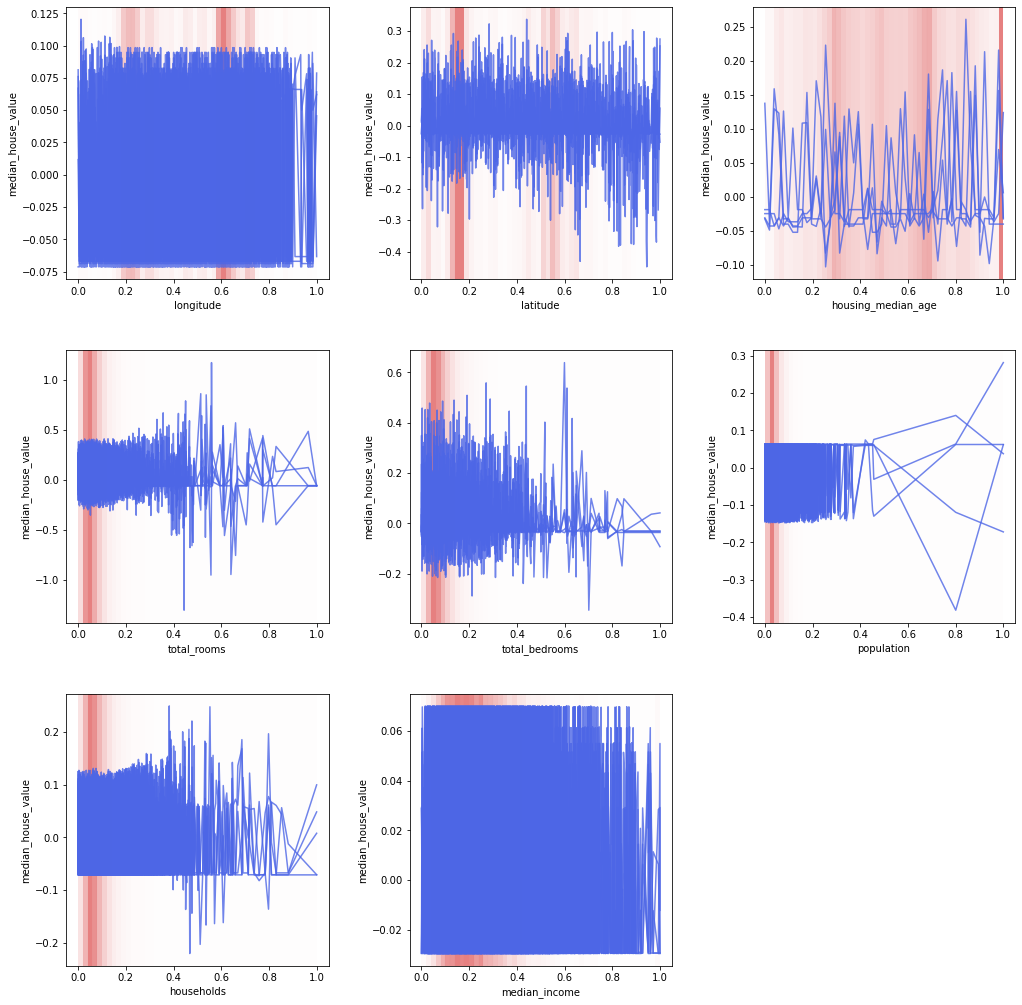

In [22]:
nam_plot(dataset, models)

In [ ]:
!conda install gxx_linux-64 gcc_linux-64 swig

Solving environment: failed with initial frozen solve. Retrying with flexible solve.

In [109]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
import torch 
import torch.nn as nn
import torch.nn.functional as F


# X, y = load_boston(return_X_y=True)
# X.shape
# y.shape
housing = sklearn.datasets.fetch_california_housing()
data = pd.DataFrame(data=housing.data, columns=housing.feature_names)
data['target'] = housing.target
data
X= data.iloc[:, :-1].values
y= data.iloc[:,-1].values
# data = pd.read_csv('data/housing.csv')
# data = data.drop(columns=['ocean_proximity'])
# data = data.dropna()
# y=data.iloc[:,-1].values

# # data =(data-data.mean())/data.std()
# # data = data.interpolate(method='linear', axis=0)
# X= data.iloc[:, :-1].values


scaler = MinMaxScaler()


X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)

X_train = torch.from_numpy(X_train.astype('float32'))
X_test = torch.from_numpy(X_test.astype('float32'))
y_train = torch.from_numpy(y_train.reshape(-1, 1).astype('float32'))
y_test = torch.from_numpy(y_test.reshape(-1, 1).astype('float32'))

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 12)
        self.layer4 = nn.Linear(12, 1)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = F.relu(self.layer3(x))
        x = self.dropout3(x)
        x = self.layer4(x)
        return x

model = NeuralNetwork()

loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for i in range(3):
    optimizer.zero_grad()
    for X, y in dataset_train:
        y_pred = model(X)
        loss = loss_obj(y_pred, y)
#         print(loss)
        loss.backward()
        optimizer.step()

y_pred = model(X_test)
r2_score(y_test.detach().numpy(), y_pred.detach().numpy())

0.27954246955438156

In [107]:
housing = sklearn.datasets.fetch_california_housing()
dataset = pd.DataFrame(data=housing.data, columns=housing.feature_names)
dataset['target'] = housing.target
dataset

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [105]:
sklearndata.data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [102]:
data = pd.read_csv('data/housing.csv')
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697


In [2]:
data["WP16"] = np.where(data["WP16"] < 6, 0, 1)

In [3]:
y=data.iloc[:,0].values

In [4]:
data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [5]:
data.head(3)

,WP16,wgt,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,-0.954120,1.184700,-0.007673,-1.065434,-1.488956,1.344815,0.642051
1,-0.954120,2.010882,-0.012368,-1.065434,-1.488956,0.075571,0.575457
2,1.048085,0.686555,-0.003729,-1.065434,-1.488956,0.921734,0.610033


In [6]:
x= data.iloc[:,1:].values
# y=data.iloc[:,0].values
x, y

(array([[ 1.1846996 , -0.00767343, -1.06543378, -1.48895611,  1.34481481,
          0.64205117],
        [ 2.0108822 , -0.01236773, -1.06543378, -1.48895611,  0.075571  ,
          0.57545723],
        [ 0.68655482, -0.00372865, -1.06543378, -1.48895611,  0.92173354,
          0.61003285],
        ...,
        [ 0.42526419, -0.02382686, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ],
        [-0.52427233, -0.02125759, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ],
        [-0.04950407,  0.00828902, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ]]),
 array([0, 0, 1, ..., 0, 0, 1]))

In [7]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

In [8]:
y

array([0, 0, 1, ..., 0, 0, 1])

In [9]:
data.columns

Index(['WP16', 'wgt', 'income_2', 'WP1219', 'WP1220', 'year',
       'weo_gdpc_con_ppp'],
      dtype='object')

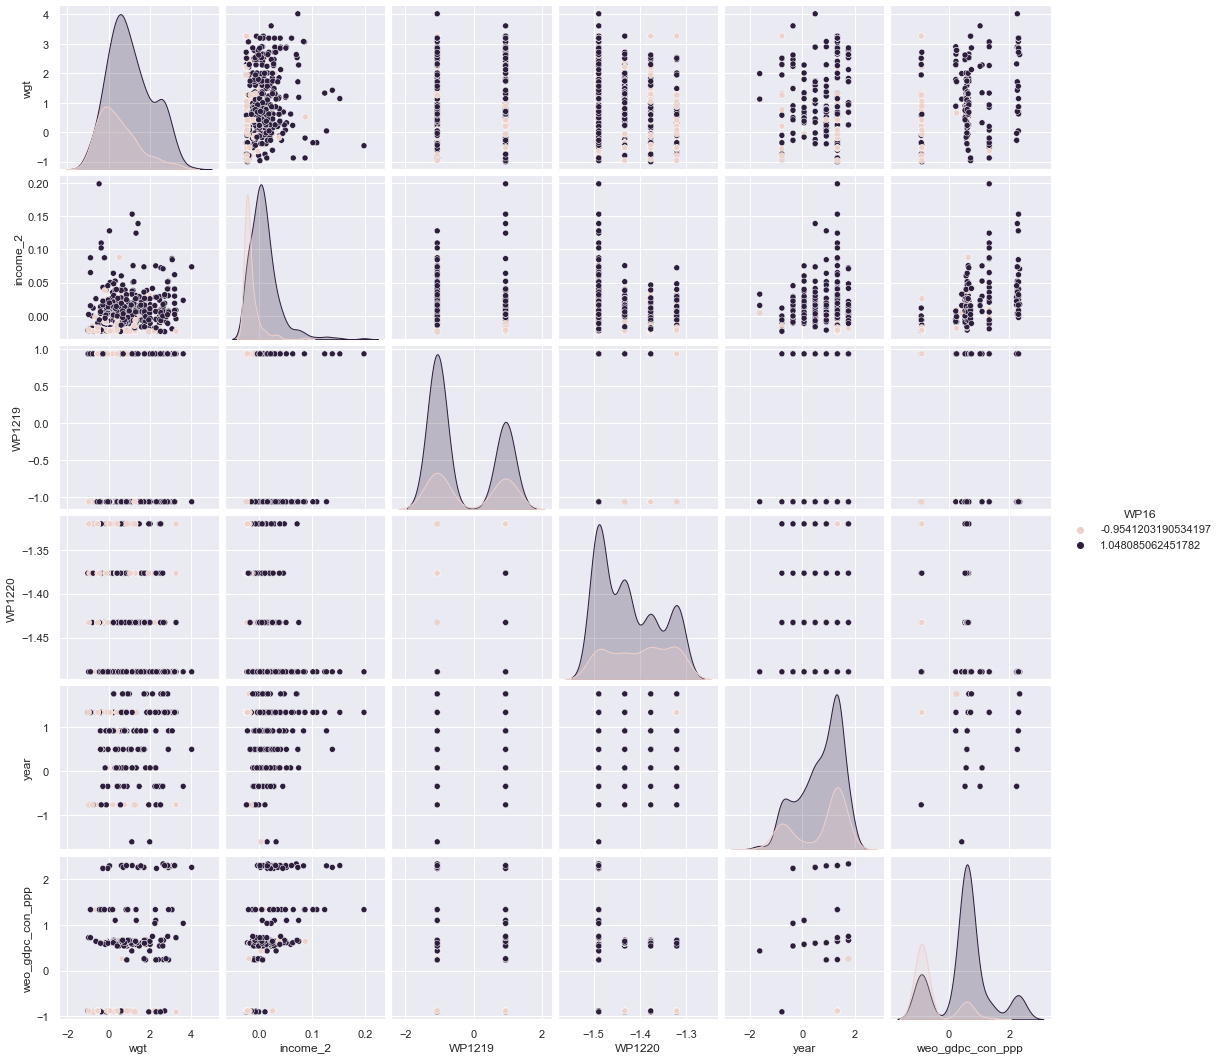

In [10]:
sns.set()
sns.pairplot(data[:500], hue="WP16", diag_kind="kde")

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [14]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

y_pred_test = gnb.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred_test)

In [15]:
acc

0.5579575033002439

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

y_pred2 = dt.predict(x_test)
acc2 = accuracy_score(y_test,y_pred2)
acc2

0.6261886471610445

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clf.fit(x_train,y_train)
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
acc3

In [ ]:
from sklearn.svm import SVC
SVC?

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(x_train,y_train)
y_pred4 = svc1.predict(x_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
acc4

In [12]:
import numpy as np
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split

# #loading data
# df = dsutils.load_bank()
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# y = df_train.pop('y')
# y_test = df_test.pop('y')

# #training
# config = deeptable.ModelConfig(nets=deepnets.DeepFM)
# dt = deeptable.DeepTable(config=config)
# model, history = dt.fit(df_train, y, epochs=10)

# #evaluation
# result = dt.evaluate(df_test,y_test, batch_size=512, verbose=0)
# print(result)

# #scoring
# preds = dt.predict(df_test)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/housing.csv')
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [37]:
data = data.drop(columns=['ocean_proximity'])

In [38]:
y=data.iloc[:,-1].values

In [39]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [40]:
# data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [41]:
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709,2.129580
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181,1.314124
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656,1.258663


In [159]:
data = df

In [42]:
x= data.iloc[:,:-1].values
# y=data.iloc[:,0].values
x, y

(array([[-1.32780305,  1.05252278,  0.98211887, ..., -0.97440499,
         -0.97700919,  2.34470896],
        [-1.32281187,  1.04315928, -0.60700421, ...,  0.861418  ,
          1.66992057,  2.33218146],
        [-1.33279424,  1.03847753,  1.85613656, ..., -0.82075747,
         -0.84361648,  1.78265622],
        ...,
        [-0.82369324,  1.77819439, -0.92482882, ..., -0.36952825,
         -0.17403741, -1.14256563],
        [-0.87360511,  1.77819439, -0.84537267, ..., -0.60441469,
         -0.39374304, -1.05455737],
        [-0.83367562,  1.75010387, -1.00428498, ..., -0.03397619,
          0.07967028, -0.78011057]]),
 array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.]))

In [30]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

In [43]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [45]:
x_train.shape, y_train.shape

((16512, 8), (16512,))

In [50]:
#training
config = deeptable.ModelConfig(nets=deepnets.DeepFM, 
                              categorical_columns='auto', # or categorical_columns=['x1', 'x2', 'x3', ...]
#                                 metrics=['AUC', 'accuracy'], # can be `metrics=['RootMeanSquaredError']` for regression task
                                metrics=['RootMeanSquaredError'],
                                auto_categorize=True,
                                auto_discrete=True,
                                embeddings_output_dim=32,
                                embedding_dropout=0.5,)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(x_train, y_train, batch_size=2048, epochs=10)

#evaluation
result = dt.evaluate(x_test,y_test, batch_size=1024, verbose=0)
print(result)

#scoring
preds = dt.predict(x_test)

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Target column type is float, so inferred as a [regression] task.
Preparing features taken 0.020405054092407227s
Imputation taken 0.023392677307128906s
Categorical encoding taken 0.00812530517578125s
Discretization taken 0.0769500732421875s
Injected a callback [EarlyStopping]. monitor:val_rootmeansquarederror, patience:1, mode:min
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (9)', 'input_continuous_all: (8)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [54, 7, 7, 11, 9, 10, 8, 12, 5]
output_dims: [32, 32, 32, 32, 32, 32, 32, 32, 32]
dropout: 0.5
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (No

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Model has been saved to:dt_output/dt_20210407 154125_dnn_nets_linear_fm_nets/dnn_nets+linear+fm_nets.h5


Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


{'loss': 56329687040.0, 'root_mean_squared_error': 237338.765625}


---
---
---

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/housing.csv')
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [ ]:
data = pd.read_csv('data/housing.csv')
data = data.drop(columns=['ocean_proximity'])
y=data.iloc[:,-1].values
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)
x= data.iloc[:, :-1].values

In [79]:
data = data.drop(columns=['ocean_proximity'])

In [80]:
y=data.iloc[:,-1].values
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [81]:
# data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [82]:
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709,2.129580
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181,1.314124
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656,1.258663


In [83]:
x= data.iloc[:, :-1].values
# y=data.iloc[:,0].values
x, y

(array([[-1.32780305,  1.05252278,  0.98211887, ..., -0.97440499,
         -0.97700919,  2.34470896],
        [-1.32281187,  1.04315928, -0.60700421, ...,  0.861418  ,
          1.66992057,  2.33218146],
        [-1.33279424,  1.03847753,  1.85613656, ..., -0.82075747,
         -0.84361648,  1.78265622],
        ...,
        [-0.82369324,  1.77819439, -0.92482882, ..., -0.36952825,
         -0.17403741, -1.14256563],
        [-0.87360511,  1.77819439, -0.84537267, ..., -0.60441469,
         -0.39374304, -1.05455737],
        [-0.83367562,  1.75010387, -1.00428498, ..., -0.03397619,
          0.07967028, -0.78011057]]),
 array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.]))

In [59]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [84]:
# sns.set()
# sns.pairplot(data[:500], hue="median_house_value", diag_kind="kde")

In [85]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [86]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

y_pred_test = gnb.predict(x_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_test)
r2

0.3215588133289874

In [73]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_test)
r2

KeyboardInterrupt: 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clf.fit(x_train,y_train)
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
acc3

In [ ]:
from sklearn.svm import SVC
SVC?

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(x_train,y_train)
y_pred4 = svc1.predict(x_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
acc4

In [74]:
import numpy as np
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split

# #loading data
# df = dsutils.load_bank()
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# y = df_train.pop('y')
# y_test = df_test.pop('y')

# #training
# config = deeptable.ModelConfig(nets=deepnets.DeepFM)
# dt = deeptable.DeepTable(config=config)
# model, history = dt.fit(df_train, y, epochs=10)

# #evaluation
# result = dt.evaluate(df_test,y_test, batch_size=512, verbose=0)
# print(result)

# #scoring
# preds = dt.predict(df_test)

In [87]:
# x= data.iloc[:,:-1].values
# y=data.iloc[:,0].values
x, y

(array([[-1.32780305,  1.05252278,  0.98211887, ..., -0.97440499,
         -0.97700919,  2.34470896],
        [-1.32281187,  1.04315928, -0.60700421, ...,  0.861418  ,
          1.66992057,  2.33218146],
        [-1.33279424,  1.03847753,  1.85613656, ..., -0.82075747,
         -0.84361648,  1.78265622],
        ...,
        [-0.82369324,  1.77819439, -0.92482882, ..., -0.36952825,
         -0.17403741, -1.14256563],
        [-0.87360511,  1.77819439, -0.84537267, ..., -0.60441469,
         -0.39374304, -1.05455737],
        [-0.83367562,  1.75010387, -1.00428498, ..., -0.03397619,
          0.07967028, -0.78011057]]),
 array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.]))

In [88]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [89]:
x_train.shape, y_train.shape

((16512, 8), (16512,))

In [90]:
#training
config = deeptable.ModelConfig(nets=deepnets.DeepFM, 
                              categorical_columns='auto', # or categorical_columns=['x1', 'x2', 'x3', ...]
#                                 metrics=['AUC', 'accuracy'], # can be `metrics=['RootMeanSquaredError']` for regression task
                                metrics=['RootMeanSquaredError'],
                                auto_categorize=True,
                                auto_discrete=True,
                                embeddings_output_dim=32,
                                embedding_dropout=0.5,)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(x_train, y_train, batch_size=2048, epochs=10)

#evaluation
result = dt.evaluate(x_test,y_test, batch_size=1024, verbose=0)
print(result)

#scoring
preds = dt.predict(x_test)

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Target column type is float, so inferred as a [regression] task.
Preparing features taken 0.022232770919799805s
Imputation taken 0.02314591407775879s
Categorical encoding taken 0.0071599483489990234s
Discretization taken 0.07288074493408203s
Injected a callback [EarlyStopping]. monitor:val_rootmeansquarederror, patience:1, mode:min
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (9)', 'input_continuous_all: (8)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [54, 7, 7, 11, 9, 10, 8, 12, 5]
output_dims: [32, 32, 32, 32, 32, 32, 32, 32, 32]
dropout: 0.5
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Model has been saved to:dt_output/dt_20210407 154655_dnn_nets_linear_fm_nets/dnn_nets+linear+fm_nets.h5


Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


{'loss': 54462861312.0, 'root_mean_squared_error': 233372.796875}


# DATA PROCESSING

In [147]:
import pandas as pd
df = pd.read_csv('data/GALLUP.csv')
df.head(10)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.73974,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.48749,1.0,15.0,2016,32658.020
5,10,1.463117,Israel,23851.99449,1.0,15.0,2015,32038.697
6,9,1.246618,Israel,50561.21923,1.0,15.0,2014,31844.204
7,9,1.350366,Israel,33309.73123,1.0,15.0,2016,32658.020
8,10,1.800488,Israel,83274.32807,1.0,15.0,2016,32658.020
9,8,1.463117,Israel,28061.16999,1.0,15.0,2015,32038.697


In [148]:
df.isna().sum()

WP16                    0
wgt                     0
country                 0
income_2                0
WP1219                  1
WP1220                185
year                    0
weo_gdpc_con_ppp    24122
dtype: int64

In [149]:
df = df.interpolate(method ='linear', limit_direction ='forward')

In [150]:
# df = df.drop(columns=['year', 'country'])

In [151]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.73974,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.48749,1.0,15.0,2016,32658.020


In [152]:
df = df.drop_duplicates(keep=False)

In [123]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [124]:
df2 = encode_and_bind(df, 'year')
df2 = encode_and_bind(df2, 'country')
df2.head()

,WP16,wgt,income_2,WP1219,WP1220,weo_gdpc_con_ppp,country_Afghanistan,country_Albania,country_Algeria,country_Angola,...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,"country_Venezuela, RB",country_Vietnam,"country_Yemen, Rep.",country_Zambia,country_Zimbabwe
0,4,1.800488,18042.77108,1.0,15.0,32658.020,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2.360024,12799.41274,1.0,15.0,31369.909,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,1.463117,22448.93600,1.0,15.0,32038.697,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,1.246618,16853.73974,1.0,15.0,31844.204,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1.800488,22206.48749,1.0,15.0,32658.020,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df = df2

In [153]:
columns = ['wgt', 'income_2', 'WP1219', 'WP1220', 'weo_gdpc_con_ppp']
df[columns] = df[columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [154]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,0.229189,Israel,0.000020,0.0,0.022727,2016,0.220878
1,4,0.303079,Israel,0.000014,0.0,0.022727,2013,0.212002
2,8,0.184638,Israel,0.000025,0.0,0.022727,2015,0.216610
3,5,0.156048,Israel,0.000019,0.0,0.022727,2014,0.215270
4,8,0.229189,Israel,0.000025,0.0,0.022727,2016,0.220878


In [155]:
df["WP16"] = np.where(df["WP16"]<6, 0, 1)

In [156]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,0.229189,Israel,0.000020,0.0,0.022727,2016,0.220878
1,0,0.303079,Israel,0.000014,0.0,0.022727,2013,0.212002
2,1,0.184638,Israel,0.000025,0.0,0.022727,2015,0.216610
3,0,0.156048,Israel,0.000019,0.0,0.022727,2014,0.215270
4,1,0.229189,Israel,0.000025,0.0,0.022727,2016,0.220878


In [133]:
list(df.columns)[2:]

['income_2',
 'WP1219',
 'WP1220',
 'weo_gdpc_con_ppp',
 'country_Afghanistan',
 'country_Albania',
 'country_Algeria',
 'country_Angola',
 'country_Argentina',
 'country_Armenia',
 'country_Australia',
 'country_Austria',
 'country_Azerbaijan',
 'country_Bahrain',
 'country_Bangladesh',
 'country_Belarus',
 'country_Belgium',
 'country_Belize',
 'country_Benin',
 'country_Bhutan',
 'country_Bolivia',
 'country_Bosnia and Herzegovina',
 'country_Botswana',
 'country_Brazil',
 'country_Bulgaria',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Cameroon',
 'country_Canada',
 'country_Central African Republic',
 'country_Chad',
 'country_Chile',
 'country_China',
 'country_Colombia',
 'country_Comoros',
 'country_Congo, Dem. Rep.',
 'country_Congo, Rep.',
 'country_Costa Rica',
 "country_Cote d'Ivoire",
 'country_Croatia',
 'country_Cyprus',
 'country_Czech Republic',
 'country_Denmark',
 'country_Dominican Republic',
 'country_Ecuador',
 'country_Egypt, Arab R

In [157]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
# y = ly.fit_transform(y)

In [158]:
columns = ['year', 'country']
df[columns] = df[columns].apply(lambda x: ly.fit_transform(x))

In [159]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,0.229189,65,0.000020,0.0,0.022727,7,0.220878
1,0,0.303079,65,0.000014,0.0,0.022727,4,0.212002
2,1,0.184638,65,0.000025,0.0,0.022727,6,0.216610
3,0,0.156048,65,0.000019,0.0,0.022727,5,0.215270
4,1,0.229189,65,0.000025,0.0,0.022727,7,0.220878


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

y=data.iloc[:,0].values

data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

data.head(3)

x= data.iloc[:,1:].values
# y=data.iloc[:,0].values
x, y

from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

y

data.columns

sns.set()
sns.pairplot(data[:1000], hue="WP16", diag_kind="kde")

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

y_pred_test = gnb.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred_test)

acc

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

y_pred2 = dt.predict(x_test)
acc2 = accuracy_score(y_test,y_pred2)
acc2

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clf.fit(x_train,y_train)
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
acc3

from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(x_train,y_train)
y_pred4 = svc1.predict(x_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
acc4

import numpy as np
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split

# #loading data
# df = dsutils.load_bank()
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# y = df_train.pop('y')
# y_test = df_test.pop('y')

# #training
# config = deeptable.ModelConfig(nets=deepnets.DeepFM)
# dt = deeptable.DeepTable(config=config)
# model, history = dt.fit(df_train, y, epochs=10)

# #evaluation
# result = dt.evaluate(df_test,y_test, batch_size=512, verbose=0)
# print(result)

# #scoring
# preds = dt.predict(df_test)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

y=data.iloc[:,0].values

# data = data.drop('country', axis=1)
# data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

data.head(3)

data = df

x= data.iloc[:,1:].values
y=data.iloc[:,0].values
x, y

from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

y

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

x_train.shape, y_train.shape

#training
config = deeptable.ModelConfig(nets=deepnets.DeepFM, 
                              categorical_columns='auto', # or categorical_columns=['x1', 'x2', 'x3', ...]
                                metrics=['AUC', 'accuracy'], # can be `metrics=['RootMeanSquaredError']` for regression task
                                auto_categorize=True,
                                auto_discrete=False,
                                embeddings_output_dim=20,
                                embedding_dropout=0.3,)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(x_train, y_train, batch_size=2048, epochs=3)

#evaluation
result = dt.evaluate(x_test,y_test, batch_size=1024, verbose=0)
print(result)

#scoring
preds = dt.predict(x_test)

# DATA PROCESSING

import pandas as pd
df = pd.read_csv('data/GALLUP.csv')
df.head(10)

df.isna().sum()

df = df.interpolate(method ='linear', limit_direction ='forward')

# df = df.drop(columns=['year', 'country'])

df.head()

df = df.drop_duplicates(keep=False)

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

df2 = encode_and_bind(df, 'year')
df2 = encode_and_bind(df2, 'country')
df2.head()

df = df2

columns = ['wgt', 'income_2', 'WP1219', 'WP1220', 'weo_gdpc_con_ppp']
df[columns] = df[columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df.head()

df["WP16"] = np.where(df["WP16"]<6, 0, 1)

df.head()

list(df.columns)[2:]

from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
# y = ly.fit_transform(y)

columns = ['year', 'country']
df[columns] = df[columns].apply(lambda x: ly.fit_transform(x))

df.head()



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import imageio

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from tqdm.notebook import tqdm


from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler

%matplotlib inline

In [2]:
torch.manual_seed(0); 

In [3]:
sns.set_style(style='whitegrid')
plt.rcParams["patch.force_edgecolor"] = True

In [4]:
from nam.config import defaults
from nam.data import NAMDataset
from nam.models import NAM, FeatureNN, DNN, get_num_units

## Config

In [5]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=1, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=False, seed=1377, shuffle=True, training_epochs=10, units_multiplier=2, use_dnn=False)


In [6]:
config.batch_size = 64
config.training_epochs = 200
config.hidden_sizes = [200, 100]
config.dropout = 0.0

## data

In [7]:
## QUAD
x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)
y = x.pow(4) + x.pow(3) * x.pow(2) + 0.25 * torch.rand(x.size())             

In [8]:
# Sin
x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)
y = torch.sin(x) + 0.25 * torch.rand(x.size())    

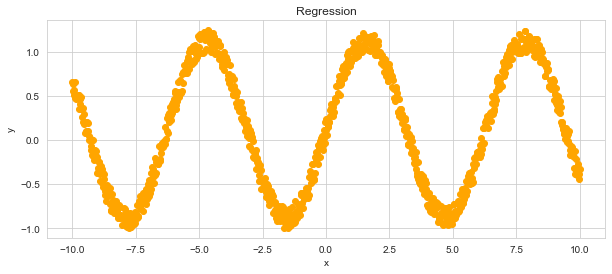

In [9]:
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
dataset = torch.utils.data.TensorDataset(x, y)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset, 
    batch_size=config.batch_size, 
    shuffle=True, num_workers=2, drop_last=True,
)

In [11]:
input_dim = dataset[0][0].shape[-1]; input_dim

1

In [12]:
get_num_units(config, dataloader)

[128]

In [13]:
model = FeatureNN(
  config=config,
  name=f'FeatureNN_{0}',
  input_shape=input_dim,
  num_units=get_num_units(config, dataloader)[0],
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


FeatureNN(
  (model): ModuleList(
    (0): ExU(in_features=1, out_features=128)
    (1): LinReLU(in_features=128, out_features=200)
    (2): LinReLU(in_features=200, out_features=100)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [14]:
dict(model.named_parameters()).keys()

dict_keys(['model.0.weights', 'model.0.bias', 'model.1.weights', 'model.1.bias', 'model.2.weights', 'model.2.bias', 'model.3.weight', 'model.3.bias'])

In [15]:
model = DNN(config=config,)
model

DNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (model): Sequential(
    (0): Linear(in_features=1, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [14]:
dict(model.named_parameters()).keys()

dict_keys(['model.0.weights', 'model.0.bias', 'model.1.weights', 'model.1.bias', 'model.2.weights', 'model.2.bias', 'model.3.weight', 'model.3.bias'])

In [25]:
# model = torch.nn.Sequential(
#         torch.nn.Linear(1, 200),
#         torch.nn.LeakyReLU(),
#         torch.nn.Linear(200, 100),
#         torch.nn.LeakyReLU(),
#         torch.nn.Linear(100, 1),
#     )
# model

In [26]:
# dict(model.named_parameters()).keys()

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
criterion = torch.nn.MSELoss() 

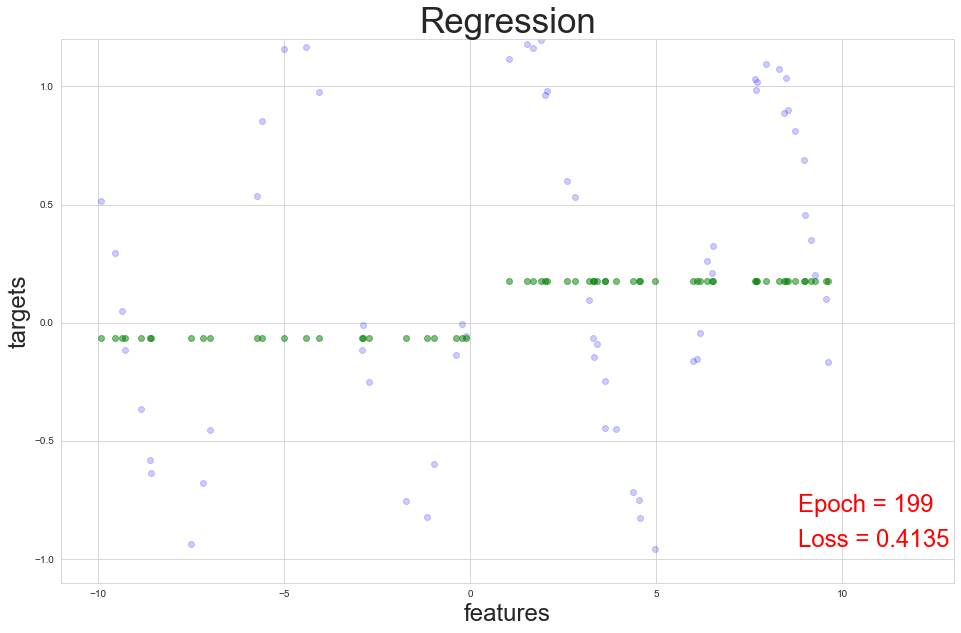

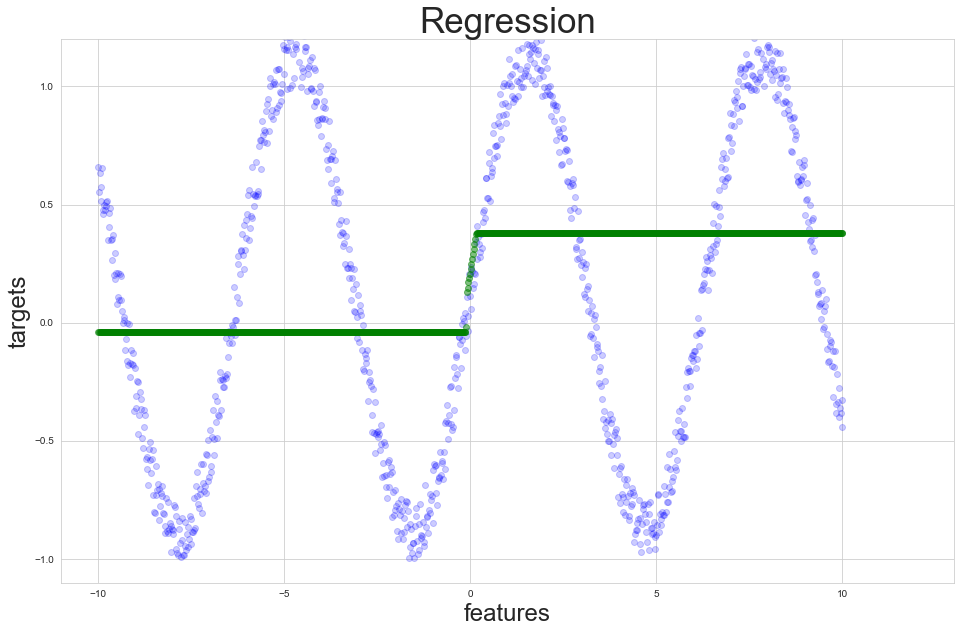

In [16]:
images = []
fig, ax = plt.subplots(figsize=(16, 10))

# start training
for epoch in range(config.training_epochs):
    for step, (features, targets) in enumerate(dataloader):

        prediction = model(features)

        loss = criterion(prediction, targets)  

        optimizer.zero_grad() 
        loss.backward()       
        optimizer.step()      

        if step == 1:
            plt.cla()
            ax.set_title('Regression', fontsize=35)
            ax.set_xlabel('features', fontsize=24)
            ax.set_ylabel('targets', fontsize=24)
            ax.set_xlim(-11.0, 13.0)
            ax.set_ylim(-1.1, 1.2)
            ax.scatter(features.data.numpy(), targets.data.numpy(), color = "blue", alpha=0.2)
            ax.scatter(features.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
            ax.text(8.8, -0.8, 'Epoch = %d' % epoch,
                    fontdict={'size': 24, 'color':  'red'})
            ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),
                    fontdict={'size': 24, 'color':  'red'})

            # Used to return the plot as an image array 
            # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
            fig.canvas.draw()       # draw the canvas, cache the renderer
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            images.append(image)

    


# save images as a gif    
imageio.mimsave('./batch.gif', images, fps=12)


fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title(f'Regression', fontsize=35)
ax.set_xlabel('features', fontsize=24)
ax.set_ylabel('targets', fontsize=24)
ax.set_xlim(-11.0, 13.0)
ax.set_ylim(-1.1, 1.2)
ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue", alpha=0.2)
prediction = model(x)     # input x and predict based on x
ax.scatter(x.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
plt.savefig('batches.png')
plt.show()

---
---
---

In [58]:
model = FeatureNN(
  config=config,
  name=f'FeatureNN_{0}',
  input_shape=input_dim,
  num_units=64,
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=1, out_features=64)
    (1): LinReLU(in_features=64, out_features=64)
    (2): LinReLU(in_features=64, out_features=32)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from tqdm.notebook import tqdm


from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler

In [5]:
housing = pd.read_csv('data/housing.csv')
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [6]:
housing.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [7]:
# with sns.plotting_context("paper") :
#     g = sns.pairplot(housing)
# g.set(xticklabels=[])

# plt.show()
# plt.clf()

In [8]:
from nam.config import defaults
from nam.data import NAMDataset
from nam.models import NAM, FeatureNN, DNN, get_num_units

## Config

In [9]:
config = defaults()
config

namespace(device='cpu',
          output_dir='output',
          training_epochs=10,
          lr=0.01,
          batch_size=1024,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.0,
          decay_rate=0.995,
          l2_regularization=0.0,
          output_regularization=0.0,
          num_basis_functions=1000,
          units_multiplier=2,
          num_units=64,
          data_split=1,
          seed=1377,
          cross_val=False,
          n_models=1,
          num_splits=3,
          fold_num=1,
          shuffle=True,
          regression=False,
          debug=False,
          use_dnn=False,
          patience=10,
          n_folds=5,
          num_workers=16)

In [10]:
data = housing

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [14]:
data.median_house_value.value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
243700.0      1
454800.0      1
290200.0      1
486800.0      1
289700.0      1
Name: median_house_value, Length: 3842, dtype: int64

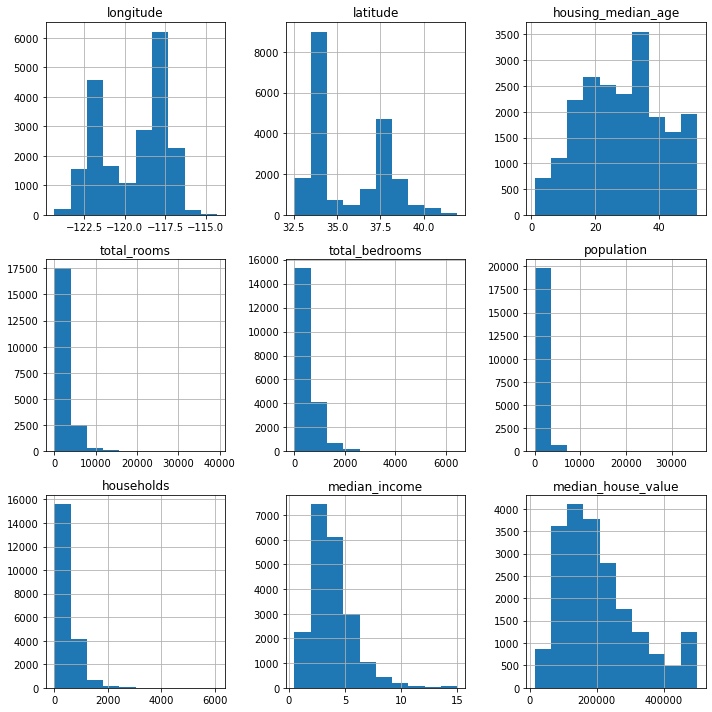

In [15]:
data.hist(figsize=(10,10))
plt.tight_layout()

### Correlations

<AxesSubplot:>

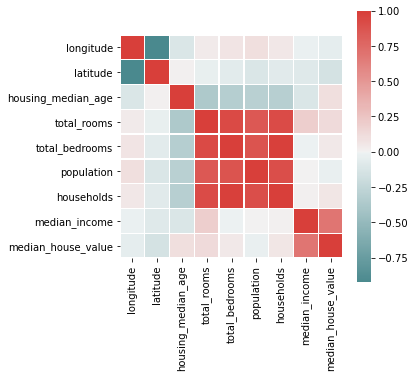

In [16]:
corr = data.corr()
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(2000, 13, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5)

### Outliers

<AxesSubplot:>

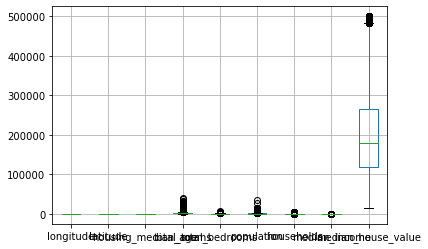

In [17]:
data.boxplot()

<AxesSubplot:>

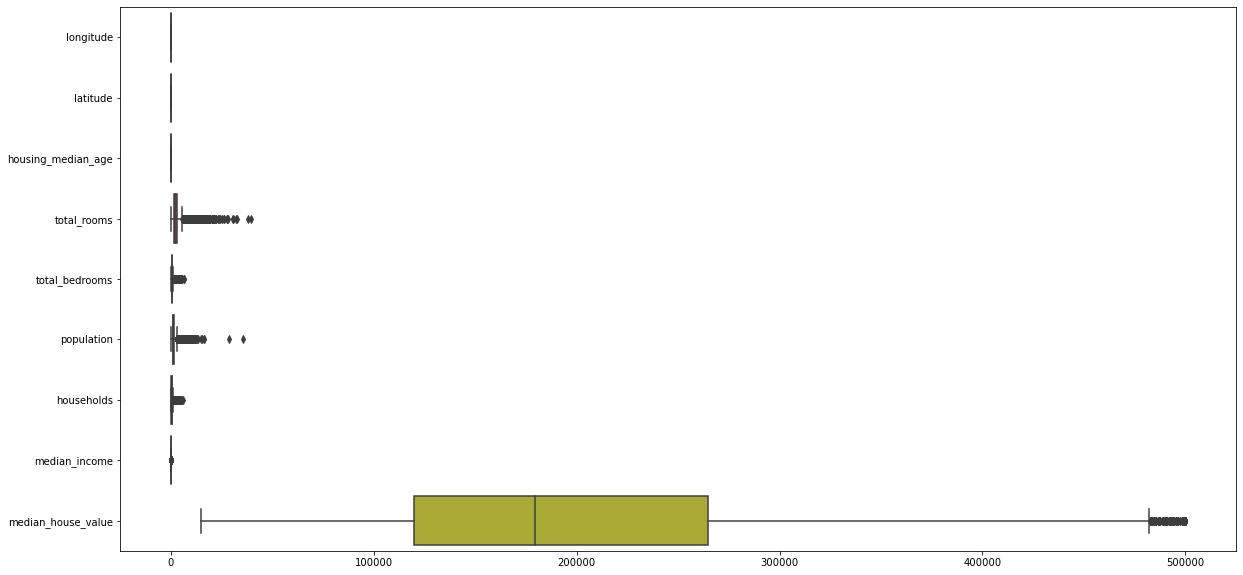

In [18]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
sns.boxplot(data= data, orient="h",  ax = ax)

## Remove NaNs

In [19]:
data = data.interpolate(method='linear', axis=0)

In [20]:
dataset = NAMDataset(
    config=config,
    csv_file=data, #'data/GALLUP.csv',
    features_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',],
    targets_column = ['median_house_value'],
#     weights_column = ["wgt"],   
#     one_hot=True,
)
dataset

NAMDatasetSample(features=tensor([-121.9600,   37.9600,   28.0000, 1838.0000,  273.0000,  899.0000,
         270.0000,    5.2145]), targets=tensor([203900]))

In [83]:
dataset = NAMDataset(
    config=config,
    csv_file=data, #'data/GALLUP.csv',
    features_columns = ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
    targets_column = ["WP16"],
    weights_column = ["wgt"],   
#     one_hot=True,
)
dataset

NAMDatasetSample(
	features=tensor([4.5910e+04, 2.0000e+00, 6.5000e+01, 3.8694e+04]), 
	targets=tensor([7]), 
	weights=tensor([1.3574])
)

In [21]:
train_dataset, test_dataset = torch.utils.data.random_split(
  dataset,
  [int(np.floor(len(dataset) * .9)),
   int(np.ceil(len(dataset) * .1))],
)
print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset, val_dataset = torch.utils.data.random_split(
  train_dataset,
  [int(np.floor(len(train_dataset) * .8)),
   int(np.ceil(len(train_dataset) * .2))],
)
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}")

train_dataloader = DataLoader(
  train_dataset,
  batch_size=config.batch_size,
  shuffle=True,
  num_workers=config.num_workers,
#   sampler=weighted_sampler,
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=config.batch_size * 5,
  shuffle=False,
  num_workers=config.num_workers,
)

train_dataset: 18576, test_dataset: 2064
train_dataset: 14860, val_dataset: 3716


In [22]:
next(iter(train_dataloader))

[tensor([[-118.1100,   33.8000,   36.0000,  ...,  744.0000,  280.0000,
             4.6600],
         [-118.1700,   33.8500,   37.0000,  ..., 1956.0000,  694.0000,
             4.2218],
         [-120.4500,   37.3100,   20.0000,  ..., 2055.0000,  716.0000,
             3.7652],
         ...,
         [-117.9000,   33.8500,   35.0000,  ..., 1026.0000,  332.0000,
             3.6000],
         [-118.3700,   34.1600,   10.0000,  ..., 1373.0000,  680.0000,
             3.6128],
         [-117.1300,   32.7200,   43.0000,  ..., 1221.0000,  452.0000,
             2.4821]]),
 tensor([[244800],
         [200500],
         [133500],
         ...,
         [193500],
         [225000],
         [140600]])]

In [23]:
features, targets, *weights = next(iter(train_dataloader))

---
---
---

In [24]:
mm = FeatureNN(
          config=config,
          name=f'FeatureNN_{0}',
          input_shape=next(iter(train_dataloader))[0].shape[-1],
          num_units=128,
)
mm

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=8, out_features=128)
    (1): LinReLU(in_features=128, out_features=64)
    (2): LinReLU(in_features=64, out_features=32)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [25]:
mm

FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=8, out_features=128)
    (1): LinReLU(in_features=128, out_features=64)
    (2): LinReLU(in_features=64, out_features=32)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [123]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, train_dataloader)
)
# model

In [26]:
features, targets, *weights = next(iter(train_dataloader))

In [27]:
loss_fn = torch.nn.MSELoss()

In [39]:
loss_fn((mm(features)), targets.squeeze())

tensor(7.3590e+10, grad_fn=<MseLossBackward>)

In [31]:
model = mm

In [36]:
loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [42]:
X.dtype

torch.float32

In [43]:
y.dtype

torch.int64

In [44]:
for i in range(config.training_epochs):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
#             y_pred = mm(X)
            loss = loss_fn(model(X), y.float().squeeze())
            loss.backward()
            optimizer.step()
            print(f'loss: {loss.item()}')

loss: 79442927616.0
loss: 74146086912.0
loss: 71698227200.0
loss: 71407656960.0
loss: 73208848384.0
loss: 72903344128.0
loss: 71335813120.0
loss: 77107044352.0
loss: 72156889088.0
loss: 70619258880.0
loss: 72959500288.0
loss: 65602592768.0
loss: 64062726144.0
loss: 71082205184.0
loss: 62154514432.0


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([524])) that is different to the input size (torch.Size([524, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 67514302464.0
loss: 67548053504.0
loss: 68625088512.0
loss: 66347954176.0
loss: 69151211520.0
loss: 71051075584.0
loss: 63134031872.0
loss: 66031902720.0
loss: 62993985536.0
loss: 59698286592.0
loss: 70254903296.0
loss: 59633627136.0
loss: 58648350720.0
loss: 63336017920.0
loss: 59398787072.0
loss: 60088684544.0
loss: 58214510592.0
loss: 61060853760.0
loss: 62841532416.0
loss: 65063460864.0
loss: 56834301952.0
loss: 56554045440.0
loss: 60777754624.0
loss: 52922753024.0
loss: 66315976704.0
loss: 57868730368.0
loss: 61423771648.0
loss: 58621882368.0
loss: 60988190720.0
loss: 50044305408.0
loss: 64031997952.0
loss: 59539300352.0
loss: 56111849472.0
loss: 59278643200.0
loss: 58836099072.0
loss: 54746570752.0
loss: 59710885888.0
loss: 59508674560.0
loss: 53227814912.0
loss: 56793907200.0
loss: 56475566080.0
loss: 56653438976.0
loss: 56072118272.0
loss: 53794414592.0
loss: 57598799872.0
loss: 52251312128.0
loss: 61990760448.0
loss: 53515173888.0
loss: 58981670912.0
loss: 62018031616.0


In [202]:
!pip install pytorch-lightning-bolts

     |████████████████████████████████| 247 kB 1.1 MB/s eta 0:00:01
  Using cached pytorch_lightning-1.1.8-py3-none-any.whl (696 kB)
Processing /Users/amrmkayid/Library/Caches/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653/PyYAML-5.3.1-cp37-cp37m-macosx_10_9_x86_64.whl
     |████████████████████████████████| 643 kB 2.8 MB/s eta 0:00:01
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
     |████████████████████████████████| 123 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 535 kB/s eta 0:00:01


  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.1.0
    Uninstalling pytorch-lightning-1.1.0:
      Successfully uninstalled pytorch-lightning-1.1.0


In [203]:
from pl_bolts.models.regression import LinearRegression
import pytorch_lightning as pl
from pl_bolts.datamodules import SklearnDataModule
from sklearn.datasets import load_boston

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  f' install it with `pip install {pypi_name}`.' + extra_text


In [204]:
X, y = load_boston(return_X_y=True)
loaders = SklearnDataModule(X, y)

In [208]:
X.shape

(506, 13)

In [210]:
5.18e+03

5180.0

In [209]:
model = LinearRegression(input_dim=13)
trainer = pl.Trainer()
trainer.fit(model, train_dataloader=loaders.train_dataloader(), val_dataloaders=loaders.val_dataloader())
trainer.test(test_dataloaders=loaders.test_dataloader())

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 14    
----------------------------------
14        Trainable params
0         Non-trainable params
14        Total params
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:78: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'val_loss': F.mse_loss(y_hat, y)}
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or prog

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:56: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y, reduction='sum')
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:56: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y, reduction='sum')


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:78: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'val_loss': F.mse_loss(y_hat, y)}


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fed48cfae60>
Traceback (most recent call last):
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottl


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 79.2346420288086, 'test_mse_loss': 79.2346420288086}
--------------------------------------------------------------------------------


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:89: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'test_loss': F.mse_loss(y_hat, y)}
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:89: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'test_loss': F.mse_loss(y_hat, y)}
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the Lightni

[{'test_mse_loss': 79.2346420288086, 'test_loss': 79.2346420288086}]

In [161]:
import csv
import numpy as np
from interpret.glassbox import ExplainableBoostingClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

np.random.seed(0)

ebm = ExplainableBoostingClassifier()

In [165]:
bs=5 #This is the square root of the number of betas. Square root for plotting convenience
obs=20_000 #Number of obs
const=5 #Constant a in y=a+beta*x+e
badd=1 #Multiplies the normally distributed random betas by a constant
eadd=10

#Creating the real underlying data
x=np.random.normal(size=[obs,bs**2])
errors=eadd*np.random.normal(size=[obs])
beta=badd*np.random.normal(size=[bs**2])
y=const+np.matmul(x,beta)+errors

In [172]:
#Estimating the GAMs
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2)

marginal = Marginal().explain_data(X_train, Y_train, name = 'Train Data')
ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, Y_train)  

ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, Y_test, name='EBM')
ebm_global = ebm.explain_global(name='EBM')

In [173]:
#Estimating the OLS
model=sm.regression.linear_model.OLS(y,x,hasconst=True)
results=model.fit()
beta_hat=results.params

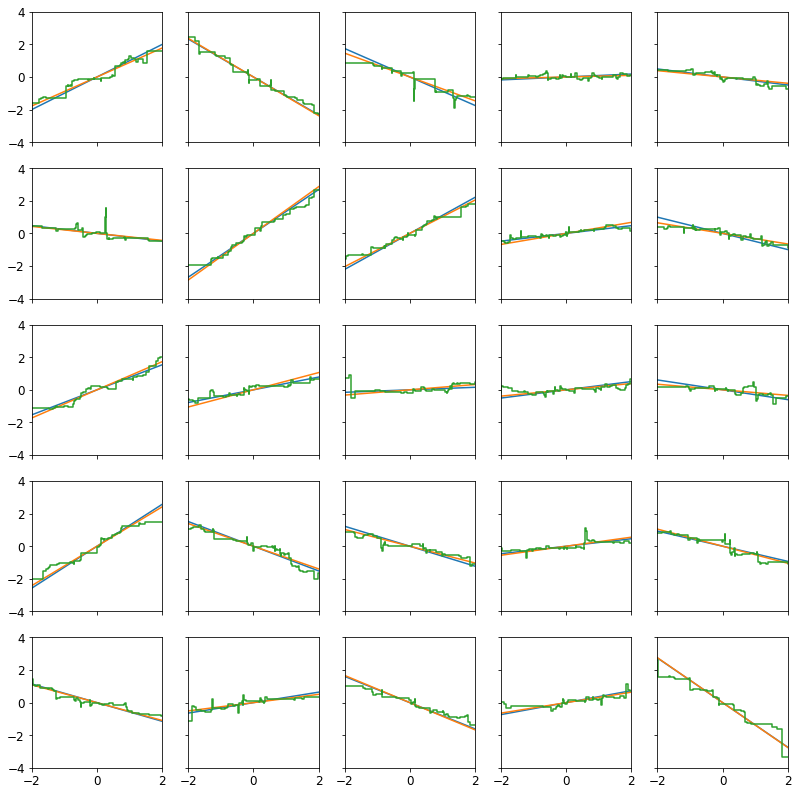

In [184]:
#Plotting everything
fig,axs=plt.subplots(bs,bs,sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

for indx in range(0,len(beta)):
    i = math.floor(indx/bs)
    j = indx-i*bs
    sortedx = np.sort(x[:,indx])
    xs = np.array([min(sortedx),max(sortedx)])
    y_true = np.array(xs*beta[indx])
    y_hat = np.array(xs*beta_hat[indx])
    axs[i,j].plot(xs, y_true)
    axs[i,j].plot(xs, y_hat)
    axs[i,j].step(ebm_global.data(indx)['names'],np.append(ebm_global.data(indx)['scores'][0],ebm_global.data(indx)['scores']))
    axs[i,j].set_xlim(-2.0,2.0)
    axs[i,j].set_ylim(-badd*4,badd*4)
fig.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

In [185]:
X_train.shape

(16000, 25)

In [192]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train)) 
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset: 16000, test_dataset: 4000


In [193]:
train_dataset, val_dataset = torch.utils.data.random_split(
  train_dataset,
  [int(np.floor(len(train_dataset) * .8)),
   int(np.ceil(len(train_dataset) * .2))],
)
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}")

train_dataloader = DataLoader(
  train_dataset,
  batch_size=config.batch_size,
  shuffle=True,
  num_workers=config.num_workers,
#   sampler=weighted_sampler,
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=config.batch_size * 5,
  shuffle=False,
  num_workers=config.num_workers,
)

train_dataset: 12800, val_dataset: 3200


In [194]:
next(iter(train_dataloader))

[tensor([[-0.1526, -0.0699,  0.0344,  ..., -2.4379,  0.4553,  0.2228],
         [ 0.8710, -0.1761, -0.5021,  ..., -0.2297, -0.1952,  0.4735],
         [ 0.7388, -1.3238, -0.0403,  ...,  1.2796, -0.6479,  0.7110],
         ...,
         [-1.1951,  2.2898,  0.5310,  ...,  0.3028, -0.5856,  1.1773],
         [ 0.5276, -1.0801, -0.6829,  ...,  1.2537, -2.2294, -0.9727],
         [-1.0439, -0.0601, -1.2034,  ..., -1.3291, -0.8596, -0.2314]]),
 tensor([27.7214, 21.0314, 27.0017,  ..., -2.2709, -7.6513, -3.3114])]

In [197]:
len(train_dataset[0][0])

25

In [199]:
model = NAM(
      config=config,
      name="NAMModel_LR",
      num_inputs=len(train_dataset[0][0]),
      num_units=get_num_units(config, train_dataloader)
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
   

In [200]:
loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [201]:
for i in range(config.training_epochs):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
            print(f'loss: {loss.item()}')

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 37910.98046875
loss: 3027.17333984375
loss: 1260.0426025390625
loss: 497.72894287109375
loss: 1086.264892578125
loss: 145.00889587402344
loss: 143.3607177734375
loss: 166.01918029785156
loss: 137.21466064453125
loss: 137.58963012695312
loss: 136.67327880859375
loss: 130.57212829589844
loss: 141.54693603515625


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 138.5167236328125
loss: 151.27325439453125
loss: 137.65972900390625
loss: 141.980224609375
loss: 139.1464385986328
loss: 136.0861053466797
loss: 129.47267150878906
loss: 128.93504333496094
loss: 158.31224060058594
loss: 136.73008728027344
loss: 132.42921447753906
loss: 132.38514709472656
loss: 147.32704162597656
loss: 141.46954345703125
loss: 143.9274444580078
loss: 139.38441467285156
loss: 124.92742156982422
loss: 147.96380615234375
loss: 145.59117126464844
loss: 142.50132751464844
loss: 130.53343200683594
loss: 150.8231201171875
loss: 129.20997619628906
loss: 142.363037109375
loss: 139.24720764160156
loss: 120.27325439453125
loss: 131.596923828125
loss: 139.44093322753906
loss: 138.36485290527344
loss: 139.15760803222656
loss: 139.71620178222656
loss: 131.7268829345703
loss: 134.58526611328125
loss: 144.710205078125
loss: 134.15142822265625
loss: 140.13255310058594
loss: 142.97377014160156
loss: 145.8238983154297
loss: 142.50445556640625
loss: 136.59844970703125
loss: 146.71826

In [186]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from tqdm.notebook import tqdm


from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler

In [187]:
from nam.config import defaults
from nam.data import NAMDataset
from nam.models import NAM, get_num_units

## Config

In [188]:
config = defaults()
config

namespace(device='cpu',
          output_dir='output',
          training_epochs=10,
          lr=0.01,
          batch_size=1024,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.0,
          decay_rate=0.995,
          l2_regularization=0.0,
          output_regularization=0.0,
          num_basis_functions=1000,
          units_multiplier=2,
          num_units=64,
          data_split=1,
          seed=1377,
          cross_val=False,
          n_models=1,
          num_splits=3,
          fold_num=1,
          shuffle=True,
          regression=False,
          debug=False,
          use_dnn=False,
          patience=10,
          n_folds=5,
          num_workers=16)

## DATA

In [4]:
data = pd.read_csv('data/GALLUP.csv')
data

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.771080,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.412740,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.936000,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.739740,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.487490,1.0,15.0,2016,32658.020
...,...,...,...,...,...,...,...,...
1340804,3,0.569955,Zimbabwe,566.020845,1.0,100.0,2017,2079.190
1340805,3,0.533722,Zimbabwe,453.127896,1.0,100.0,2014,2134.776
1340806,5,1.286156,Zimbabwe,0.000000,1.0,100.0,2011,1920.745
1340807,5,0.643078,Zimbabwe,2869.777740,1.0,100.0,2011,1920.745


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340809 entries, 0 to 1340808
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   WP16              1340809 non-null  int64  
 1   wgt               1340809 non-null  float64
 2   country           1340809 non-null  object 
 3   income_2          1340809 non-null  float64
 4   WP1219            1340808 non-null  float64
 5   WP1220            1340624 non-null  float64
 6   year              1340809 non-null  int64  
 7   weo_gdpc_con_ppp  1316687 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 81.8+ MB


In [6]:
data.describe()

,WP16,wgt,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
count,1.340809e+06,1.340809e+06,1.340809e+06,1.340808e+06,1.340624e+06,1.340809e+06,1.316687e+06
mean,5.515844e+00,9.981441e-01,2.661370e+04,1.531649e+00,4.152368e+01,2.012821e+03,2.023897e+04
std,2.312987e+00,6.772548e-01,1.116962e+06,4.989975e-01,1.781361e+01,2.363612e+00,1.934277e+04
min,0.000000e+00,6.493207e-02,0.000000e+00,1.000000e+00,1.300000e+01,2.009000e+03,6.043400e+02
25%,4.000000e+00,4.892472e-01,4.311222e+03,1.000000e+00,2.700000e+01,2.011000e+03,5.190297e+03
50%,5.000000e+00,8.148008e-01,1.084338e+04,2.000000e+00,3.900000e+01,2.013000e+03,1.384583e+04
75%,7.000000e+00,1.307699e+00,2.694815e+04,2.000000e+00,5.400000e+01,2.015000e+03,3.174637e+04
max,1.000000e+01,7.637515e+00,8.980336e+08,2.000000e+00,1.010000e+02,2.017000e+03,1.457238e+05


In [7]:
data.WP16.value_counts()

5     304903
7     181094
6     170730
8     164172
4     144256
3     117753
2      64560
10     62924
9      60022
1      36923
0      33472
Name: WP16, dtype: int64

<AxesSubplot:xlabel='WP16', ylabel='count'>

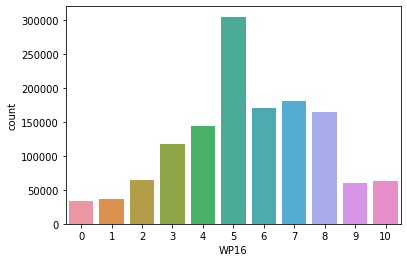

In [8]:
sns.countplot(x = 'WP16', data=data)

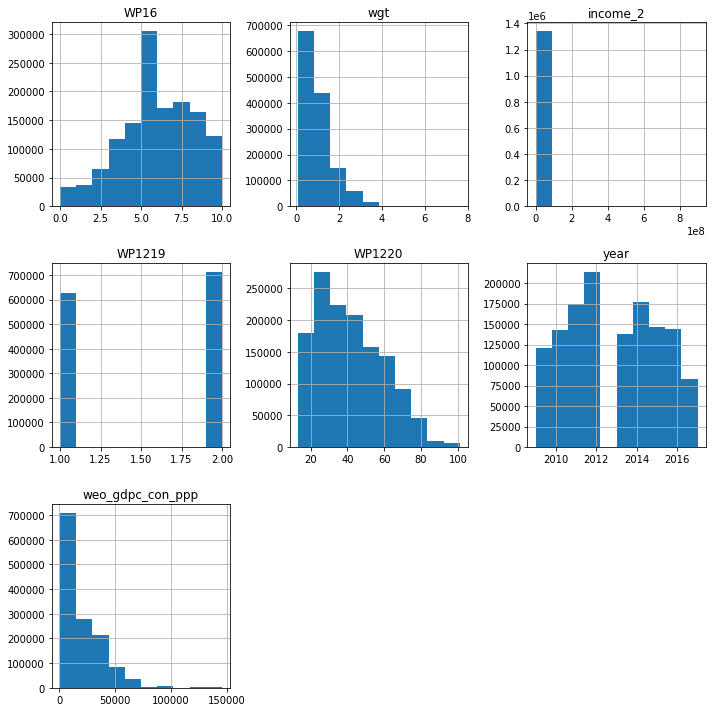

In [21]:
data.hist(figsize=(10,10))
plt.tight_layout()

### Correlations

<AxesSubplot:>

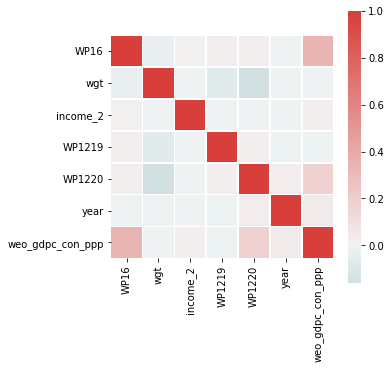

In [23]:
corr = data.corr()
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(2000, 13, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5)

### PaiPlots

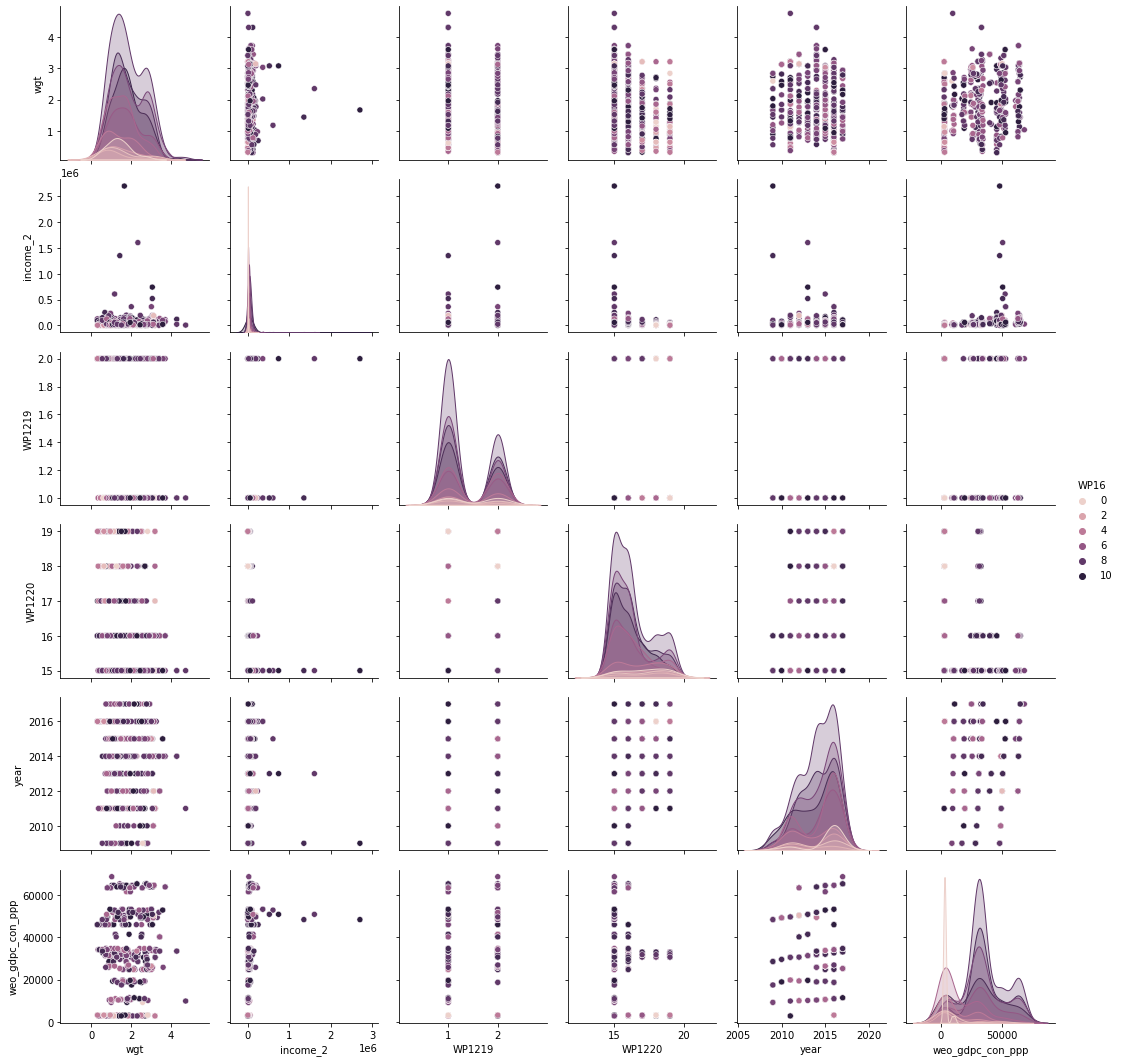

In [37]:
sns.pairplot(data[:1000], hue = 'WP16')

### Outliers

<AxesSubplot:>

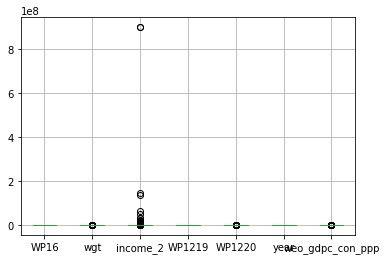

In [29]:
data.boxplot()

<AxesSubplot:>

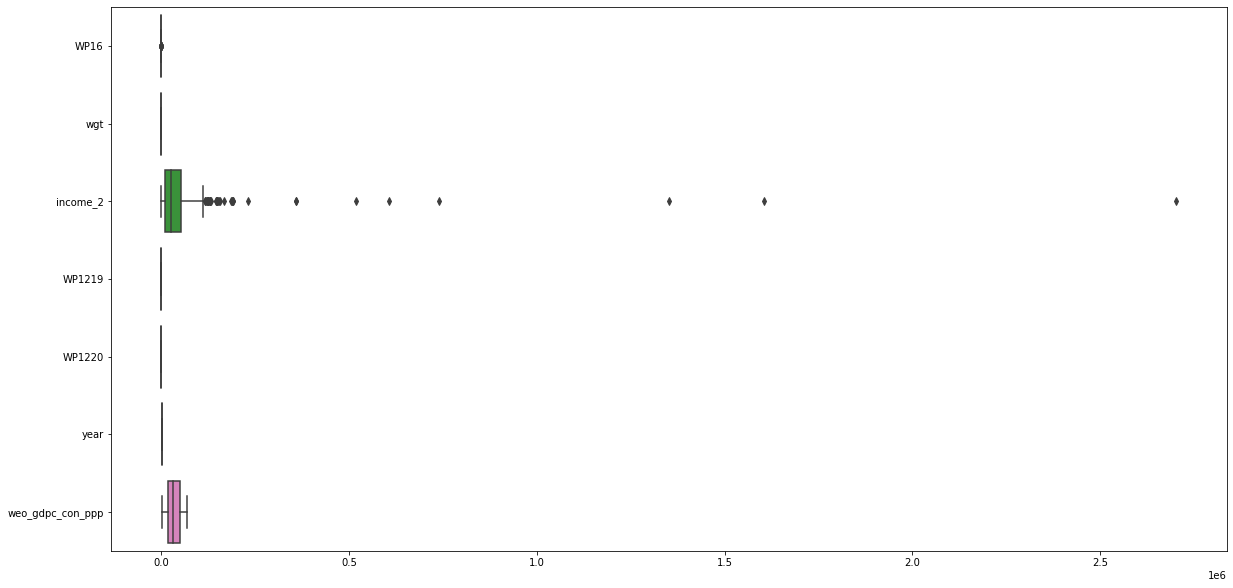

In [41]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
sns.boxplot(data= data[500:1000], orient="h",  ax = ax)

## Remove NaNs

In [9]:
data = data.interpolate(method='linear', axis=0)

---
---
---

In [40]:
dataset = NAMDataset(
    config=config,
    csv_file=data, #'data/GALLUP.csv',
    features_columns = ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
    targets_column = ["WP16"],
    weights_column = ["wgt"],   
#     one_hot=True,
)
dataset

NAMDatasetSample(
	features=tensor([3.0974e+04, 2.0000e+00, 3.8000e+01, 1.6759e+04]), 
	targets=tensor([1.]), 
	weights=tensor([0.4565])
)

In [41]:
weighted_sampler = WeightedRandomSampler(
    weights=dataset.weights,
    num_samples=len(dataset),
    replacement=True
)

In [42]:
train_dataset, test_dataset = torch.utils.data.random_split(
  dataset,
  [int(np.floor(len(dataset) * .9)),
   int(np.ceil(len(dataset) * .1))],
)
print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset, val_dataset = torch.utils.data.random_split(
  train_dataset,
  [int(np.floor(len(train_dataset) * .8)),
   int(np.ceil(len(train_dataset) * .2))],
)
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}")

train_dataloader = DataLoader(
  train_dataset,
  batch_size=config.batch_size,
  shuffle=True,
  num_workers=config.num_workers,
#   sampler=weighted_sampler,
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=config.batch_size * 5,
  shuffle=False,
  num_workers=config.num_workers,
)

train_dataset: 1206728, test_dataset: 134081
train_dataset: 965382, val_dataset: 241346


In [43]:
next(iter(train_dataloader))

[tensor([[1.7930e+03, 2.0000e+00, 4.0000e+01, 5.2336e+03],
         [7.8890e+03, 2.0000e+00, 1.7000e+01, 2.6061e+03],
         [1.2793e+04, 2.0000e+00, 2.5000e+01, 1.0572e+03],
         ...,
         [7.4095e+03, 2.0000e+00, 2.5000e+01, 1.8411e+03],
         [9.4302e+03, 1.0000e+00, 3.0000e+01, 1.8411e+03],
         [1.4289e+04, 1.0000e+00, 4.2000e+01, 4.2492e+03]]),
 tensor([[ 7.],
         [ 0.],
         [10.],
         ...,
         [ 3.],
         [ 5.],
         [ 5.]]),
 tensor([[2.5051],
         [0.5674],
         [0.9002],
         ...,
         [2.6331],
         [0.4706],
         [0.8630]])]

In [44]:
features, targets, *weights = next(iter(train_dataloader))

---
---
---

In [52]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, train_dataloader)
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=148)
        (1): LinReLU(in_features=148, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1)

In [53]:
features, targets, *weights = next(iter(train_dataloader))

In [61]:
model(features)

tensor([[      0.0000],
        [      0.0000],
        [      0.0000],
        ...,
        [   1612.4397],
        [ 405422.2188],
        [1220125.2500]], grad_fn=<AddBackward0>)

In [12]:
loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [13]:
for i in range(config.training_epochs):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
            print(f'loss: {loss.item()}')

loss: 3574734782464.0
loss: 111485878272.0
loss: 47233892352.0
loss: 106781220864.0
loss: 1066189952.0
loss: 34630424.0
loss: 19728906240.0
loss: 59250580.0
loss: 38.191280364990234
loss: 36.70461654663086
loss: 37.59029006958008
loss: 37.09481430053711
loss: 37.33030700683594
loss: 37.48571014404297
loss: 37.43302536010742
loss: 36.65161895751953
loss: 37.32002258300781
loss: 39.441959381103516
loss: 37.36842346191406
loss: 38.120323181152344
loss: 37.24638748168945
loss: 38.901832580566406
loss: 39.179893493652344
loss: 38.946495056152344
loss: 38.95313262939453
loss: 37.084842681884766
loss: 38.63157653808594
loss: 39.609825134277344
loss: 40.21871566772461
loss: 39.029876708984375
loss: 37.32095718383789
loss: 39.80905532836914
loss: 38.43172073364258
loss: 39.76947784423828
loss: 40.80961227416992
loss: 40.39934539794922
loss: 40.569759368896484
loss: 39.92286682128906
loss: 40.437950134277344
loss: 40.69986343383789
loss: 39.90713119506836
loss: 40.525997161865234
loss: 39.911907

loss: 84.72490692138672
loss: 82.74044036865234
loss: 86.01213073730469
loss: 88.0633544921875
loss: 85.77327728271484
loss: 86.98686218261719
loss: 88.22852325439453
loss: 88.25991821289062
loss: 85.6612319946289
loss: 87.60079193115234
loss: 87.48625183105469
loss: 88.21771240234375
loss: 85.47509002685547
loss: 89.73619079589844
loss: 88.48993682861328
loss: 89.97142028808594
loss: 88.57669830322266
loss: 91.07524108886719
loss: 89.53038024902344
loss: 91.3406982421875
loss: 91.34941101074219
loss: 90.37006378173828
loss: 90.9813461303711
loss: 88.6838150024414
loss: 90.12881469726562
loss: 89.02037811279297
loss: 90.33599090576172
loss: 90.85624694824219
loss: 93.33700561523438
loss: 93.35098266601562
loss: 88.78829193115234
loss: 91.42804718017578
loss: 92.23898315429688
loss: 92.30879974365234
loss: 90.76963806152344
loss: 93.70146942138672
loss: 92.06399536132812
loss: 93.19420623779297
loss: 91.05093383789062
loss: 92.51411437988281
loss: 95.00755310058594
loss: 91.517547607421

loss: 155.91241455078125
loss: 156.90219116210938
loss: 158.75582885742188
loss: 155.85462951660156
loss: 160.56497192382812
loss: 156.43031311035156
loss: 157.41305541992188
loss: 160.30355834960938
loss: 158.27886962890625
loss: 156.8771209716797
loss: 161.56411743164062
loss: 157.06060791015625
loss: 158.40489196777344
loss: 159.39584350585938
loss: 163.76625061035156
loss: 156.34420776367188
loss: 160.29080200195312
loss: 161.13229370117188
loss: 162.9802703857422
loss: 161.1189422607422
loss: 160.443115234375
loss: 160.89352416992188
loss: 164.22634887695312
loss: 161.2825927734375
loss: 162.4498748779297
loss: 164.36553955078125
loss: 162.25811767578125
loss: 165.76071166992188
loss: 165.39016723632812
loss: 164.28094482421875
loss: 164.17361450195312
loss: 160.6943817138672
loss: 164.64447021484375
loss: 163.8174285888672
loss: 165.3560791015625
loss: 164.72596740722656
loss: 167.107177734375
loss: 164.19757080078125
loss: 166.47506713867188
loss: 165.12628173828125
loss: 166.37

KeyboardInterrupt: 